In [3]:
import torch
from torch import nn,optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from utils import Logger

In [ ]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
        #  transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        transforms.Normalize([0.5],[0.5])
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [47]:
def ss_data():
    return torch.load('../dataloader_32.pt')
data_loader = ss_data()
num_batches = len(data_loader)

In [9]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 44
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [12]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 22, 28)

In [53]:
def images_to_vectors(images):
    return images.view(images.size(0),44)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 11, 4)

In [13]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 44
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet()

In [45]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100,dtype=torch.float32))
    return n


In [16]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [17]:
loss = nn.BCELoss()

In [46]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1,dtype=torch.float32))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1,dtype=torch.float32))
    return data

In [19]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [20]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [50]:
num_test_samples = 16
test_noise = noise(num_test_samples)

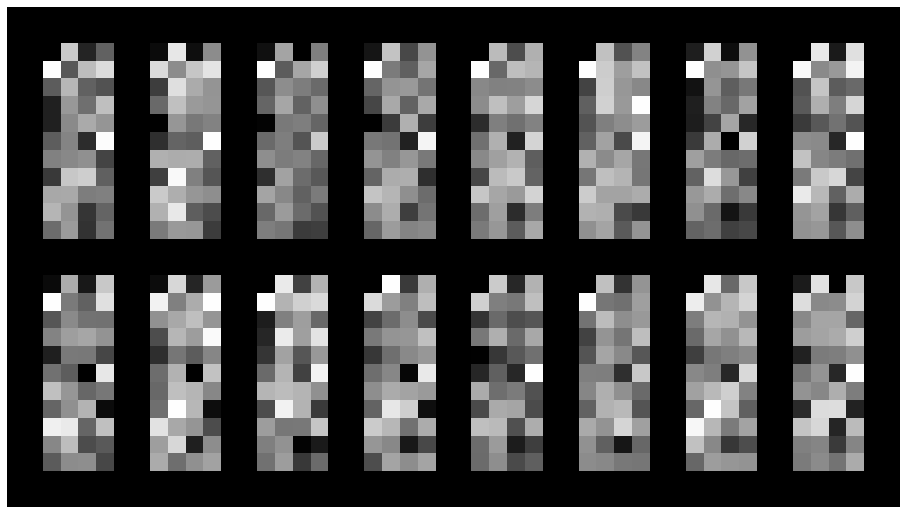

Epoch: [0/200], Batch Num: [0/12]
Discriminator Loss: 0.7257, Generator Loss: 0.6865
D(x): 0.9753, D(G(z)): 0.5034


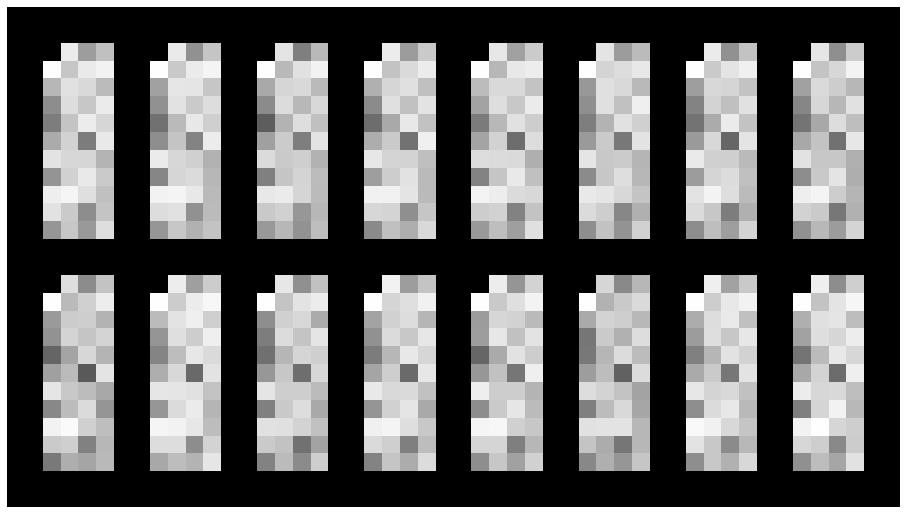

Epoch: [1/200], Batch Num: [0/12]
Discriminator Loss: 0.8987, Generator Loss: 0.5513
D(x): 0.9979, D(G(z)): 0.5916


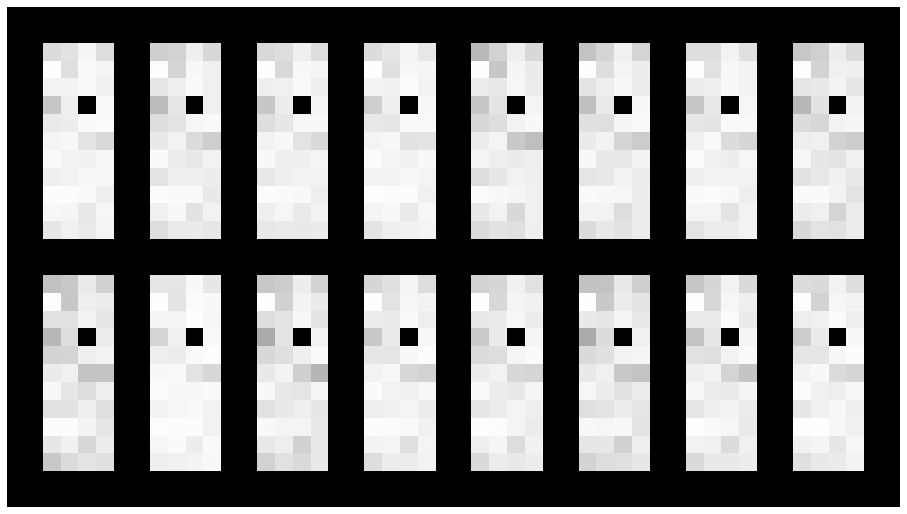

Epoch: [2/200], Batch Num: [0/12]
Discriminator Loss: 0.8006, Generator Loss: 0.6204
D(x): 0.9574, D(G(z)): 0.5298


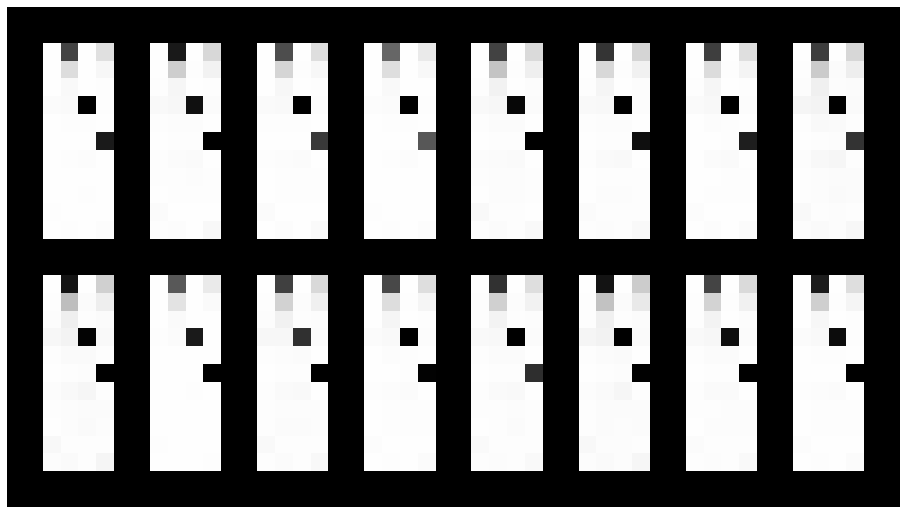

Epoch: [3/200], Batch Num: [0/12]
Discriminator Loss: 0.6752, Generator Loss: 0.7737
D(x): 0.9478, D(G(z)): 0.4610


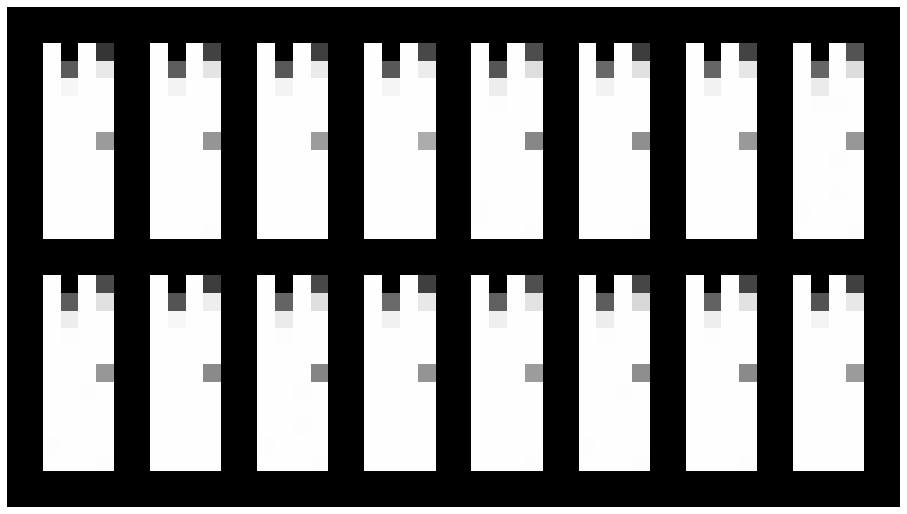

Epoch: [4/200], Batch Num: [0/12]
Discriminator Loss: 0.4125, Generator Loss: 1.2788
D(x): 0.9733, D(G(z)): 0.3175


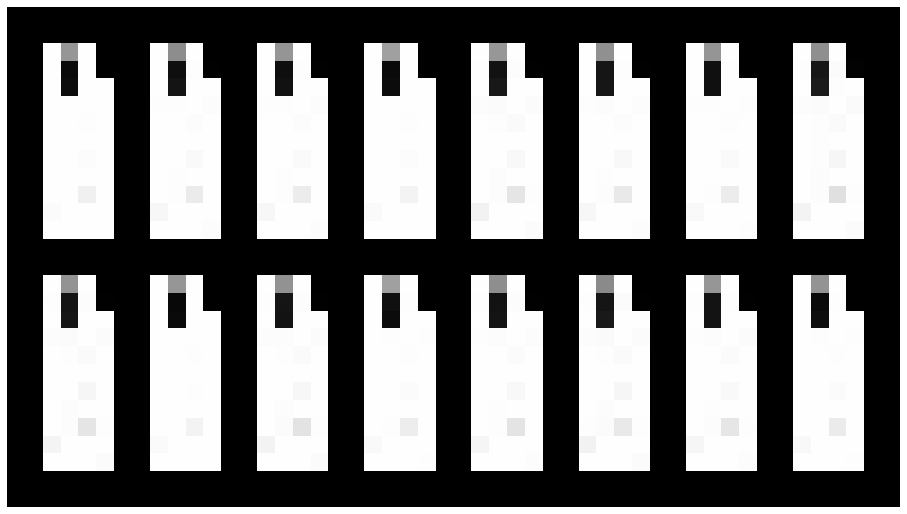

Epoch: [5/200], Batch Num: [0/12]
Discriminator Loss: 0.0717, Generator Loss: 3.1030
D(x): 0.9928, D(G(z)): 0.0617


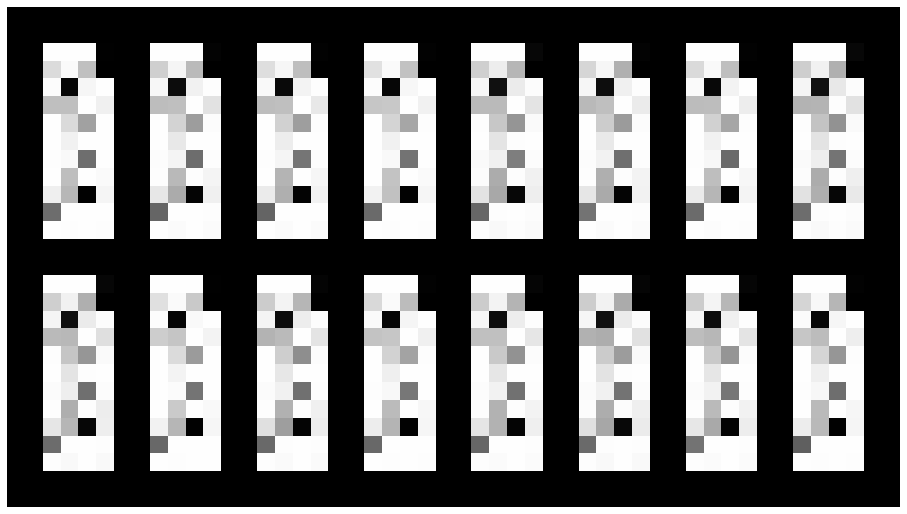

Epoch: [6/200], Batch Num: [0/12]
Discriminator Loss: 0.0554, Generator Loss: 3.4304
D(x): 0.9950, D(G(z)): 0.0477


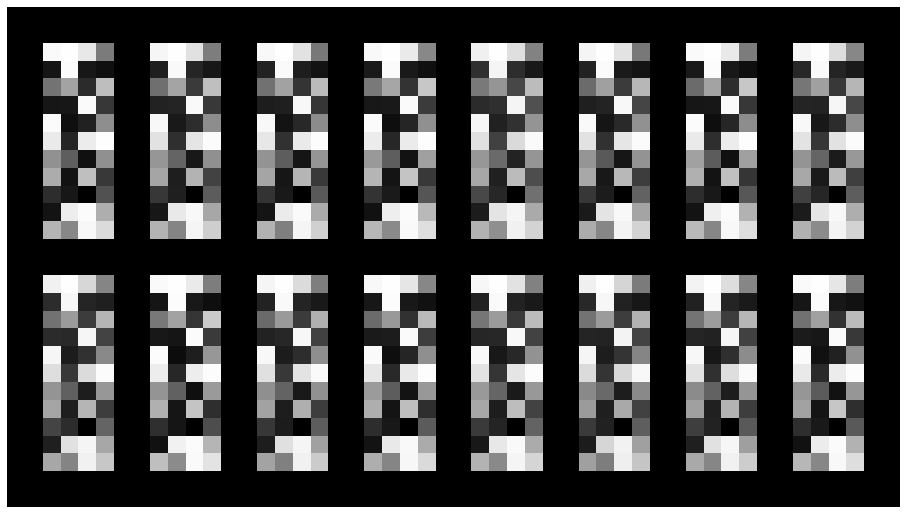

Epoch: [7/200], Batch Num: [0/12]
Discriminator Loss: 0.1159, Generator Loss: 2.8372
D(x): 0.9956, D(G(z)): 0.1018


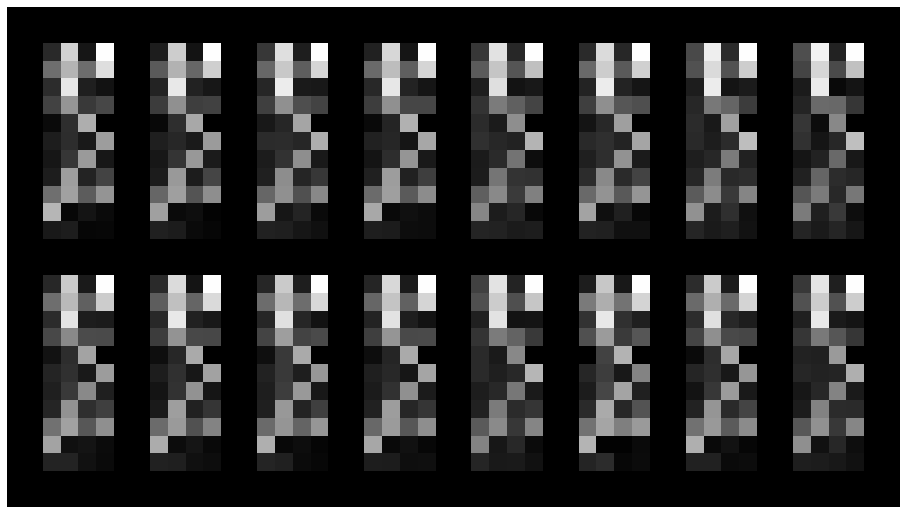

Epoch: [8/200], Batch Num: [0/12]
Discriminator Loss: 0.3784, Generator Loss: 1.4575
D(x): 1.0000, D(G(z)): 0.3122


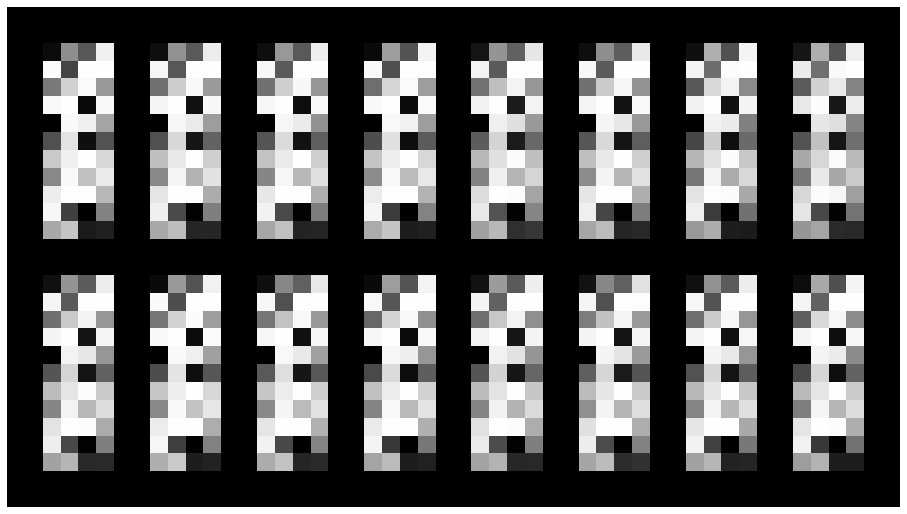

Epoch: [9/200], Batch Num: [0/12]
Discriminator Loss: 0.0420, Generator Loss: 3.9710
D(x): 1.0000, D(G(z)): 0.0408


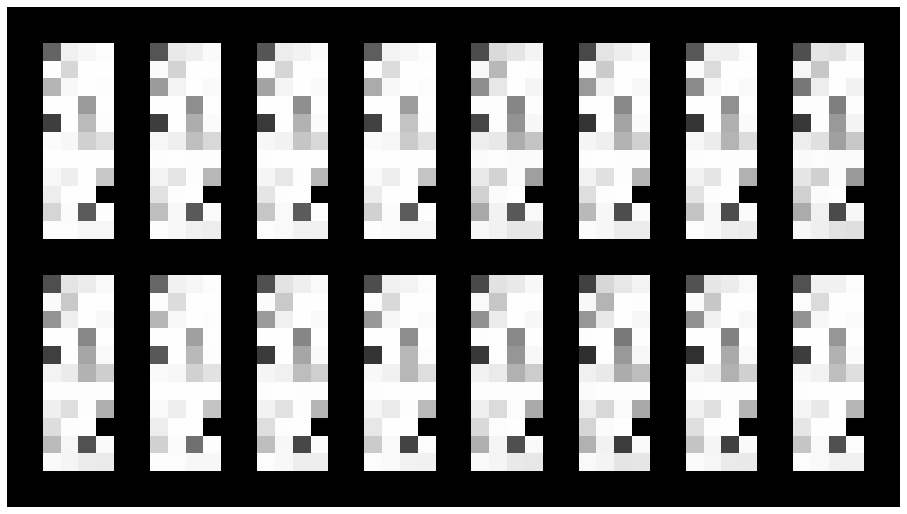

Epoch: [10/200], Batch Num: [0/12]
Discriminator Loss: 0.0308, Generator Loss: 5.1143
D(x): 1.0000, D(G(z)): 0.0297


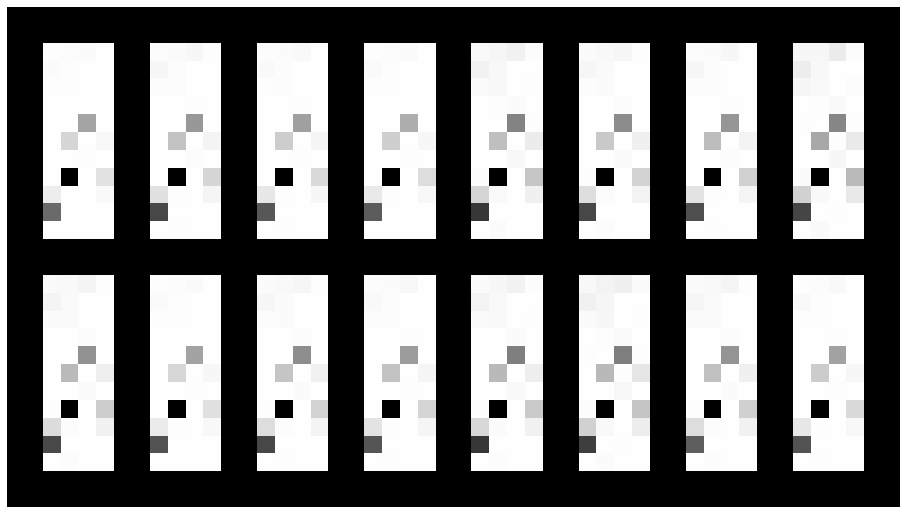

Epoch: [11/200], Batch Num: [0/12]
Discriminator Loss: 0.0260, Generator Loss: 4.3869
D(x): 1.0000, D(G(z)): 0.0252


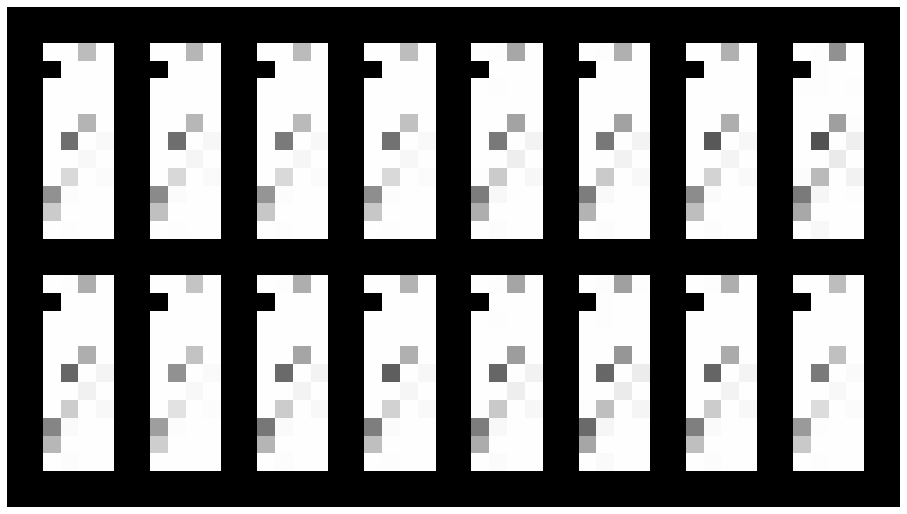

Epoch: [12/200], Batch Num: [0/12]
Discriminator Loss: 0.0058, Generator Loss: 5.9856
D(x): 0.9992, D(G(z)): 0.0047


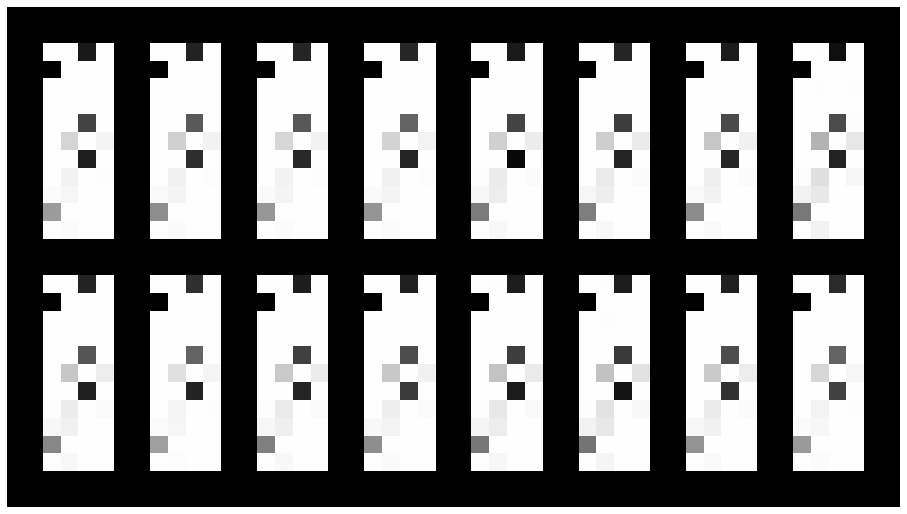

Epoch: [13/200], Batch Num: [0/12]
Discriminator Loss: 0.0024, Generator Loss: 7.0038
D(x): 0.9996, D(G(z)): 0.0019


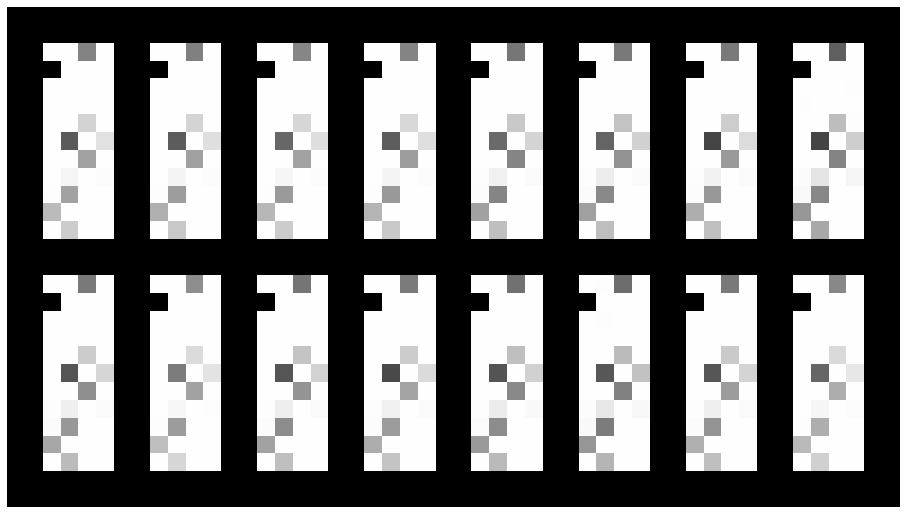

Epoch: [14/200], Batch Num: [0/12]
Discriminator Loss: 0.0028, Generator Loss: 6.6121
D(x): 0.9996, D(G(z)): 0.0024


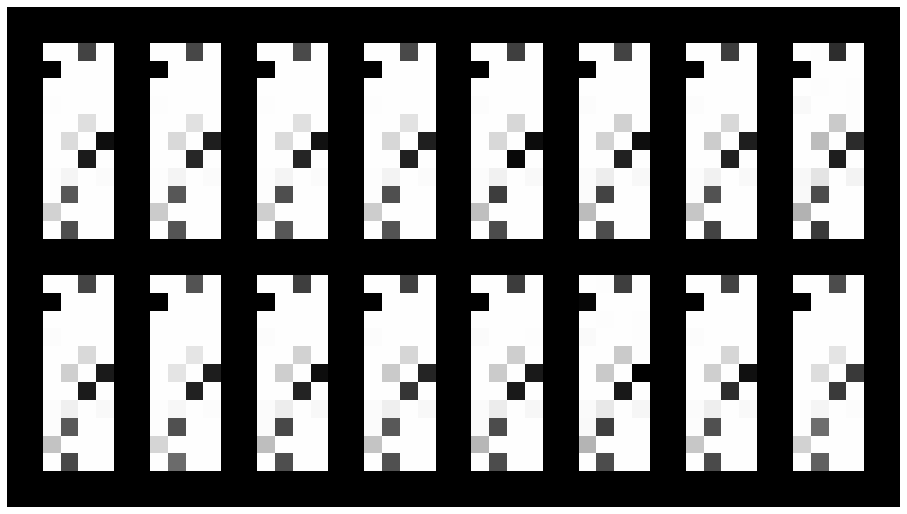

Epoch: [15/200], Batch Num: [0/12]
Discriminator Loss: 0.0021, Generator Loss: 6.7500
D(x): 0.9999, D(G(z)): 0.0020


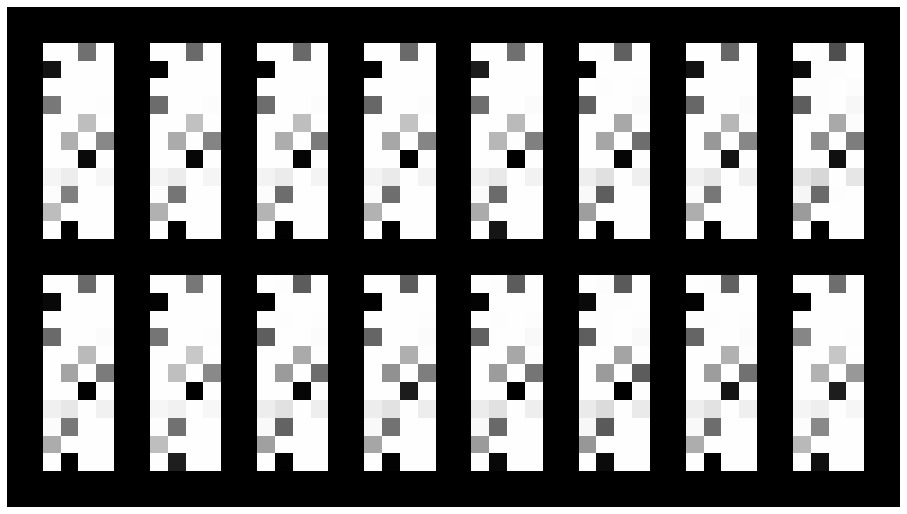

Epoch: [16/200], Batch Num: [0/12]
Discriminator Loss: 0.0013, Generator Loss: 7.2072
D(x): 0.9999, D(G(z)): 0.0012


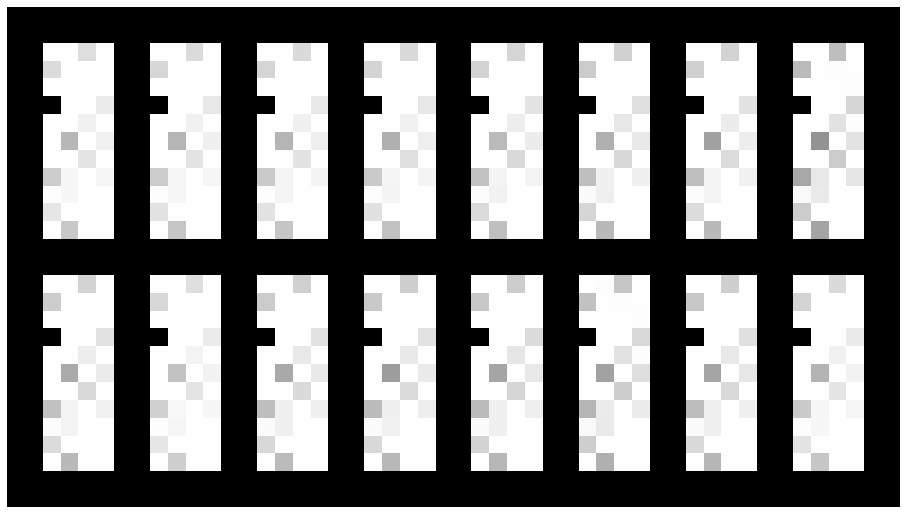

Epoch: [17/200], Batch Num: [0/12]
Discriminator Loss: 0.0020, Generator Loss: 6.9829
D(x): 1.0000, D(G(z)): 0.0020


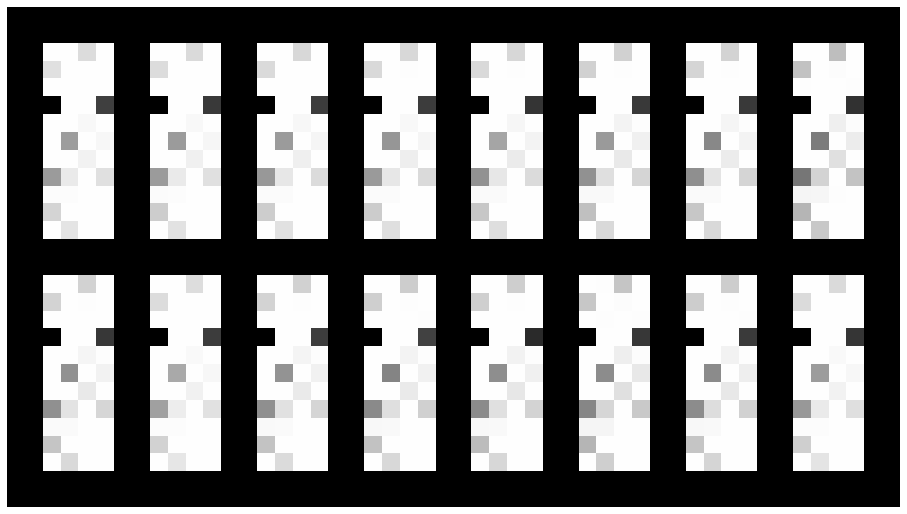

Epoch: [18/200], Batch Num: [0/12]
Discriminator Loss: 0.0016, Generator Loss: 7.0899
D(x): 1.0000, D(G(z)): 0.0016


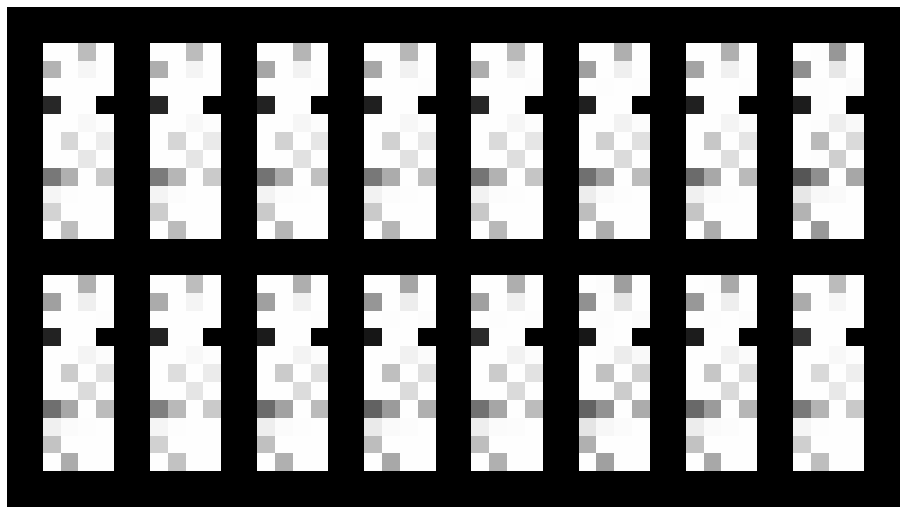

Epoch: [19/200], Batch Num: [0/12]
Discriminator Loss: 0.0076, Generator Loss: 7.1121
D(x): 0.9972, D(G(z)): 0.0011


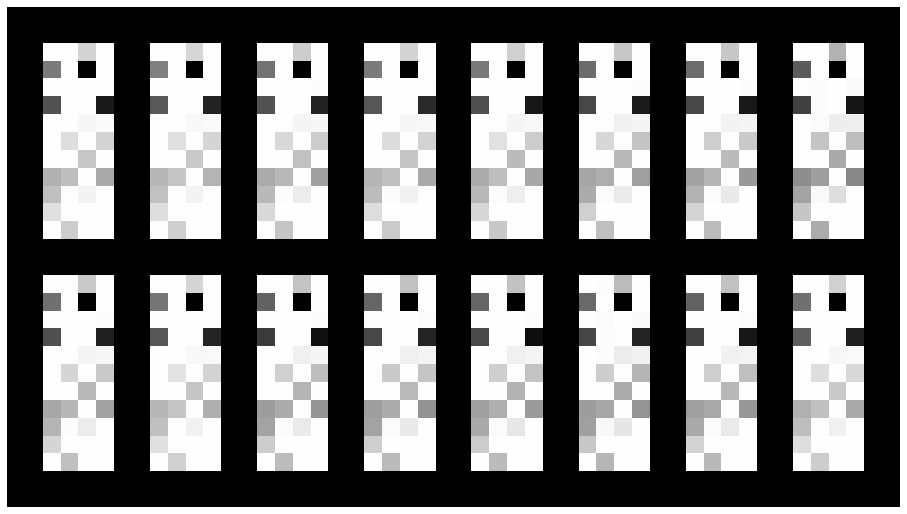

Epoch: [20/200], Batch Num: [0/12]
Discriminator Loss: 0.0018, Generator Loss: 6.9660
D(x): 0.9999, D(G(z)): 0.0017


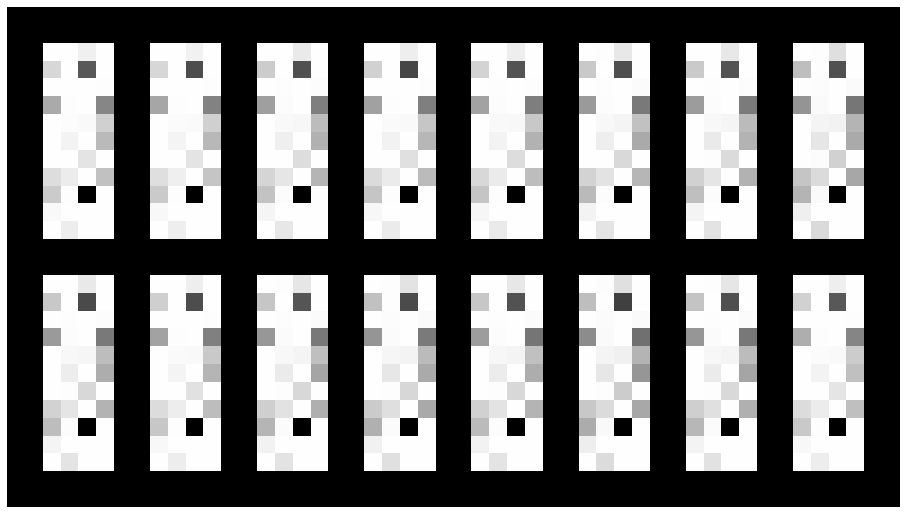

Epoch: [21/200], Batch Num: [0/12]
Discriminator Loss: 0.0019, Generator Loss: 6.9227
D(x): 1.0000, D(G(z)): 0.0018


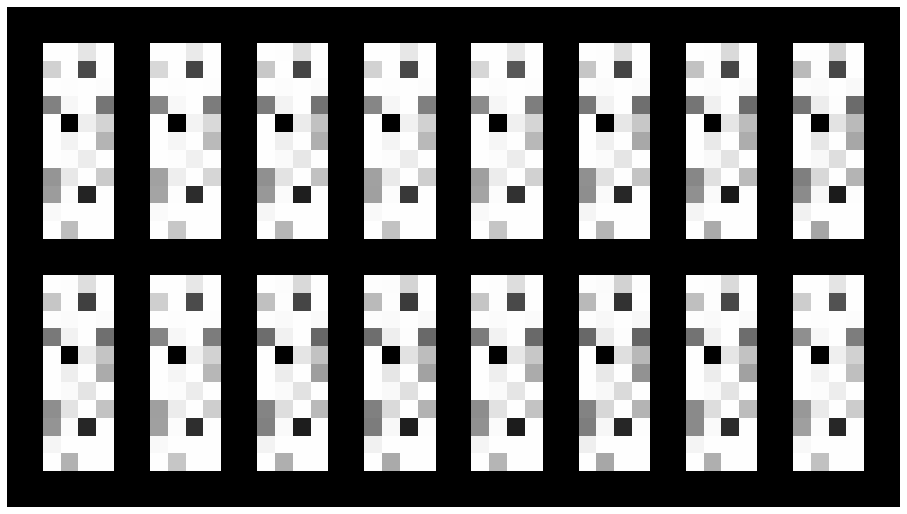

Epoch: [22/200], Batch Num: [0/12]
Discriminator Loss: 0.0016, Generator Loss: 7.2285
D(x): 0.9997, D(G(z)): 0.0012


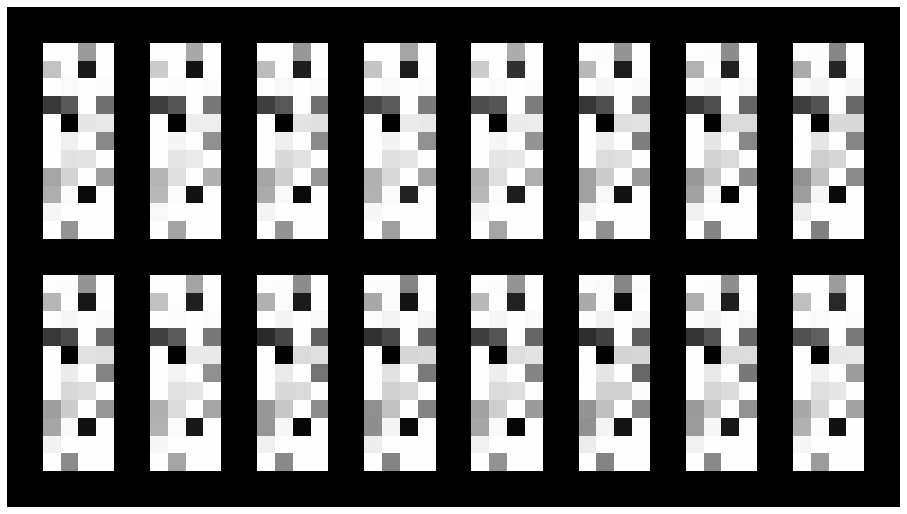

Epoch: [23/200], Batch Num: [0/12]
Discriminator Loss: 0.0013, Generator Loss: 7.1338
D(x): 1.0000, D(G(z)): 0.0013


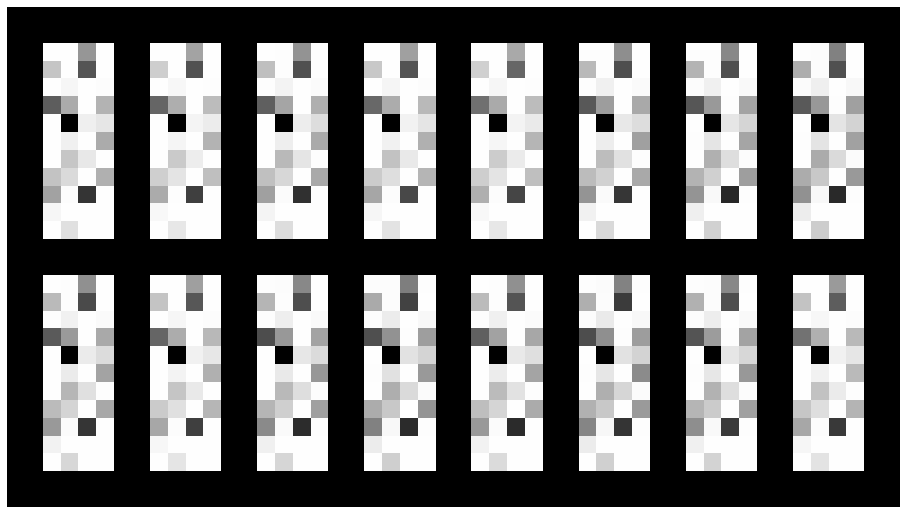

Epoch: [24/200], Batch Num: [0/12]
Discriminator Loss: 0.0012, Generator Loss: 7.4560
D(x): 0.9998, D(G(z)): 0.0011


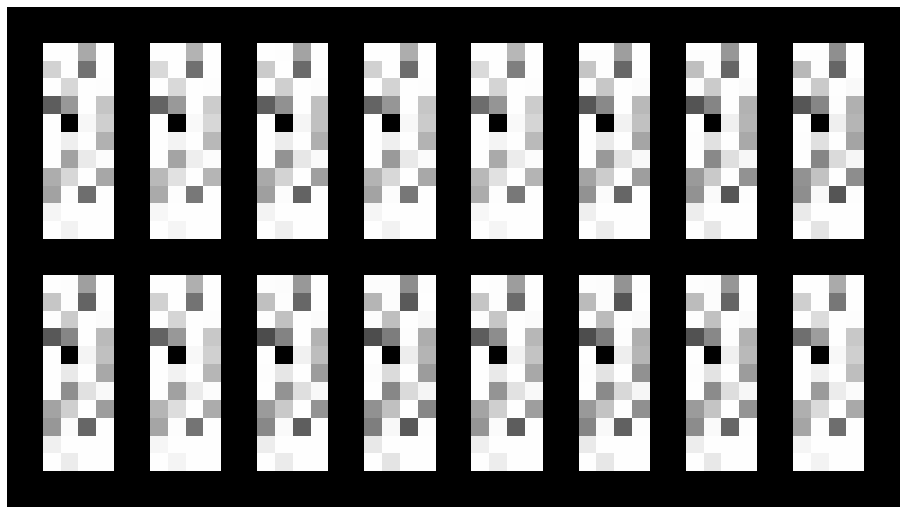

Epoch: [25/200], Batch Num: [0/12]
Discriminator Loss: 0.0007, Generator Loss: 8.3907
D(x): 0.9998, D(G(z)): 0.0005


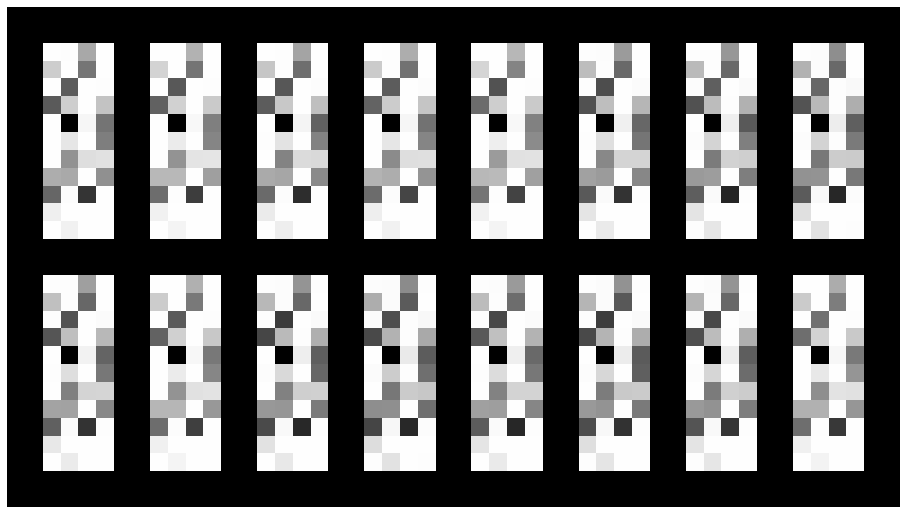

Epoch: [26/200], Batch Num: [0/12]
Discriminator Loss: 0.0023, Generator Loss: 7.8513
D(x): 0.9988, D(G(z)): 0.0007


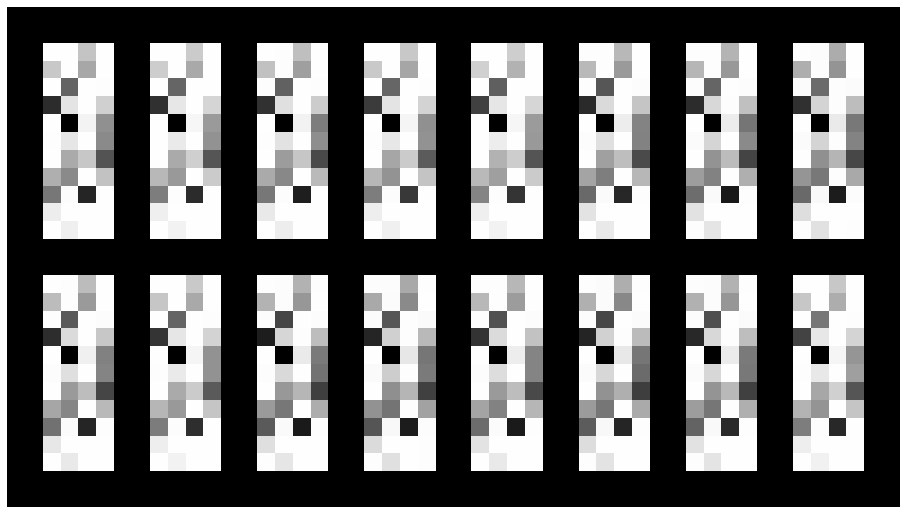

Epoch: [27/200], Batch Num: [0/12]
Discriminator Loss: 0.0008, Generator Loss: 7.8786
D(x): 1.0000, D(G(z)): 0.0008


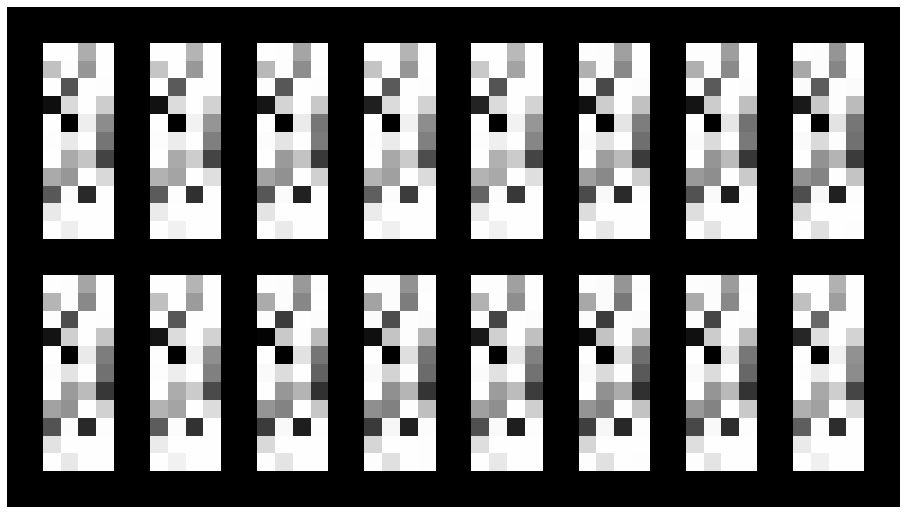

Epoch: [28/200], Batch Num: [0/12]
Discriminator Loss: 0.0007, Generator Loss: 7.9612
D(x): 1.0000, D(G(z)): 0.0007


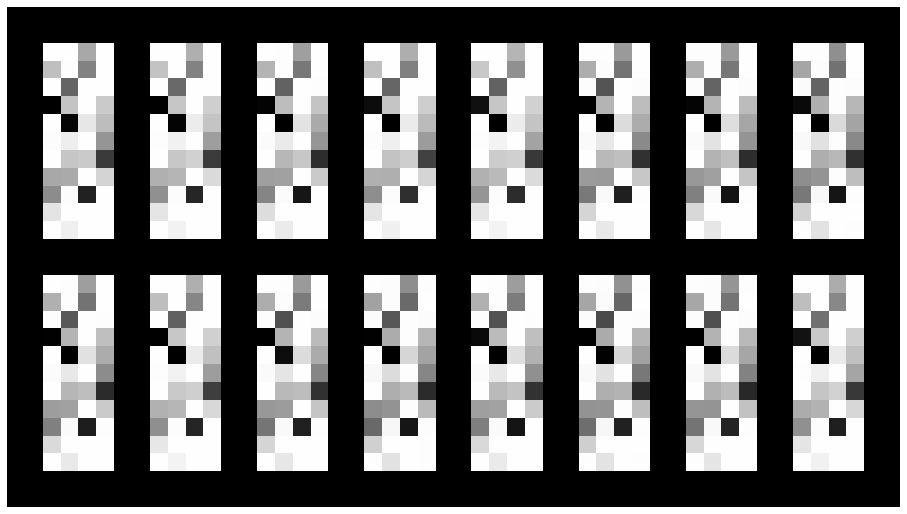

Epoch: [29/200], Batch Num: [0/12]
Discriminator Loss: 0.0008, Generator Loss: 7.8911
D(x): 1.0000, D(G(z)): 0.0008


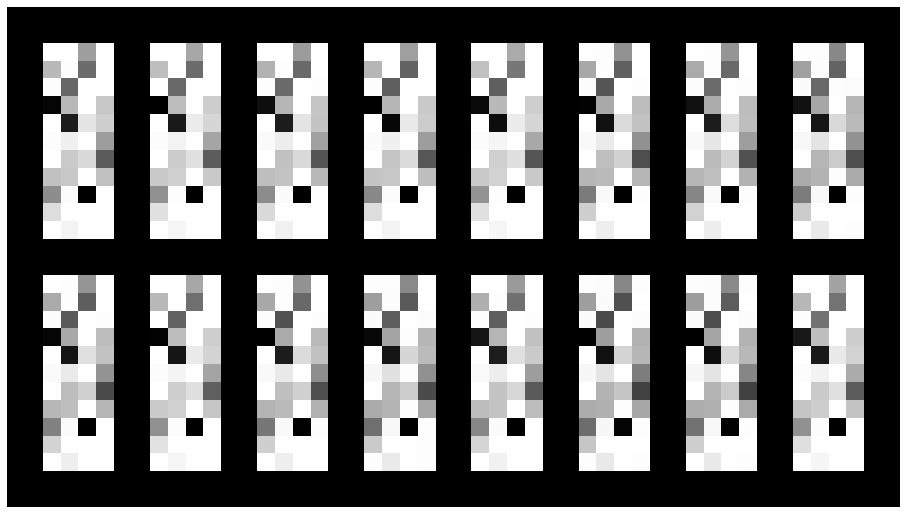

Epoch: [30/200], Batch Num: [0/12]
Discriminator Loss: 0.0016, Generator Loss: 8.1903
D(x): 0.9992, D(G(z)): 0.0006


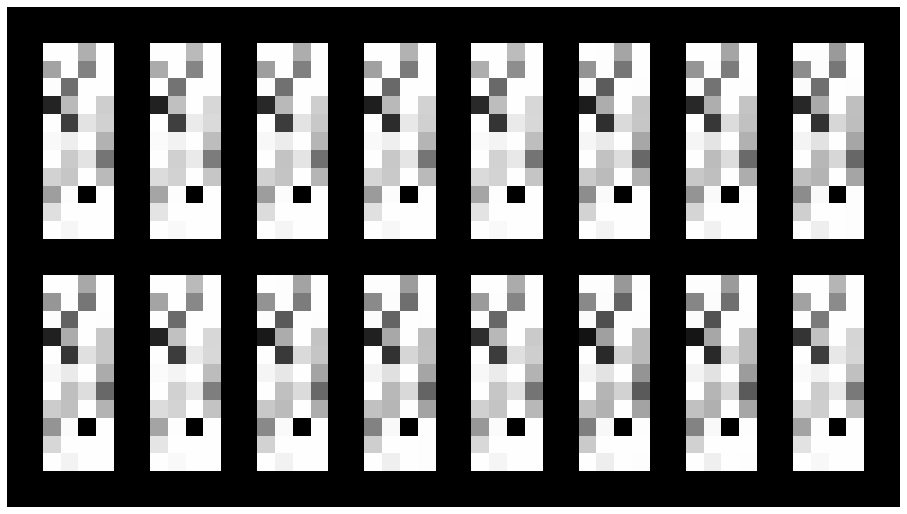

Epoch: [31/200], Batch Num: [0/12]
Discriminator Loss: 0.0004, Generator Loss: 8.4762
D(x): 1.0000, D(G(z)): 0.0004


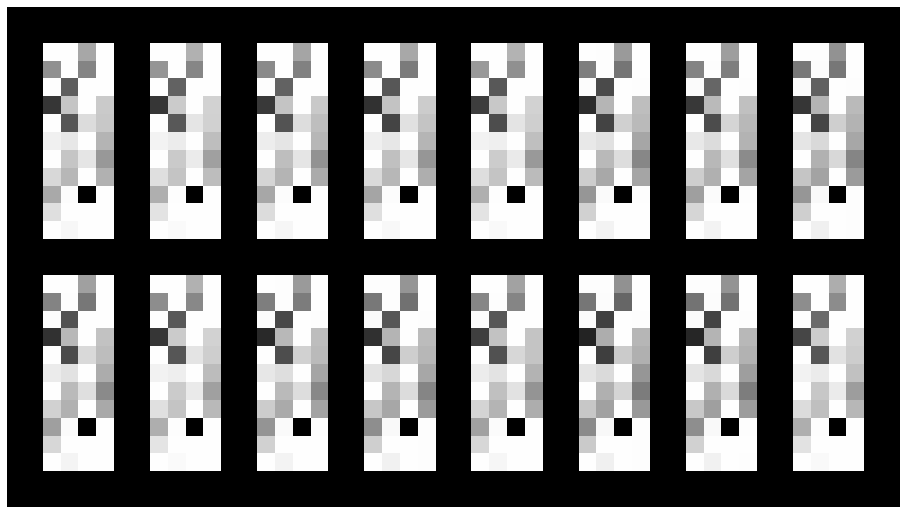

Epoch: [32/200], Batch Num: [0/12]
Discriminator Loss: 0.0004, Generator Loss: 8.4384
D(x): 1.0000, D(G(z)): 0.0004


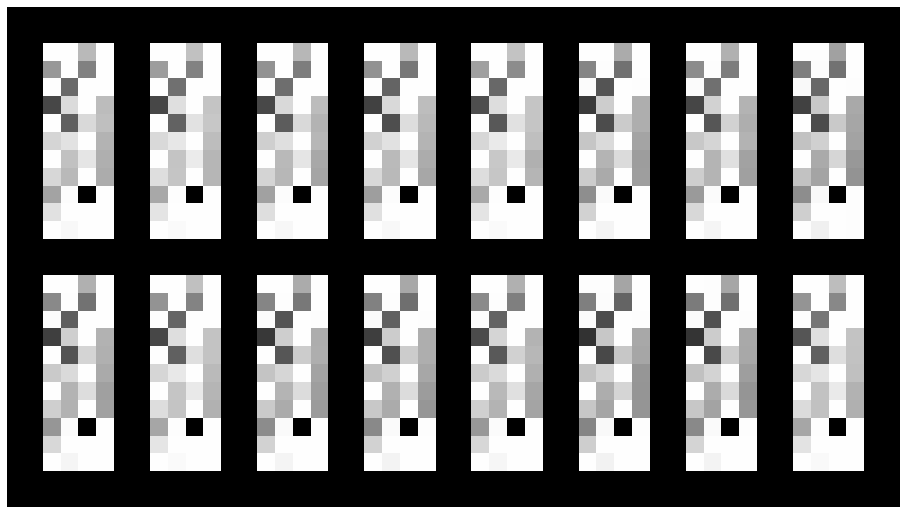

Epoch: [33/200], Batch Num: [0/12]
Discriminator Loss: 0.0005, Generator Loss: 8.5562
D(x): 1.0000, D(G(z)): 0.0005


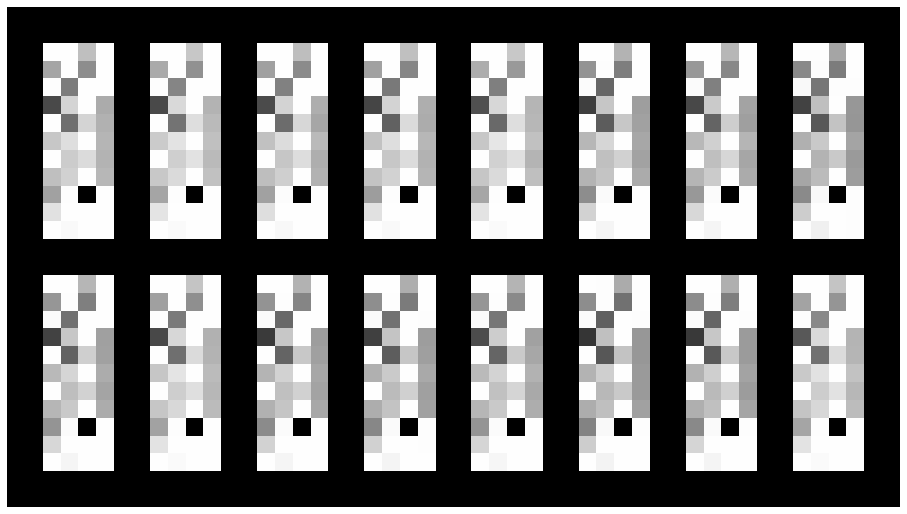

Epoch: [34/200], Batch Num: [0/12]
Discriminator Loss: 0.0003, Generator Loss: 8.5258
D(x): 1.0000, D(G(z)): 0.0003


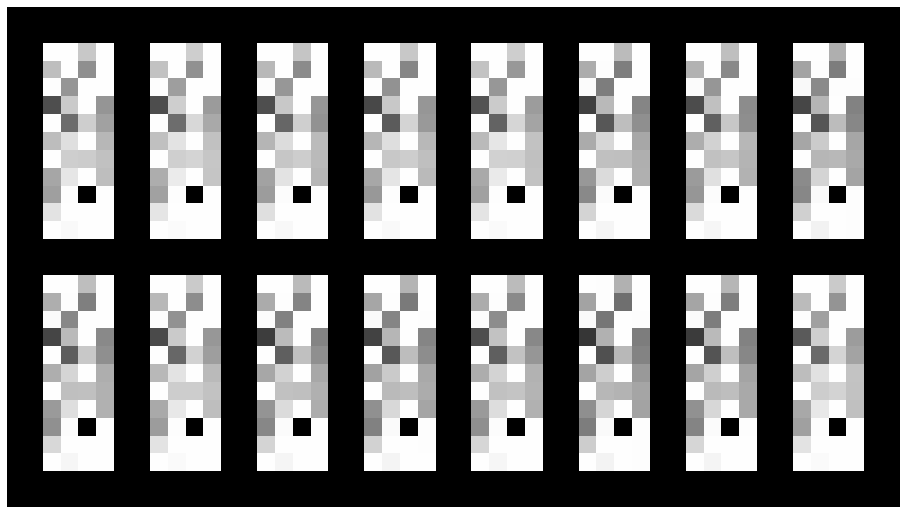

Epoch: [35/200], Batch Num: [0/12]
Discriminator Loss: 0.0005, Generator Loss: 8.4270
D(x): 1.0000, D(G(z)): 0.0005


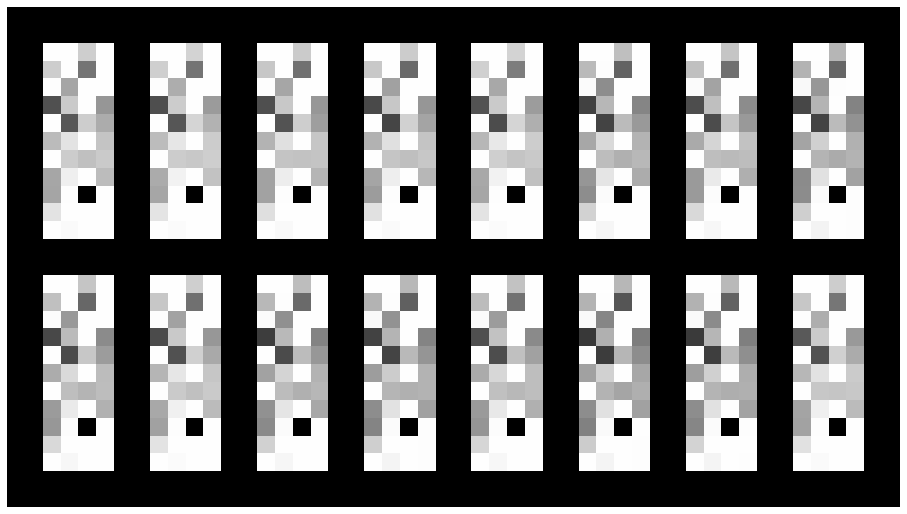

Epoch: [36/200], Batch Num: [0/12]
Discriminator Loss: 0.0009, Generator Loss: 8.5538
D(x): 0.9995, D(G(z)): 0.0003


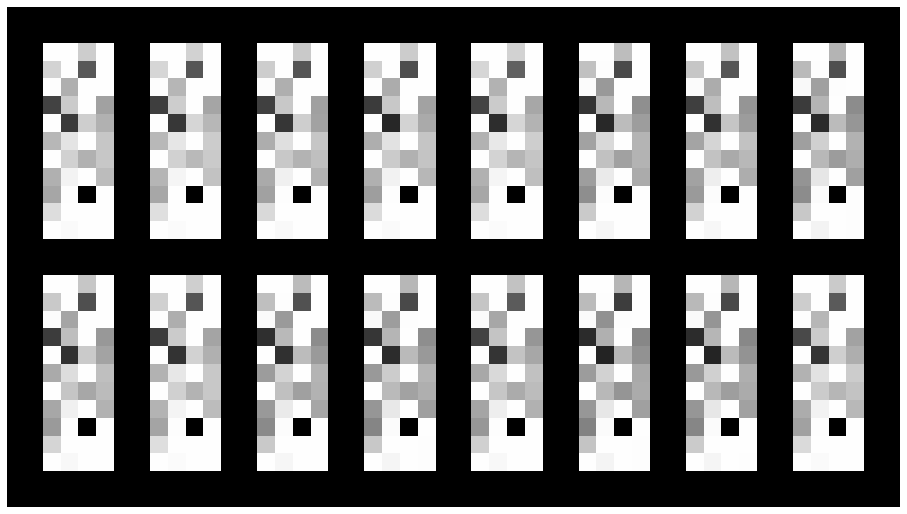

Epoch: [37/200], Batch Num: [0/12]
Discriminator Loss: 0.0003, Generator Loss: 8.7404
D(x): 1.0000, D(G(z)): 0.0003


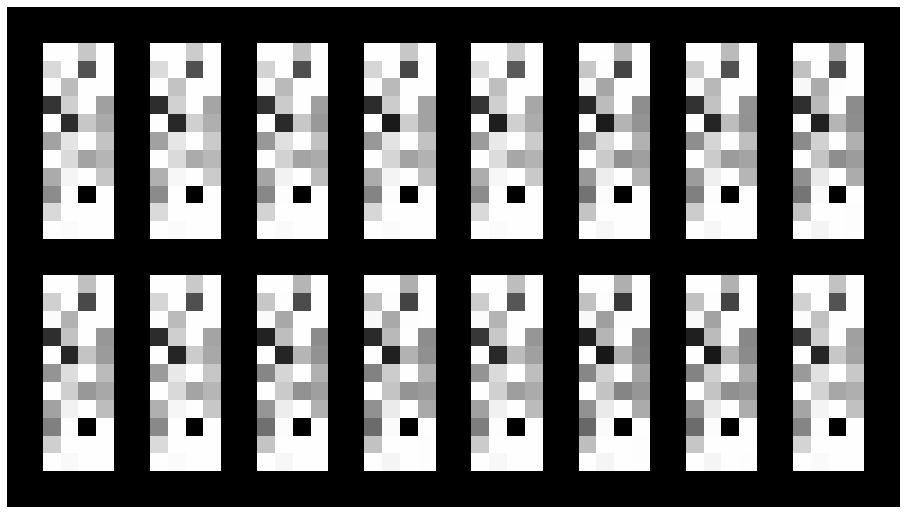

Epoch: [38/200], Batch Num: [0/12]
Discriminator Loss: 0.0003, Generator Loss: 8.9707
D(x): 1.0000, D(G(z)): 0.0003


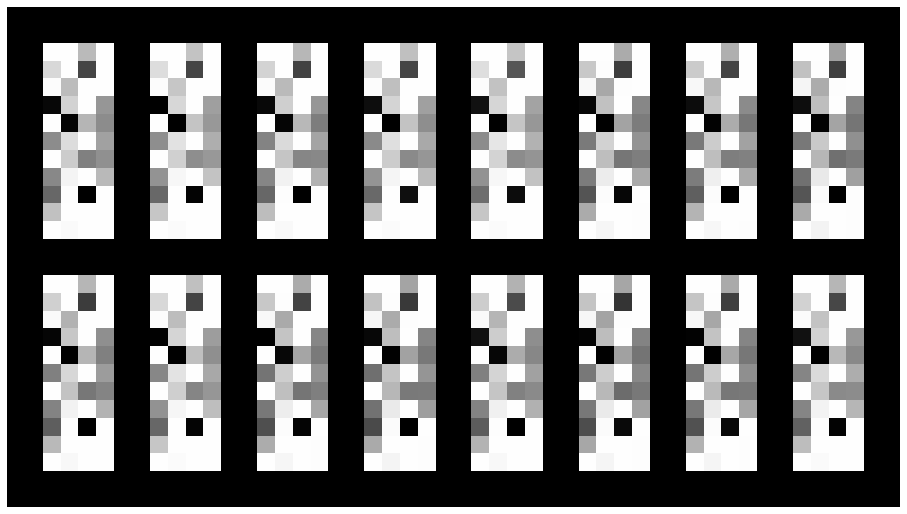

Epoch: [39/200], Batch Num: [0/12]
Discriminator Loss: 0.0003, Generator Loss: 8.6841
D(x): 1.0000, D(G(z)): 0.0003


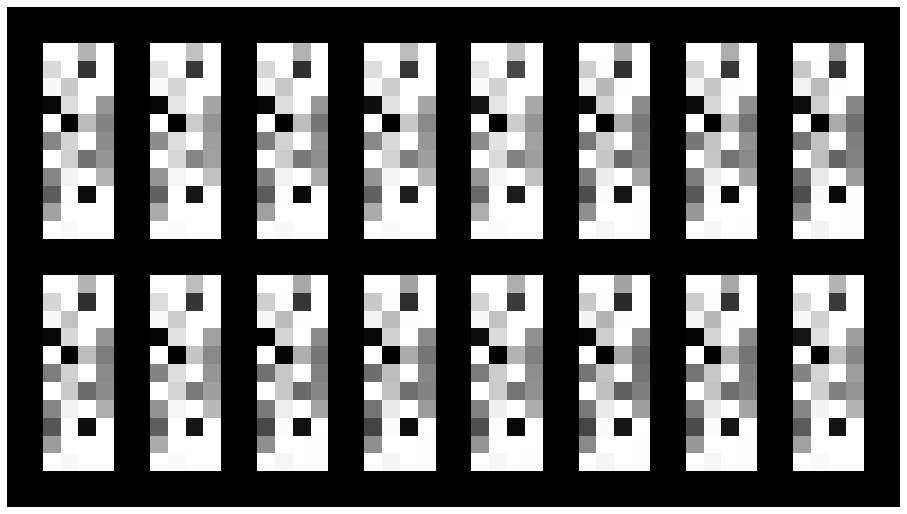

Epoch: [40/200], Batch Num: [0/12]
Discriminator Loss: 0.0003, Generator Loss: 8.7903
D(x): 1.0000, D(G(z)): 0.0003


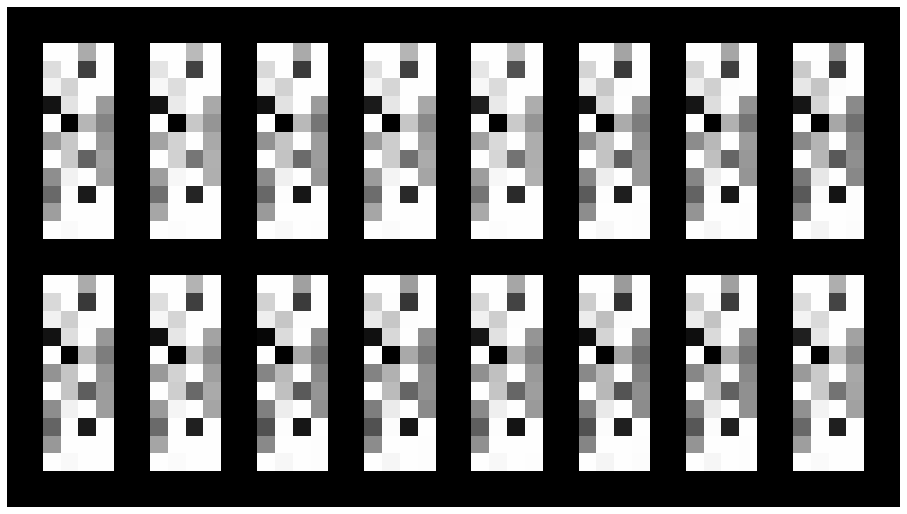

Epoch: [41/200], Batch Num: [0/12]
Discriminator Loss: 0.0003, Generator Loss: 8.9511
D(x): 1.0000, D(G(z)): 0.0003


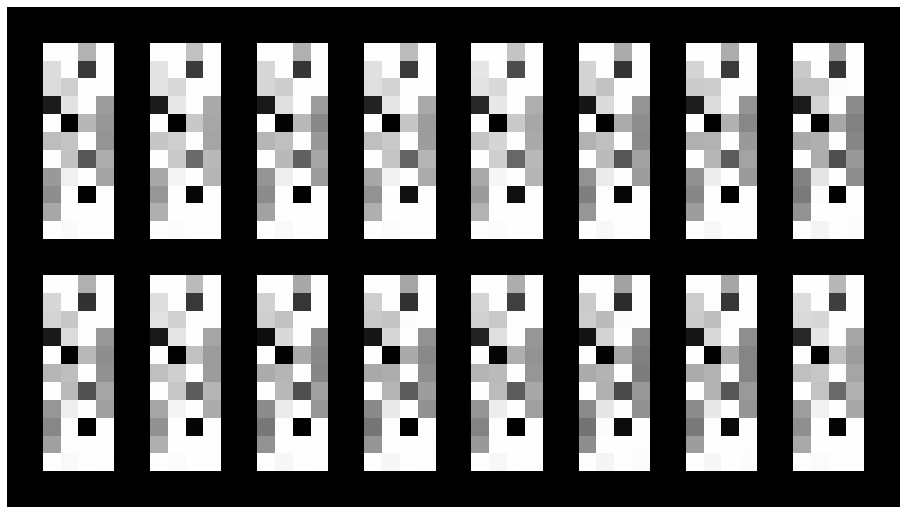

Epoch: [42/200], Batch Num: [0/12]
Discriminator Loss: 0.0006, Generator Loss: 8.0805
D(x): 1.0000, D(G(z)): 0.0006


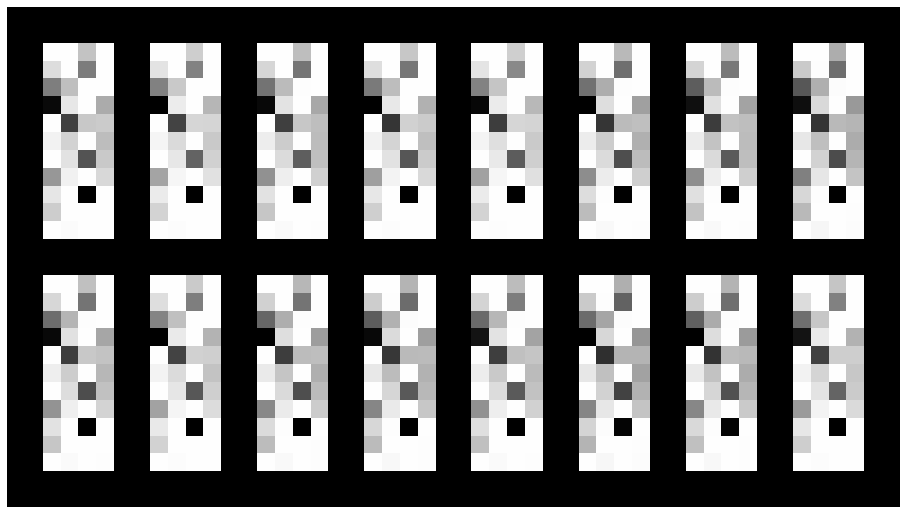

Epoch: [43/200], Batch Num: [0/12]
Discriminator Loss: 0.0004, Generator Loss: 8.7027
D(x): 1.0000, D(G(z)): 0.0004


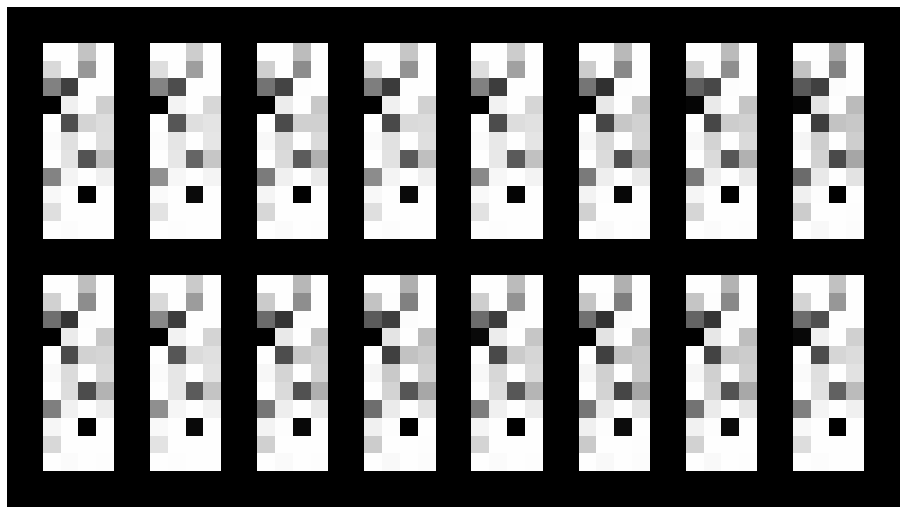

Epoch: [44/200], Batch Num: [0/12]
Discriminator Loss: 0.0003, Generator Loss: 9.4851
D(x): 0.9999, D(G(z)): 0.0001


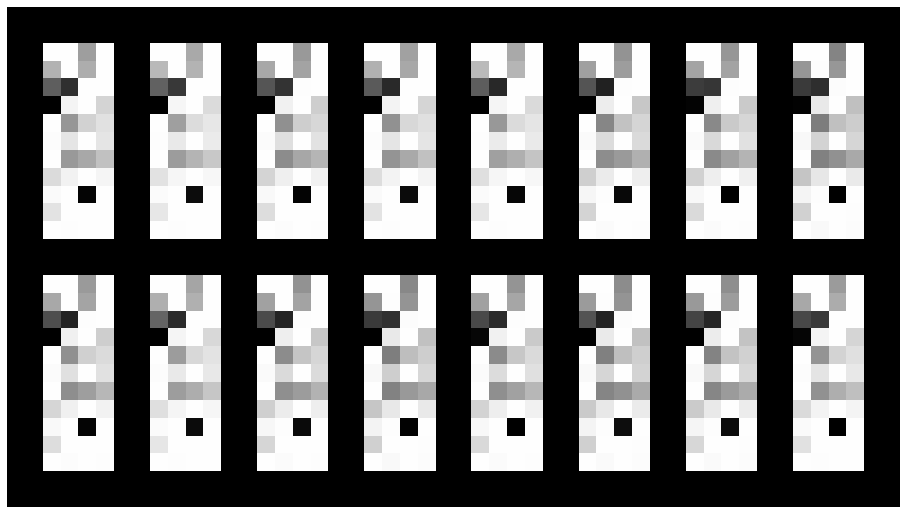

Epoch: [45/200], Batch Num: [0/12]
Discriminator Loss: 0.0002, Generator Loss: 9.1885
D(x): 1.0000, D(G(z)): 0.0002


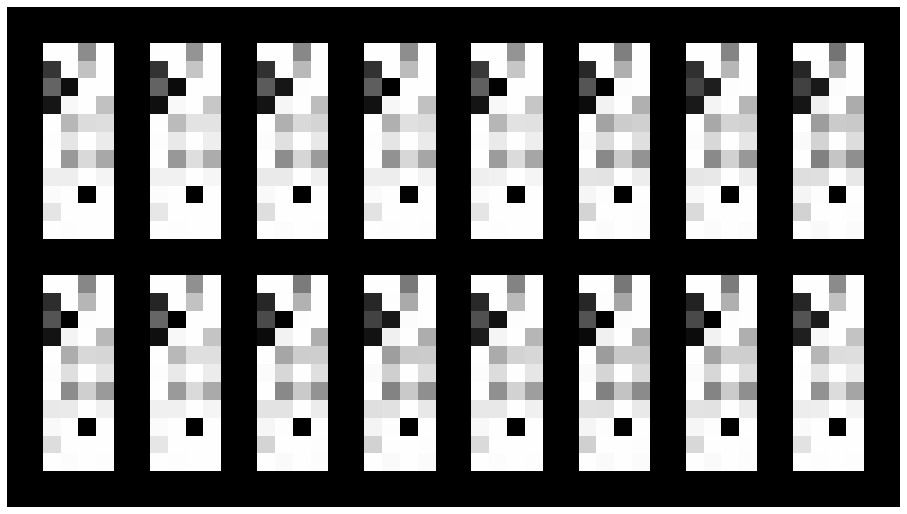

Epoch: [46/200], Batch Num: [0/12]
Discriminator Loss: 0.0003, Generator Loss: 9.0176
D(x): 1.0000, D(G(z)): 0.0003


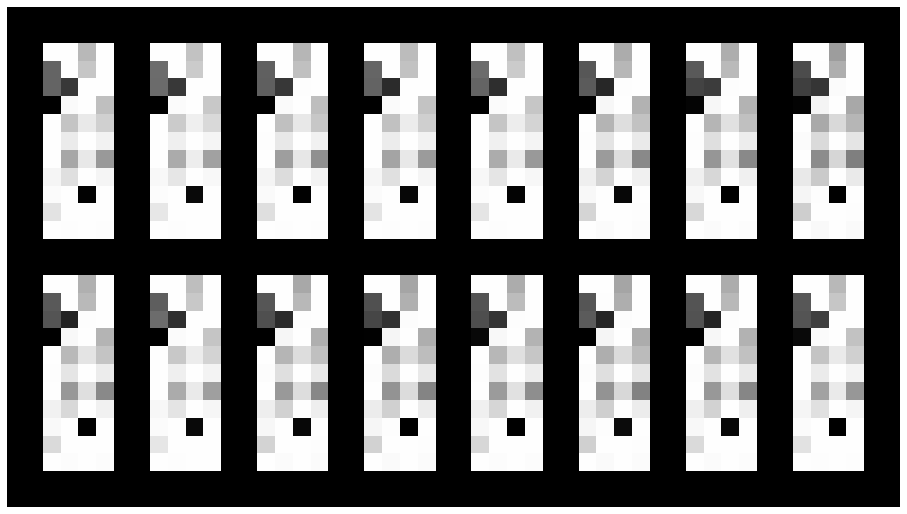

Epoch: [47/200], Batch Num: [0/12]
Discriminator Loss: 0.0003, Generator Loss: 8.9203
D(x): 1.0000, D(G(z)): 0.0003


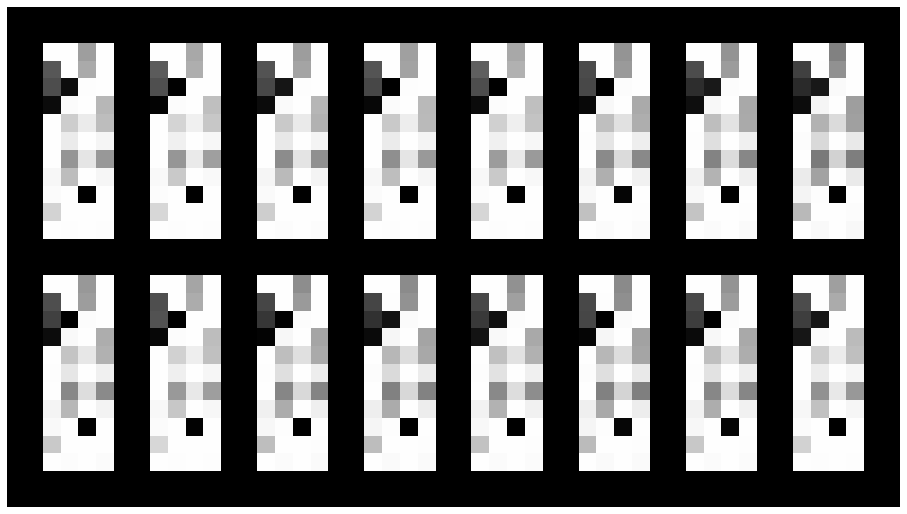

Epoch: [48/200], Batch Num: [0/12]
Discriminator Loss: 0.0002, Generator Loss: 9.3124
D(x): 1.0000, D(G(z)): 0.0002


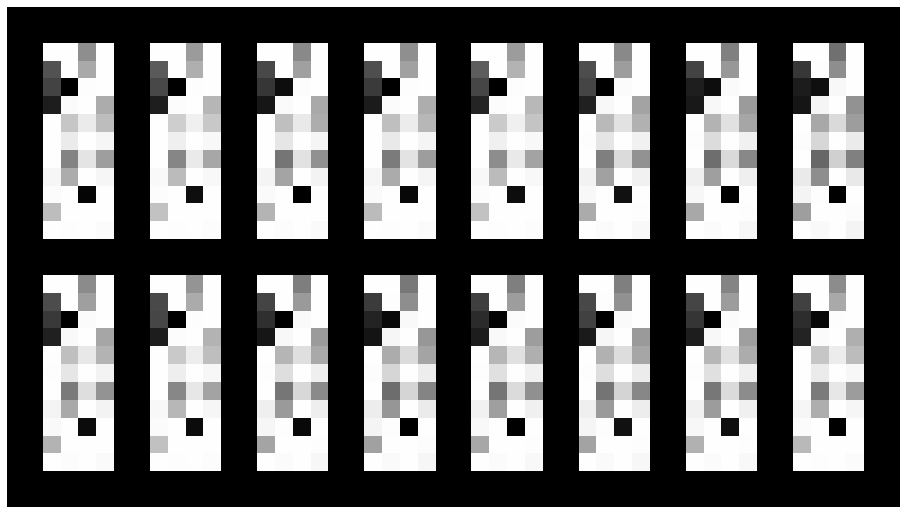

Epoch: [49/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 9.8947
D(x): 1.0000, D(G(z)): 0.0001


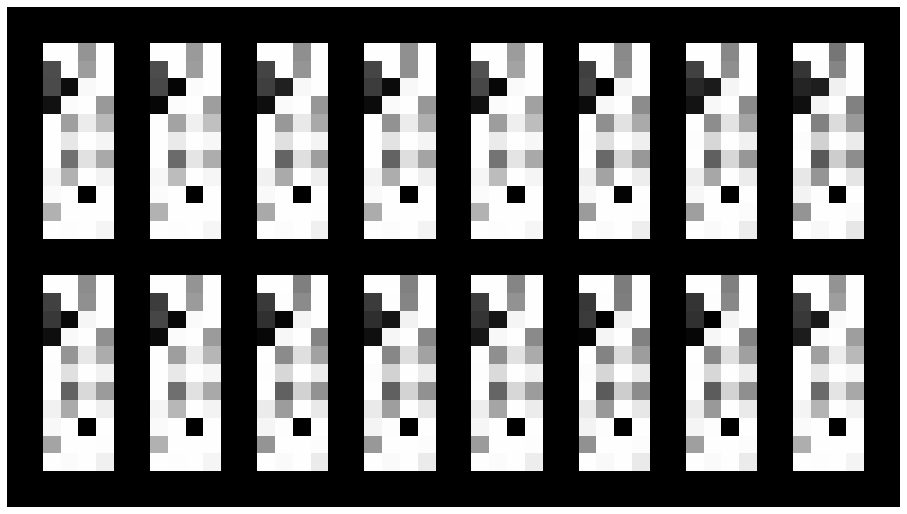

Epoch: [50/200], Batch Num: [0/12]
Discriminator Loss: 0.0002, Generator Loss: 9.3733
D(x): 1.0000, D(G(z)): 0.0002


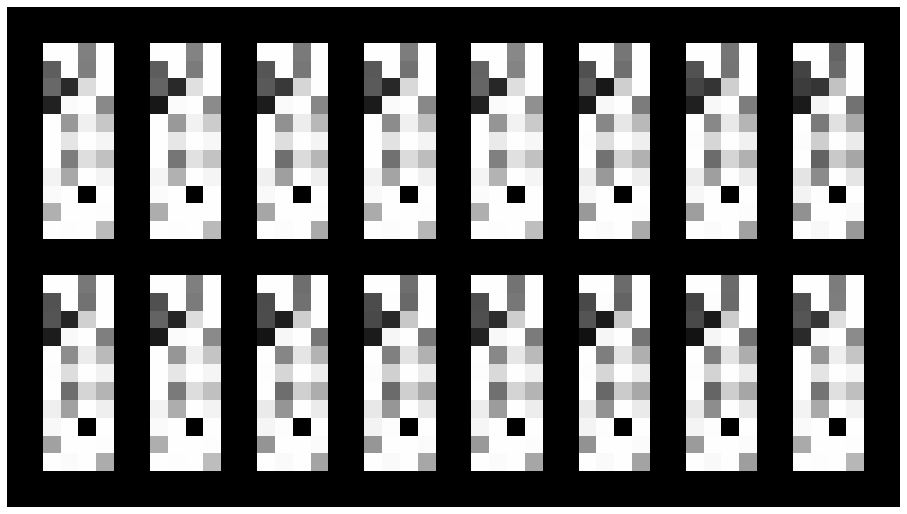

Epoch: [51/200], Batch Num: [0/12]
Discriminator Loss: 0.0003, Generator Loss: 8.8252
D(x): 1.0000, D(G(z)): 0.0003


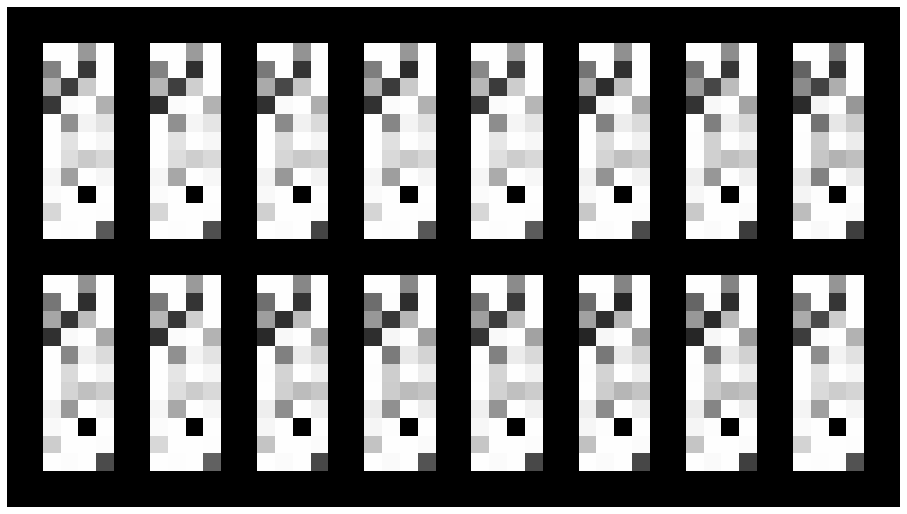

Epoch: [52/200], Batch Num: [0/12]
Discriminator Loss: 0.0004, Generator Loss: 8.5063
D(x): 1.0000, D(G(z)): 0.0004


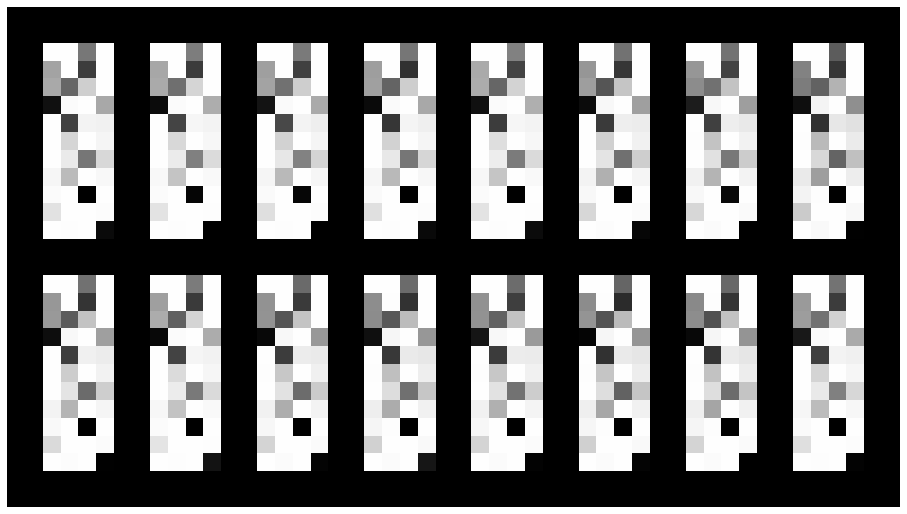

Epoch: [53/200], Batch Num: [0/12]
Discriminator Loss: 0.0002, Generator Loss: 9.4385
D(x): 1.0000, D(G(z)): 0.0002


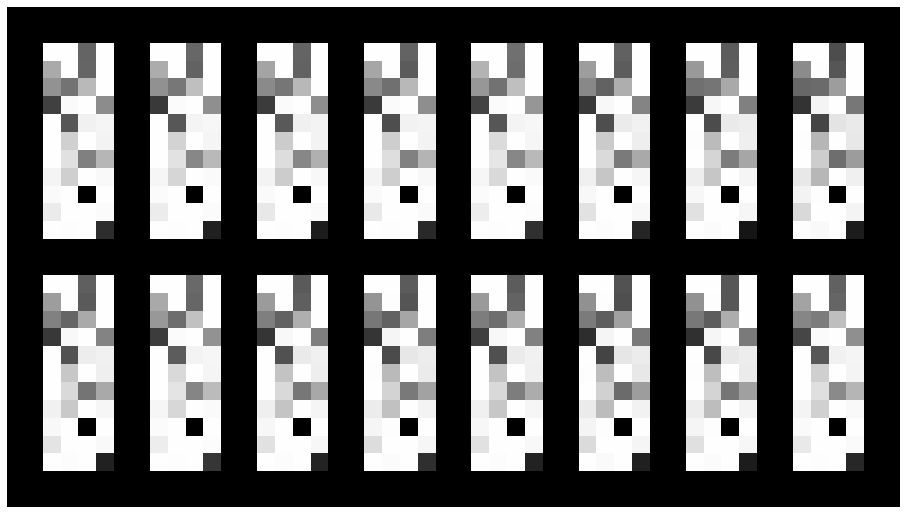

Epoch: [54/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 9.8099
D(x): 1.0000, D(G(z)): 0.0001


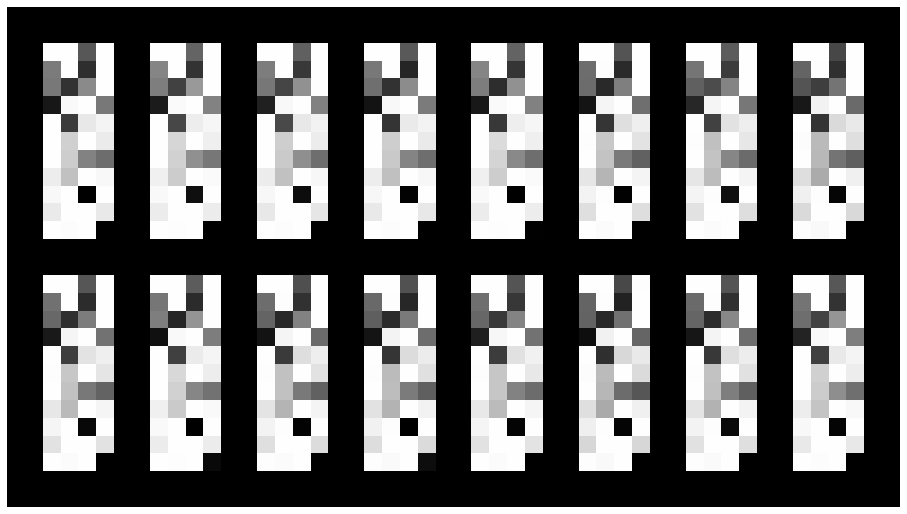

Epoch: [55/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 9.9015
D(x): 1.0000, D(G(z)): 0.0001


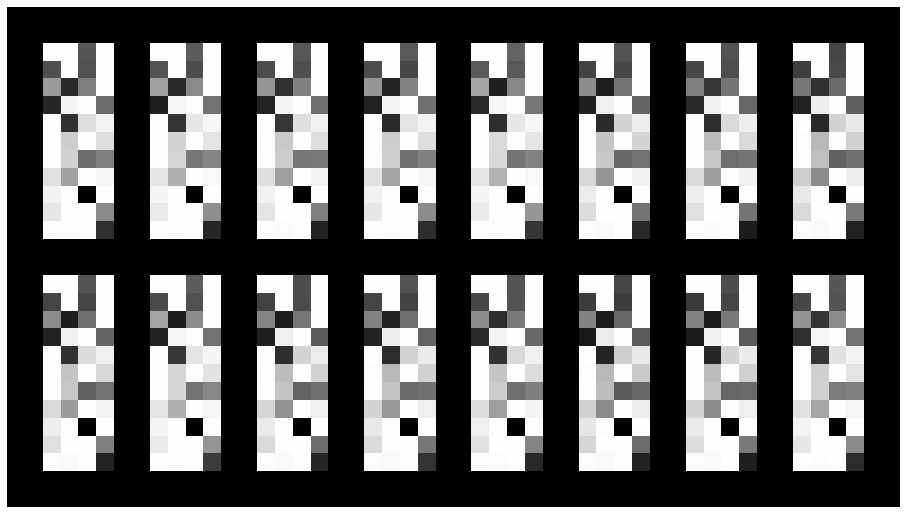

Epoch: [56/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 9.5064
D(x): 1.0000, D(G(z)): 0.0001


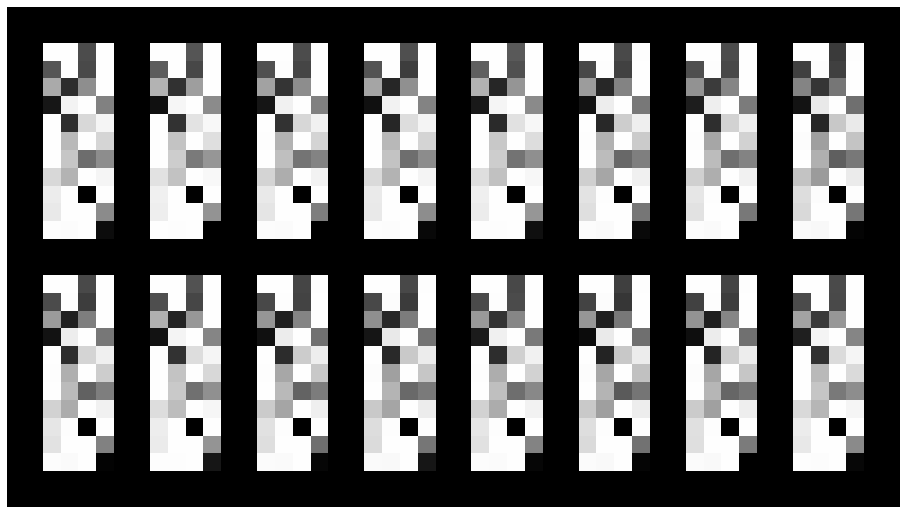

Epoch: [57/200], Batch Num: [0/12]
Discriminator Loss: 0.0002, Generator Loss: 9.5114
D(x): 1.0000, D(G(z)): 0.0001


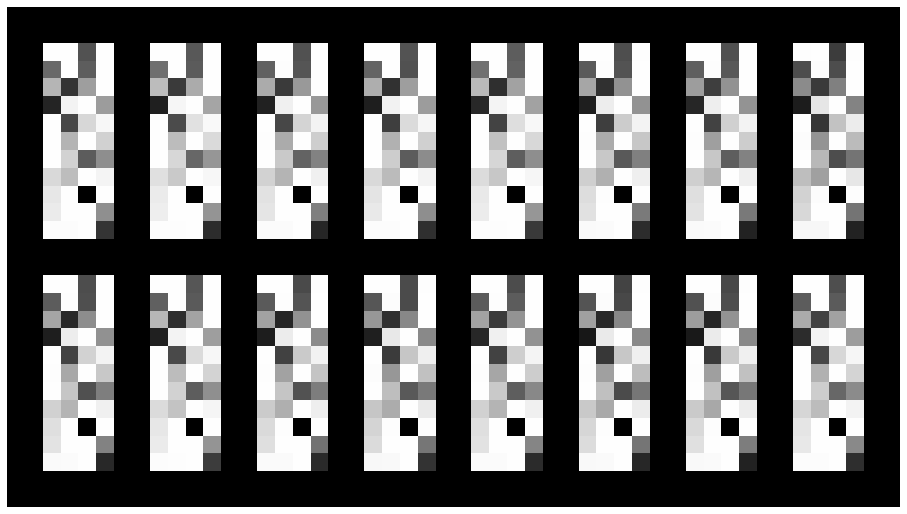

Epoch: [58/200], Batch Num: [0/12]
Discriminator Loss: 0.0003, Generator Loss: 9.1902
D(x): 0.9998, D(G(z)): 0.0002


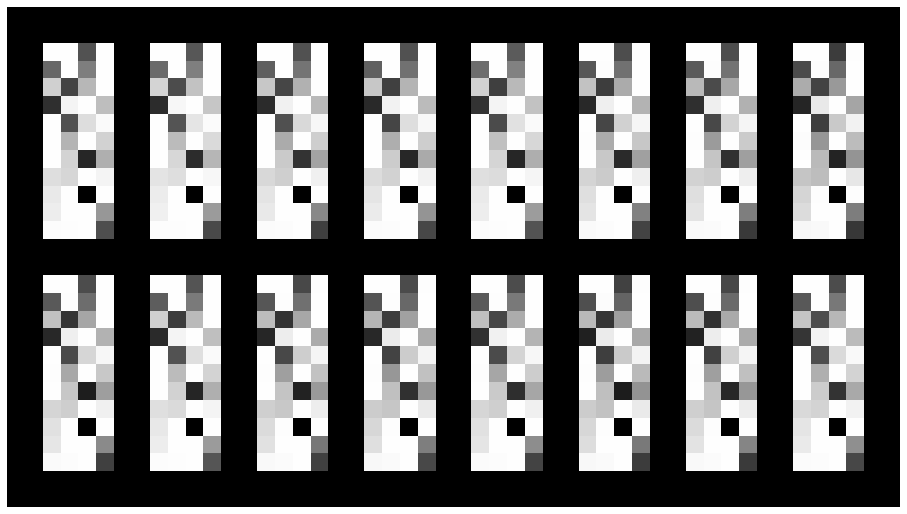

Epoch: [59/200], Batch Num: [0/12]
Discriminator Loss: 0.0002, Generator Loss: 9.2962
D(x): 1.0000, D(G(z)): 0.0002


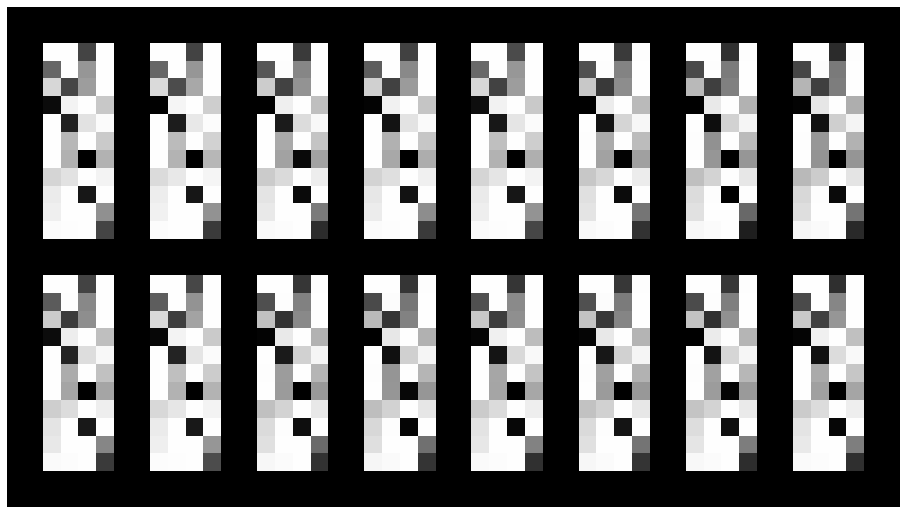

Epoch: [60/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 9.9157
D(x): 1.0000, D(G(z)): 0.0001


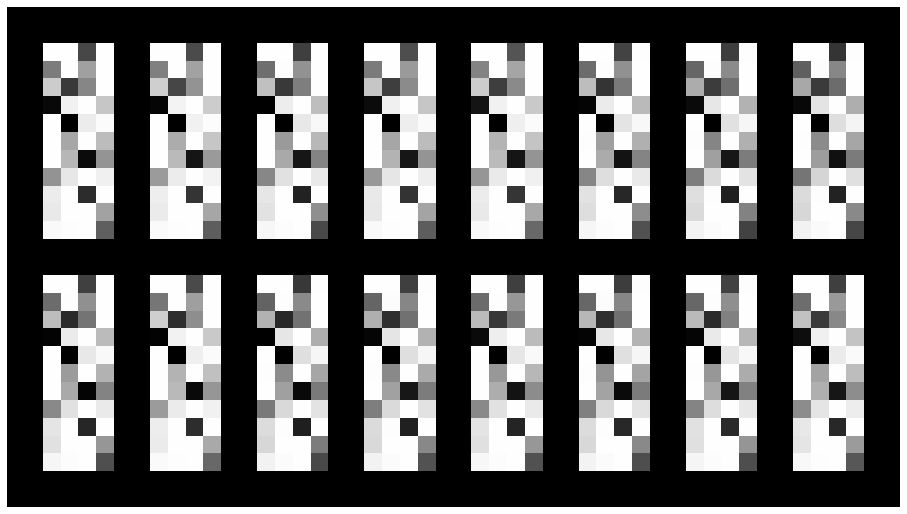

Epoch: [61/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.0141
D(x): 1.0000, D(G(z)): 0.0001


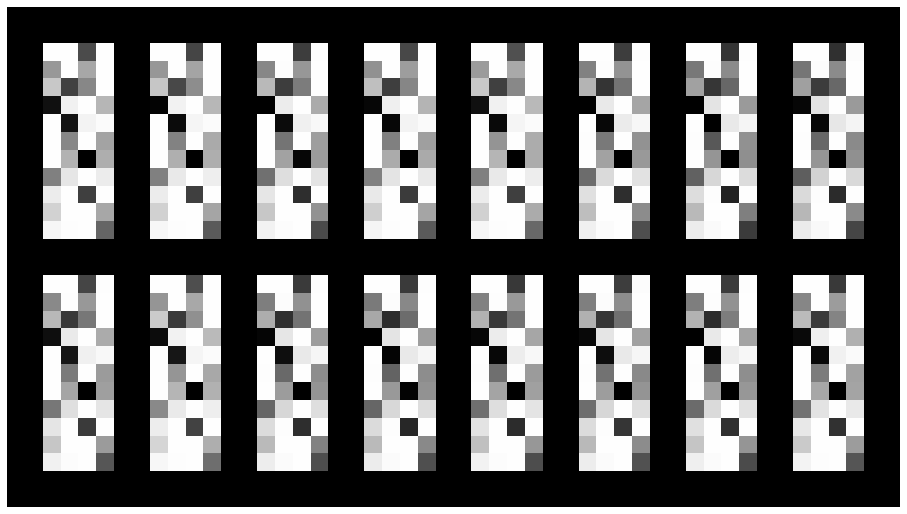

Epoch: [62/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.0252
D(x): 1.0000, D(G(z)): 0.0001


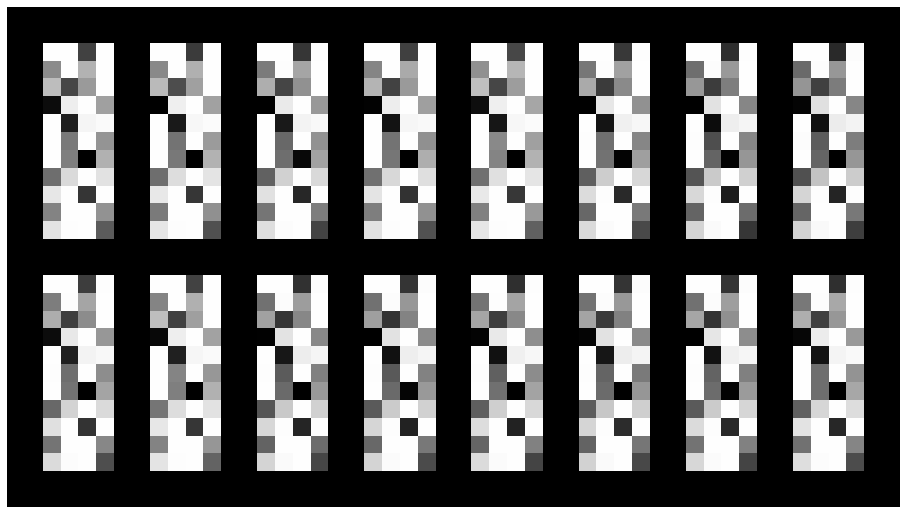

Epoch: [63/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 9.9645
D(x): 1.0000, D(G(z)): 0.0001


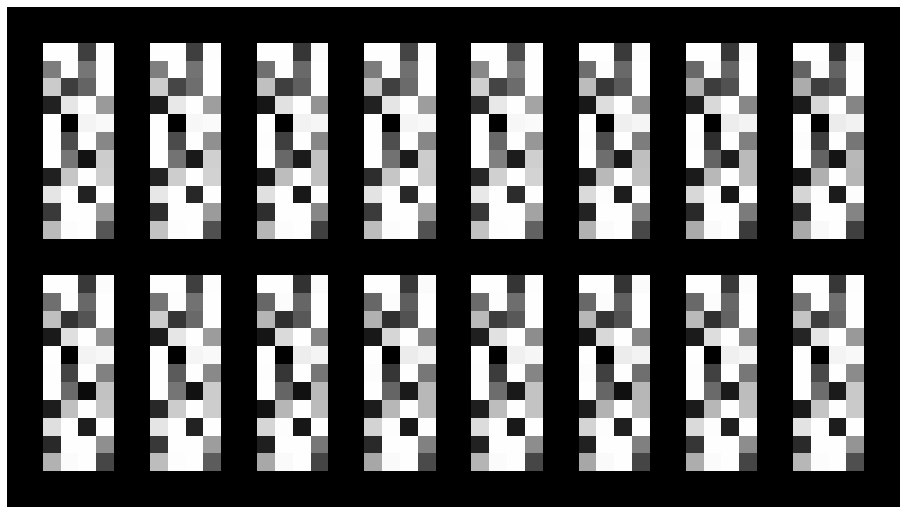

Epoch: [64/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 9.9845
D(x): 1.0000, D(G(z)): 0.0001


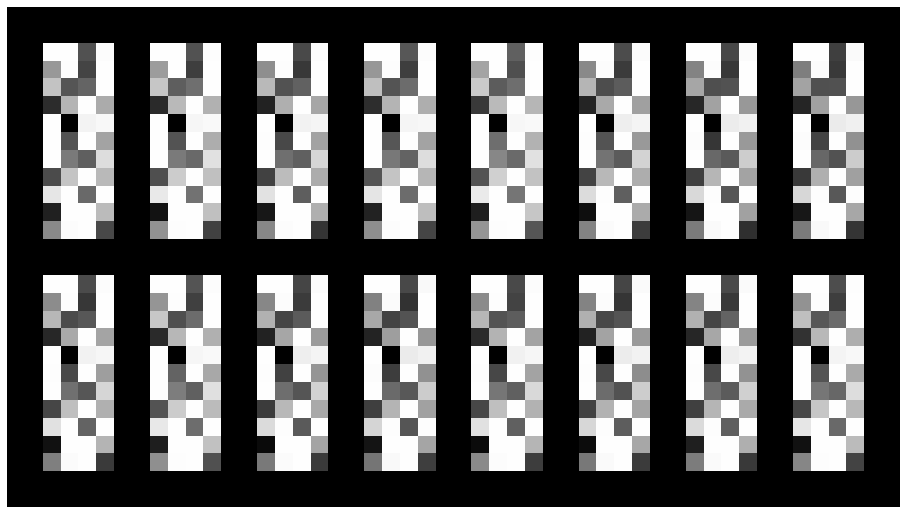

Epoch: [65/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.2248
D(x): 1.0000, D(G(z)): 0.0001


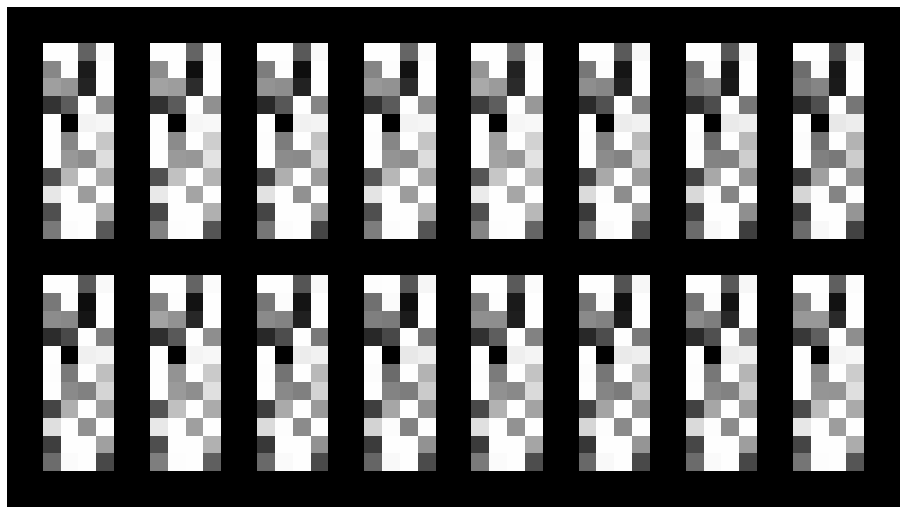

Epoch: [66/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.0968
D(x): 1.0000, D(G(z)): 0.0001


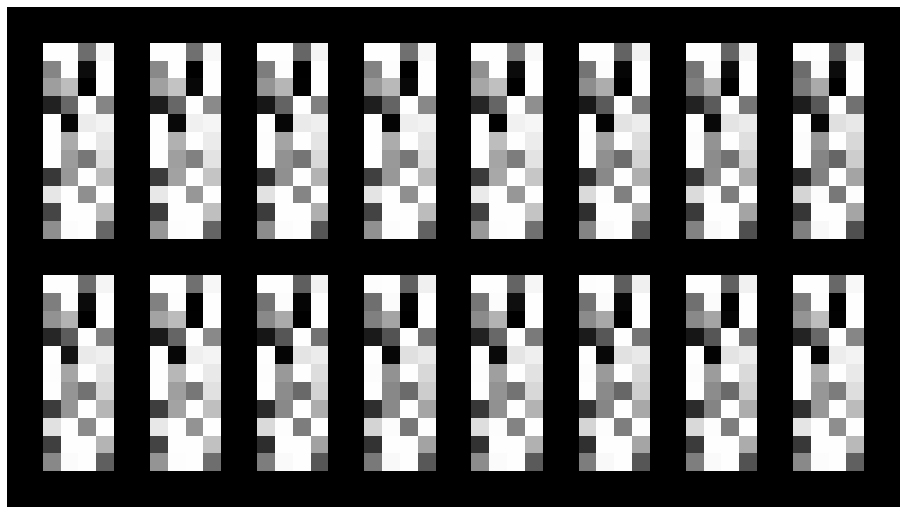

Epoch: [67/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 9.8850
D(x): 1.0000, D(G(z)): 0.0001


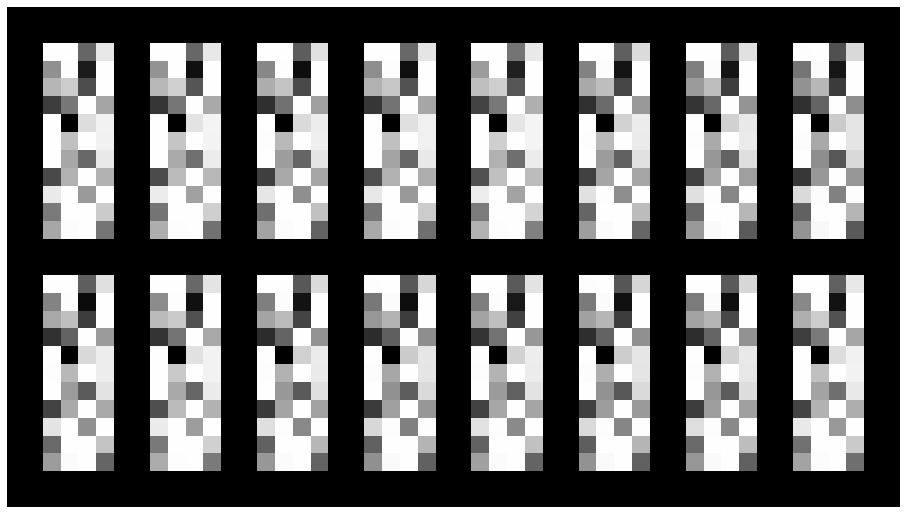

Epoch: [68/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 9.6183
D(x): 1.0000, D(G(z)): 0.0001


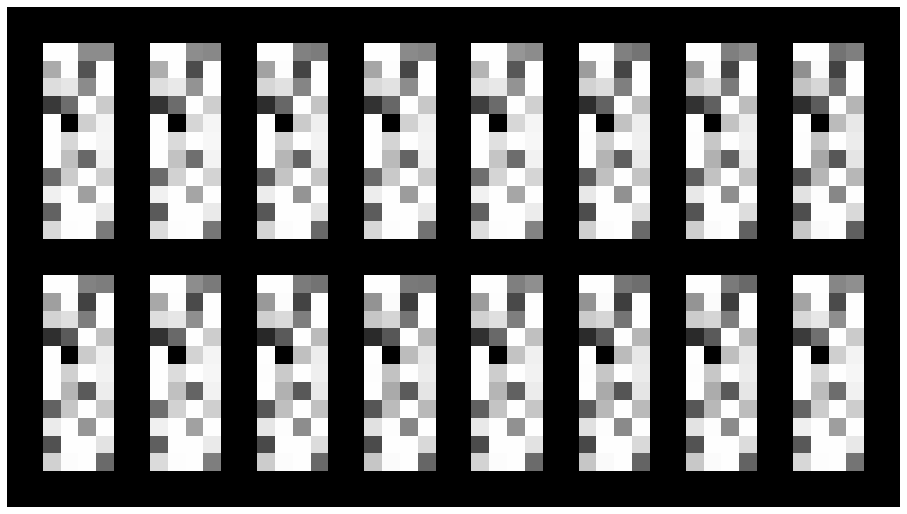

Epoch: [69/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 9.8012
D(x): 1.0000, D(G(z)): 0.0001


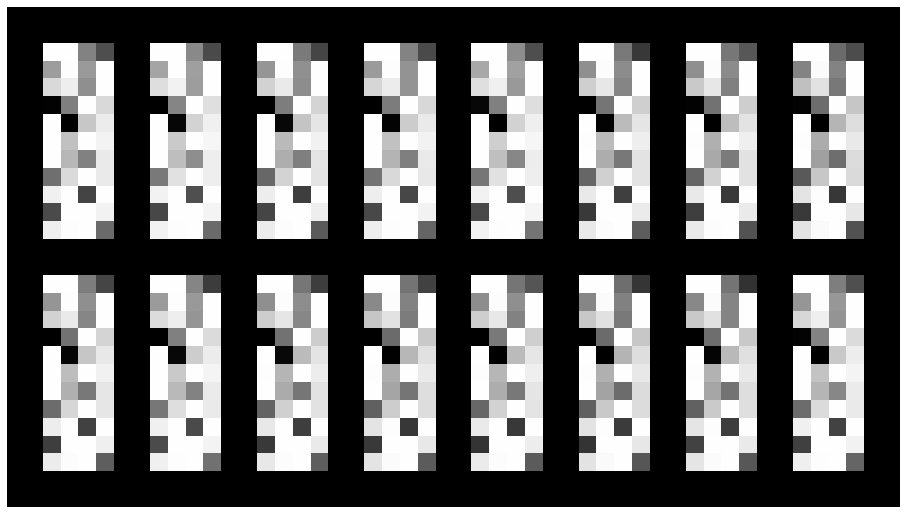

Epoch: [70/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.0234
D(x): 1.0000, D(G(z)): 0.0001


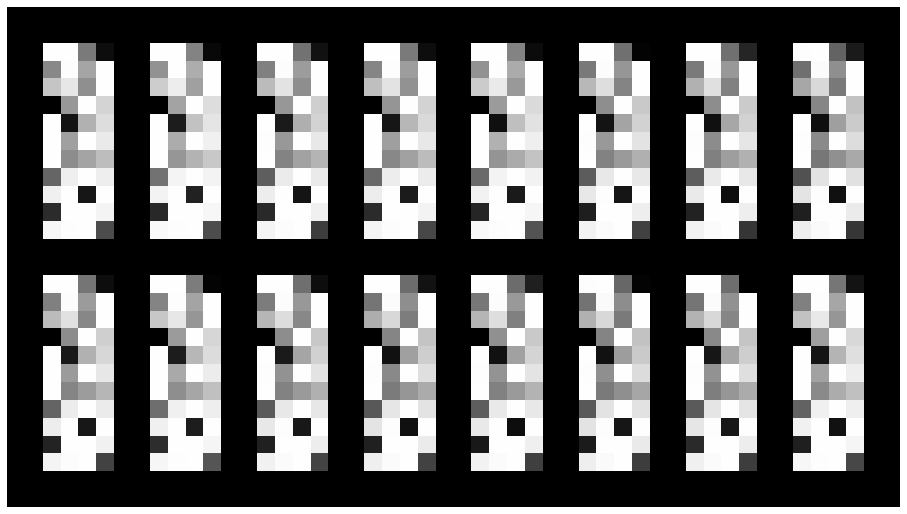

Epoch: [71/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 9.9692
D(x): 1.0000, D(G(z)): 0.0001


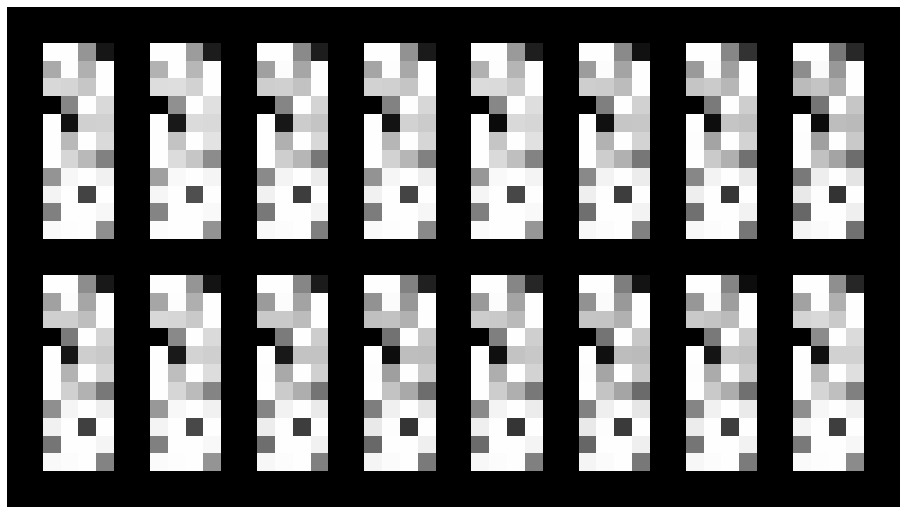

Epoch: [72/200], Batch Num: [0/12]
Discriminator Loss: 0.0002, Generator Loss: 9.3875
D(x): 1.0000, D(G(z)): 0.0002


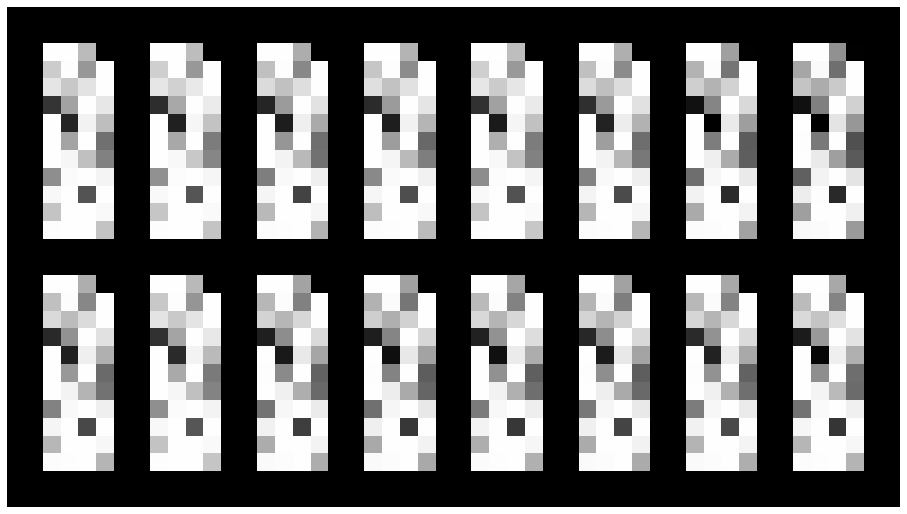

Epoch: [73/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 9.7332
D(x): 1.0000, D(G(z)): 0.0001


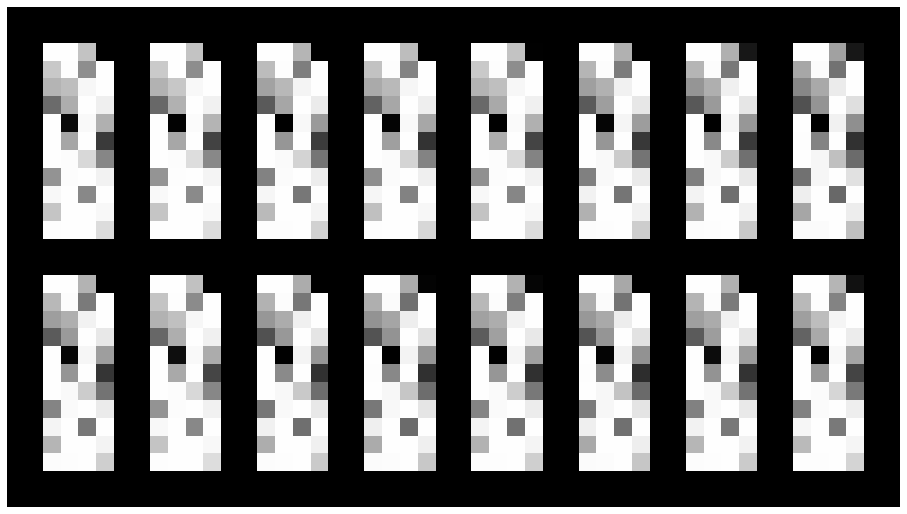

Epoch: [74/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.1805
D(x): 1.0000, D(G(z)): 0.0001


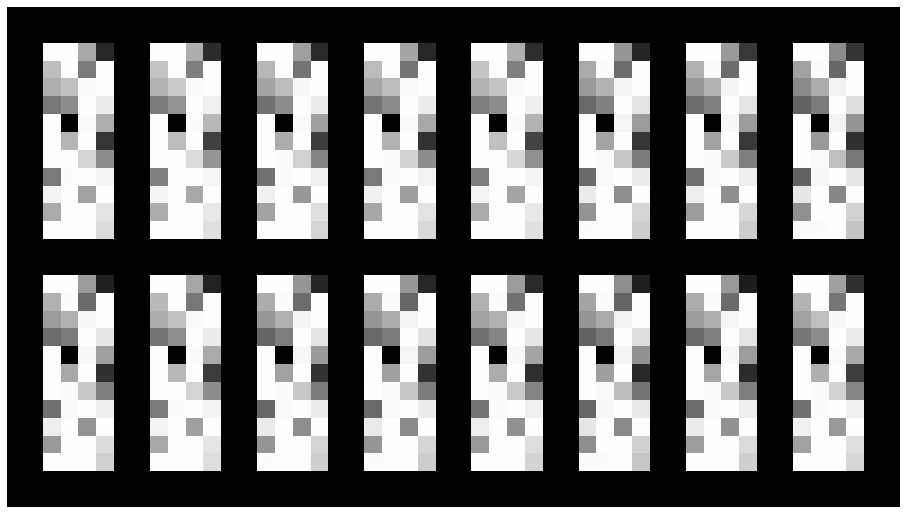

Epoch: [75/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.2968
D(x): 1.0000, D(G(z)): 0.0001


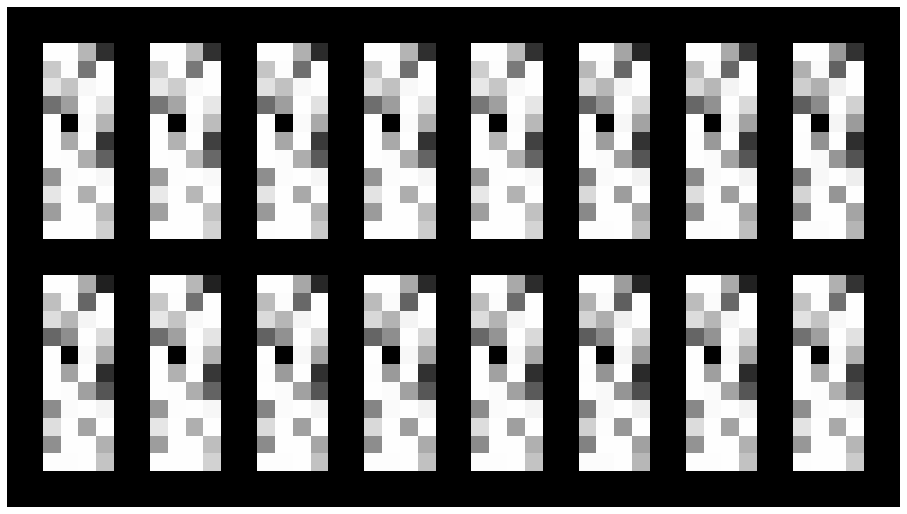

Epoch: [76/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.3689
D(x): 1.0000, D(G(z)): 0.0001


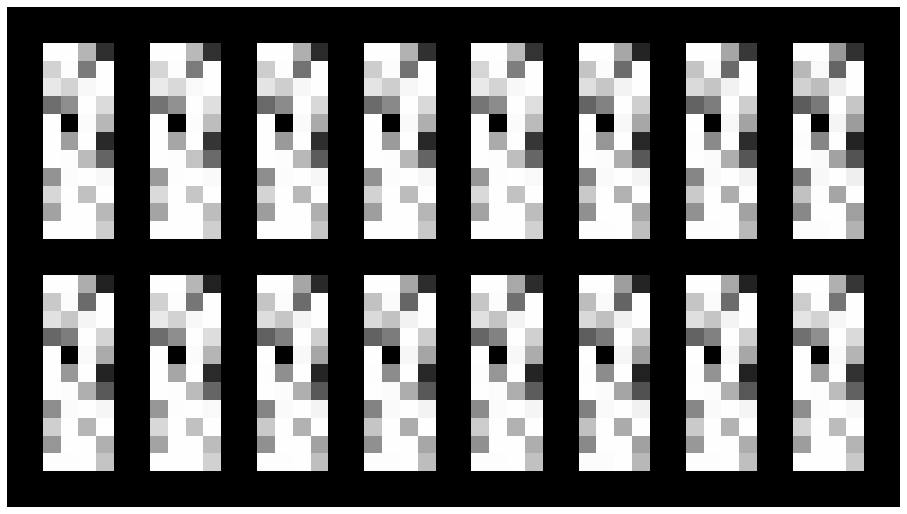

Epoch: [77/200], Batch Num: [0/12]
Discriminator Loss: 0.0003, Generator Loss: 10.0214
D(x): 0.9998, D(G(z)): 0.0001


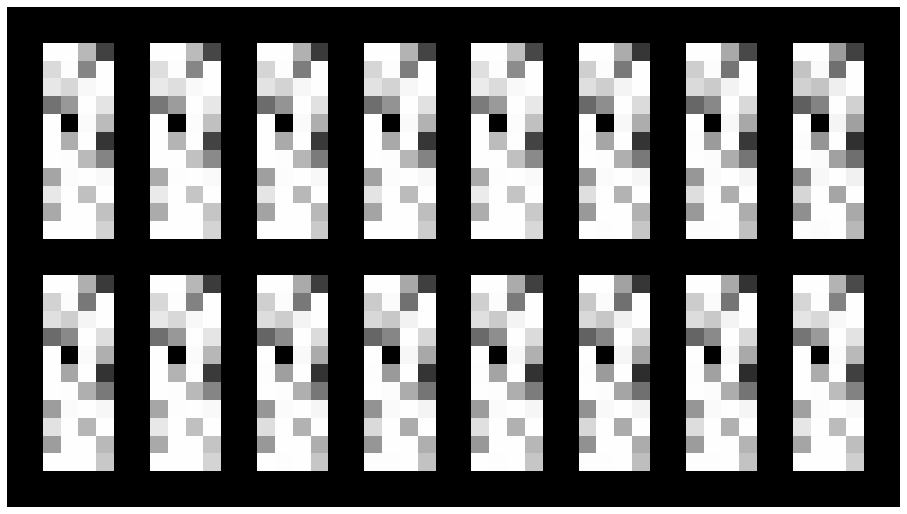

Epoch: [78/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 9.9699
D(x): 1.0000, D(G(z)): 0.0001


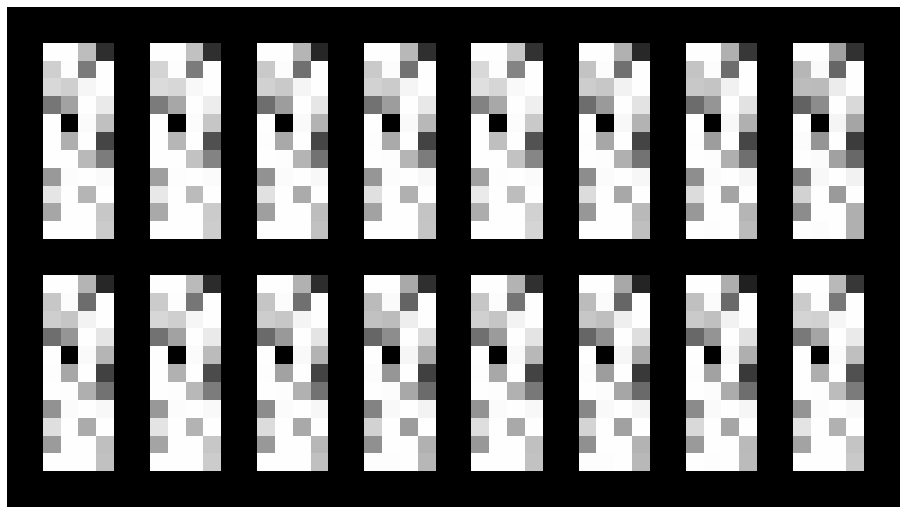

Epoch: [79/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.0333
D(x): 1.0000, D(G(z)): 0.0001


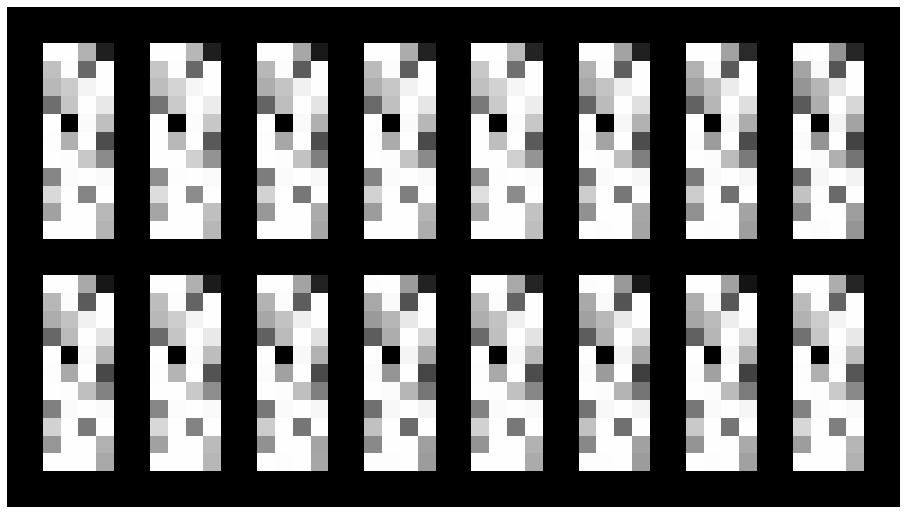

Epoch: [80/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.3020
D(x): 1.0000, D(G(z)): 0.0001


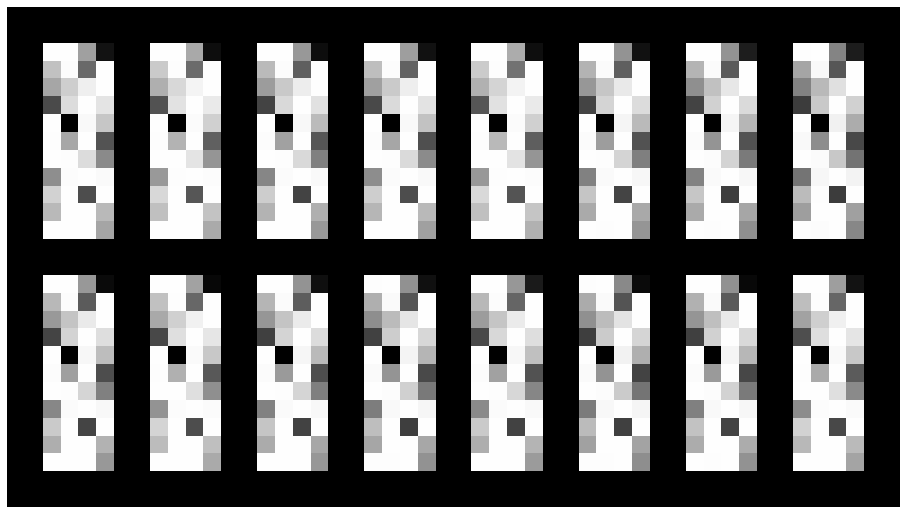

Epoch: [81/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.1741
D(x): 1.0000, D(G(z)): 0.0001


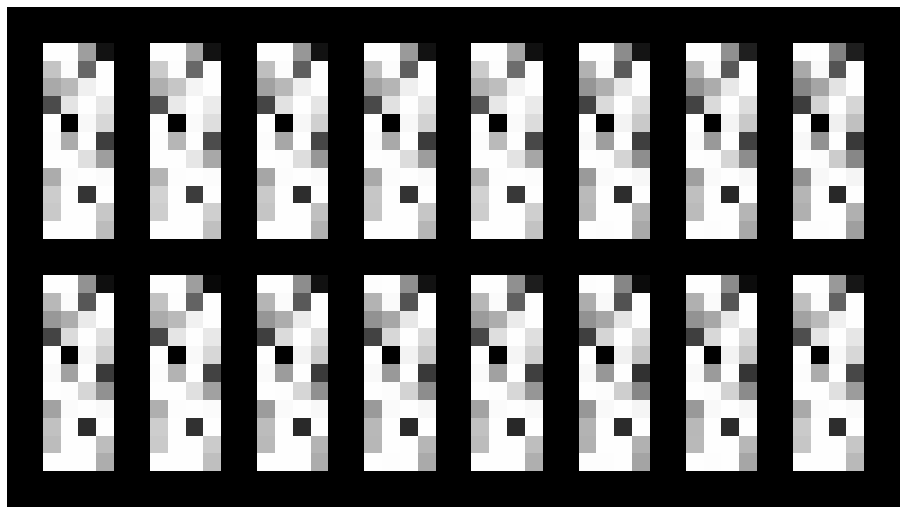

Epoch: [82/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.1612
D(x): 1.0000, D(G(z)): 0.0001


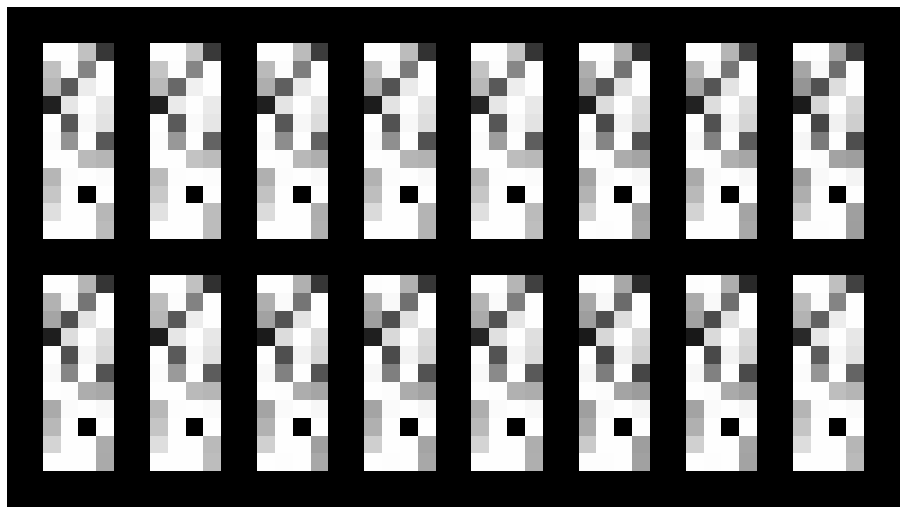

Epoch: [83/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.5432
D(x): 1.0000, D(G(z)): 0.0001


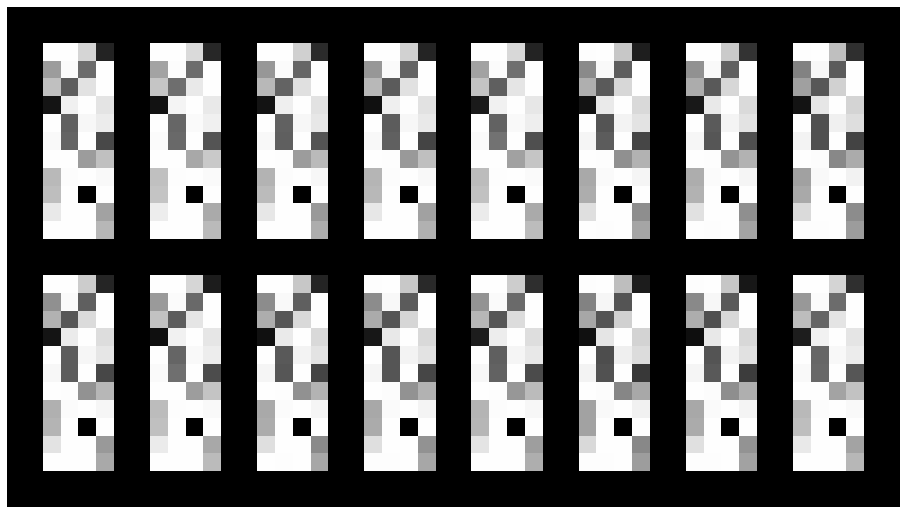

Epoch: [84/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.3167
D(x): 1.0000, D(G(z)): 0.0001


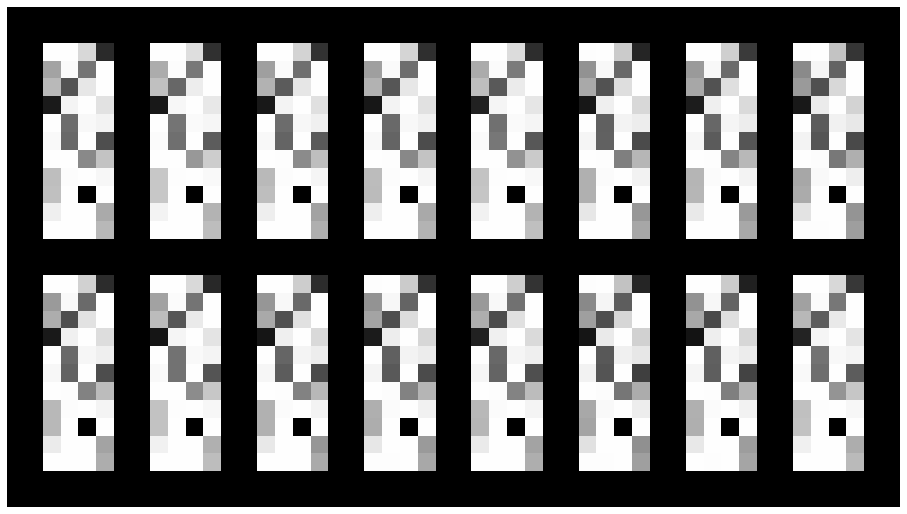

Epoch: [85/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.2622
D(x): 1.0000, D(G(z)): 0.0001


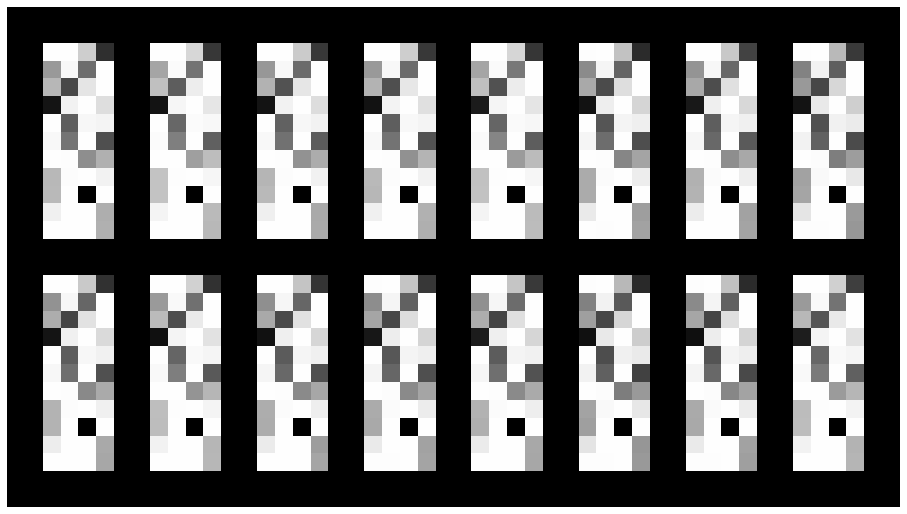

Epoch: [86/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.3453
D(x): 1.0000, D(G(z)): 0.0001


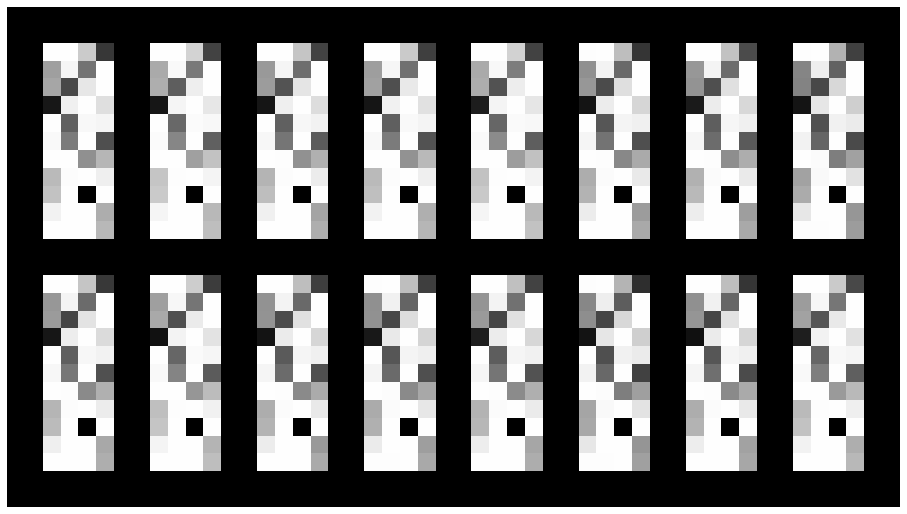

Epoch: [87/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.3150
D(x): 1.0000, D(G(z)): 0.0001


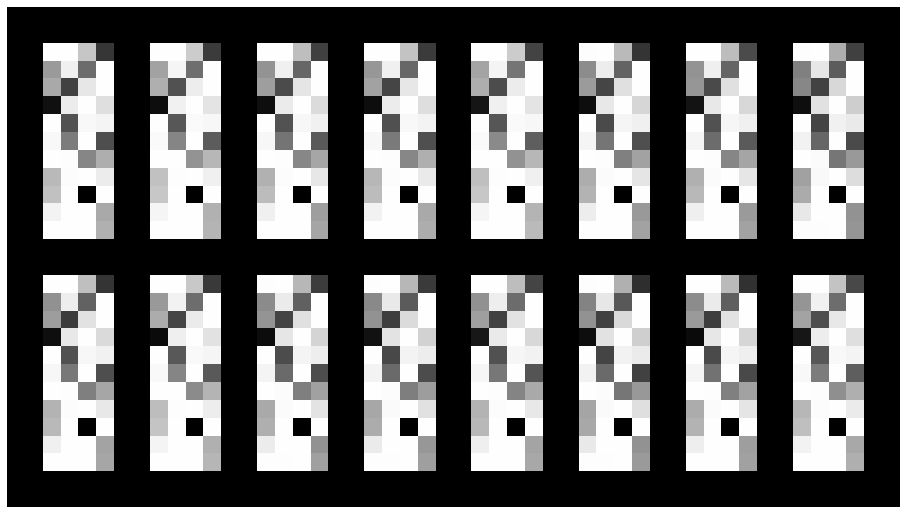

Epoch: [88/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.1422
D(x): 1.0000, D(G(z)): 0.0001


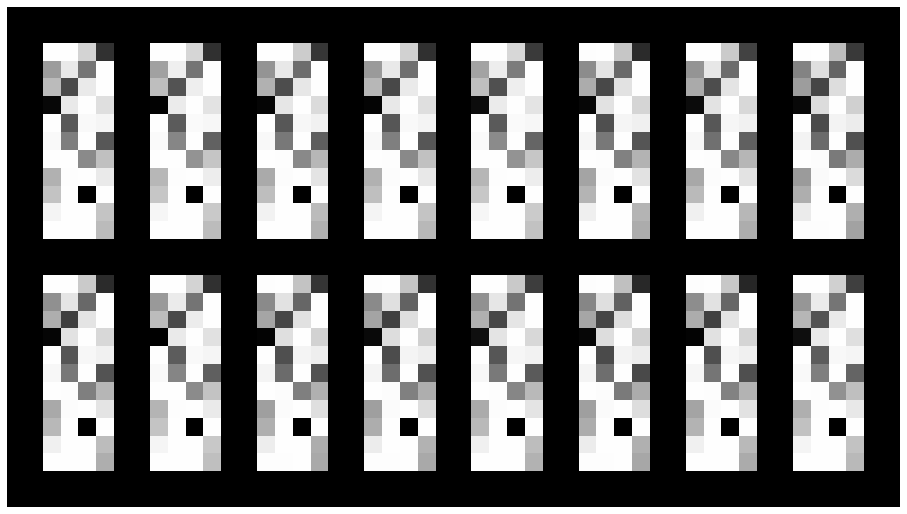

Epoch: [89/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.2034
D(x): 1.0000, D(G(z)): 0.0001


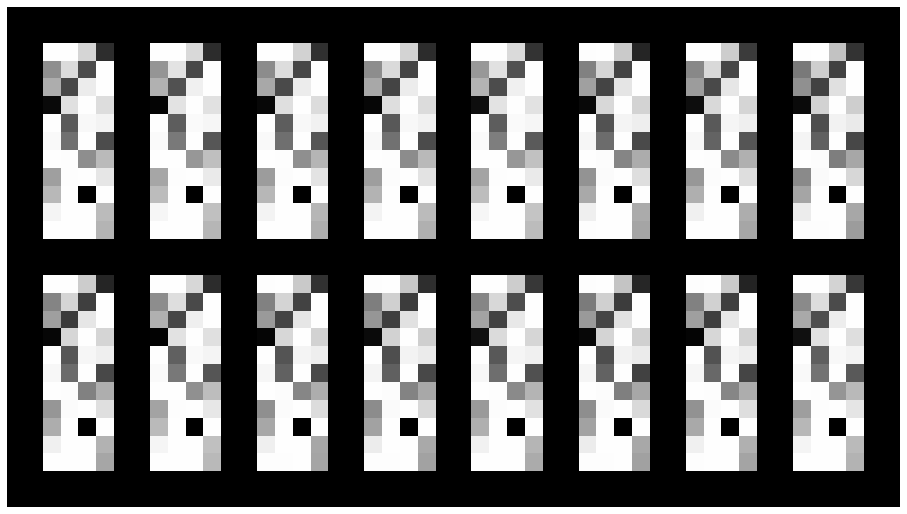

Epoch: [90/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.4770
D(x): 1.0000, D(G(z)): 0.0001


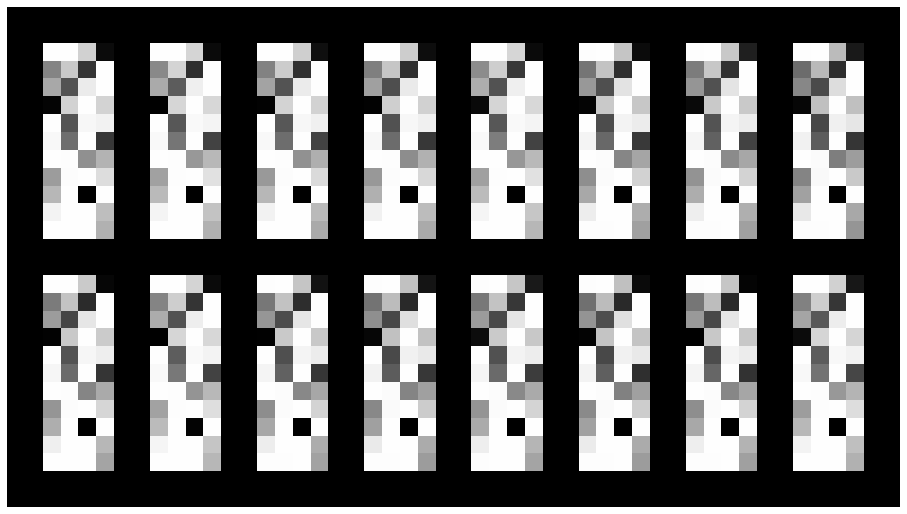

Epoch: [91/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.5917
D(x): 1.0000, D(G(z)): 0.0001


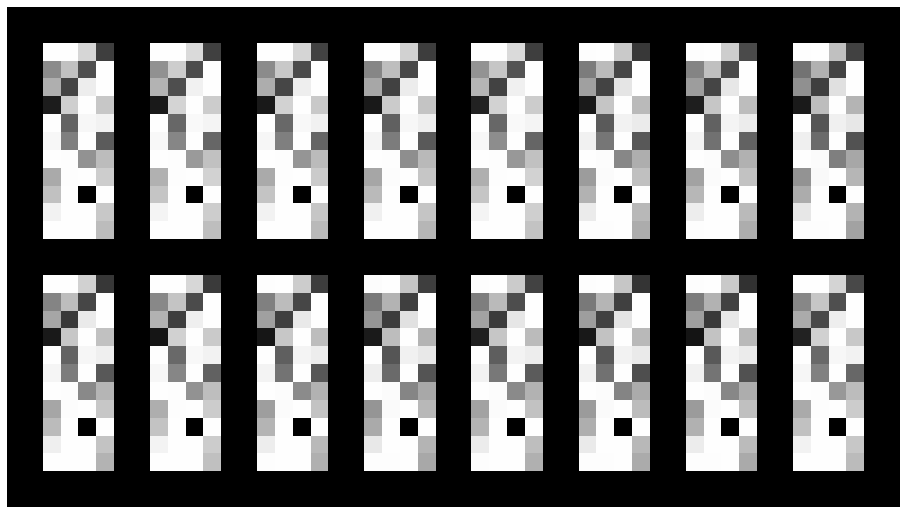

Epoch: [92/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.1203
D(x): 1.0000, D(G(z)): 0.0001


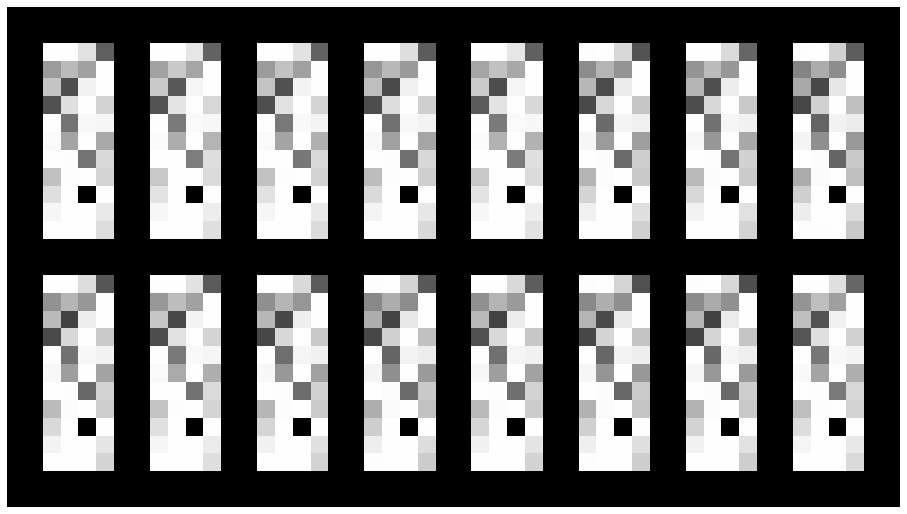

Epoch: [93/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.0540
D(x): 1.0000, D(G(z)): 0.0001


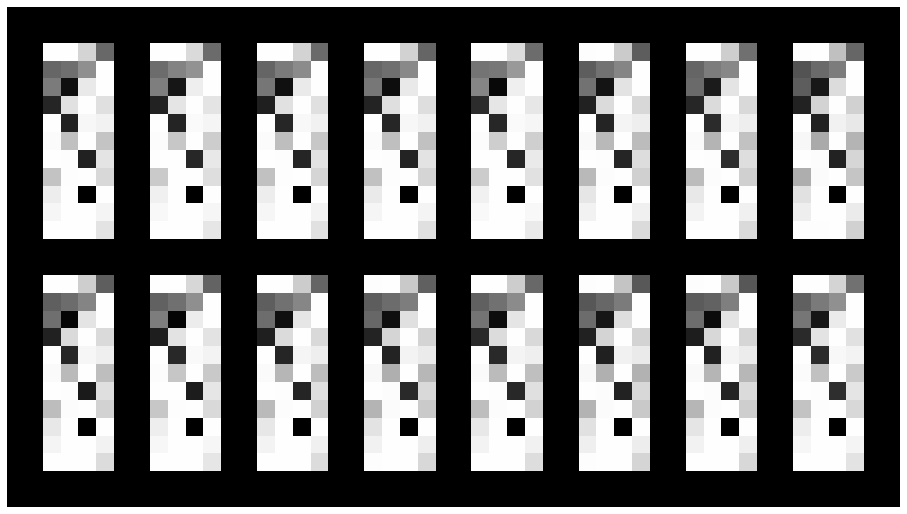

Epoch: [94/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.5051
D(x): 1.0000, D(G(z)): 0.0001


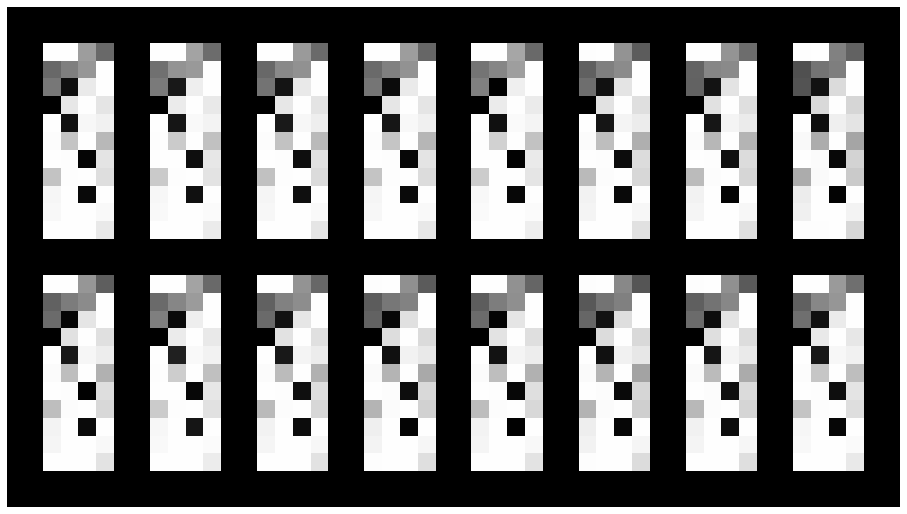

Epoch: [95/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.5768
D(x): 1.0000, D(G(z)): 0.0001


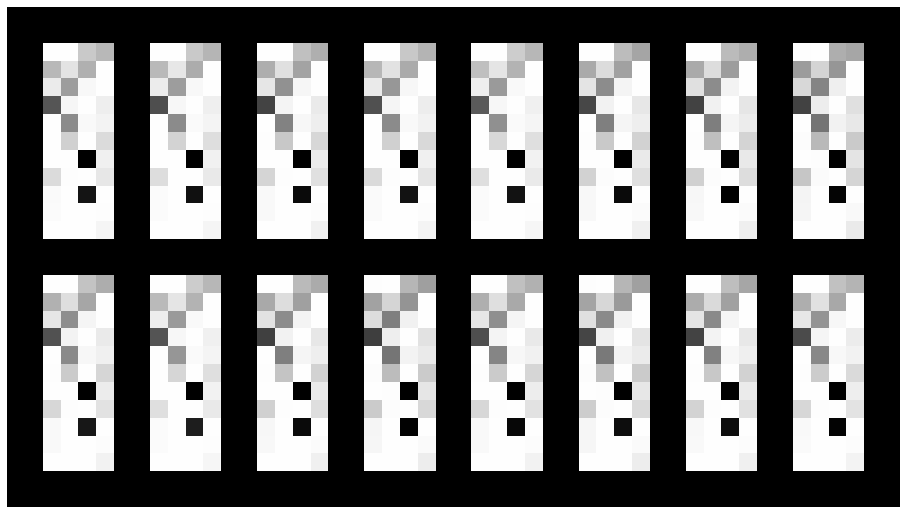

Epoch: [96/200], Batch Num: [0/12]
Discriminator Loss: 0.0003, Generator Loss: 9.7047
D(x): 1.0000, D(G(z)): 0.0003


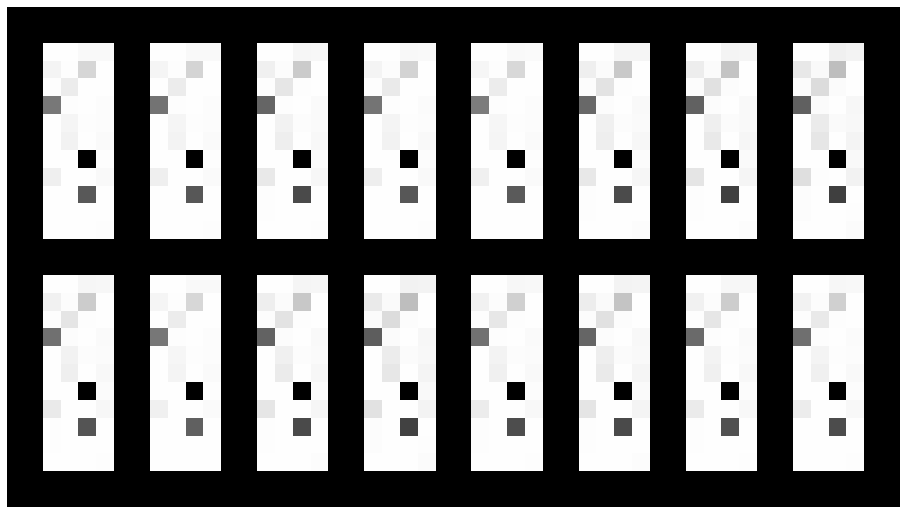

Epoch: [97/200], Batch Num: [0/12]
Discriminator Loss: 0.0034, Generator Loss: 11.3529
D(x): 0.9981, D(G(z)): 0.0000


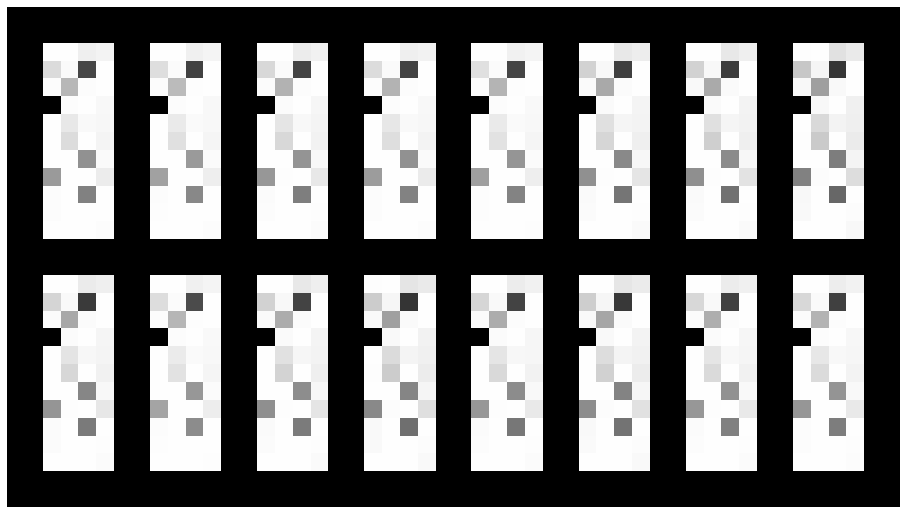

Epoch: [98/200], Batch Num: [0/12]
Discriminator Loss: 0.0011, Generator Loss: 8.4428
D(x): 1.0000, D(G(z)): 0.0011


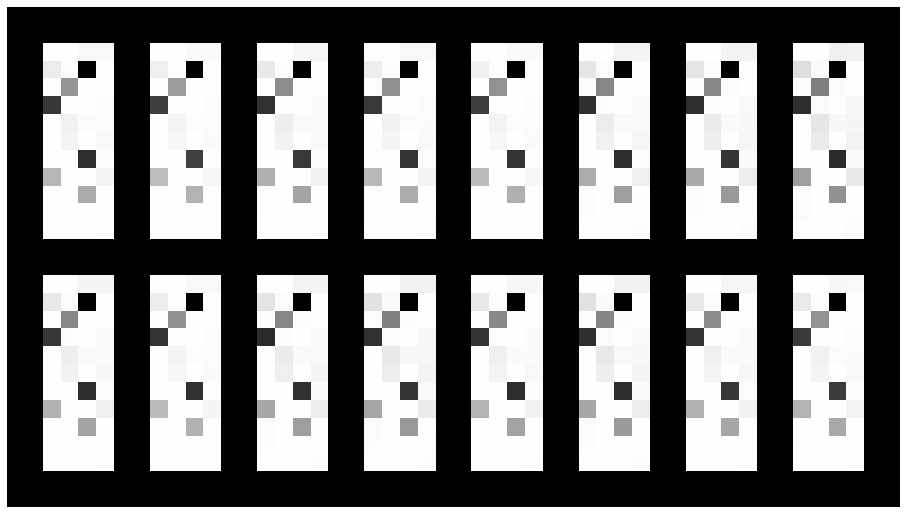

Epoch: [99/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.5476
D(x): 1.0000, D(G(z)): 0.0000


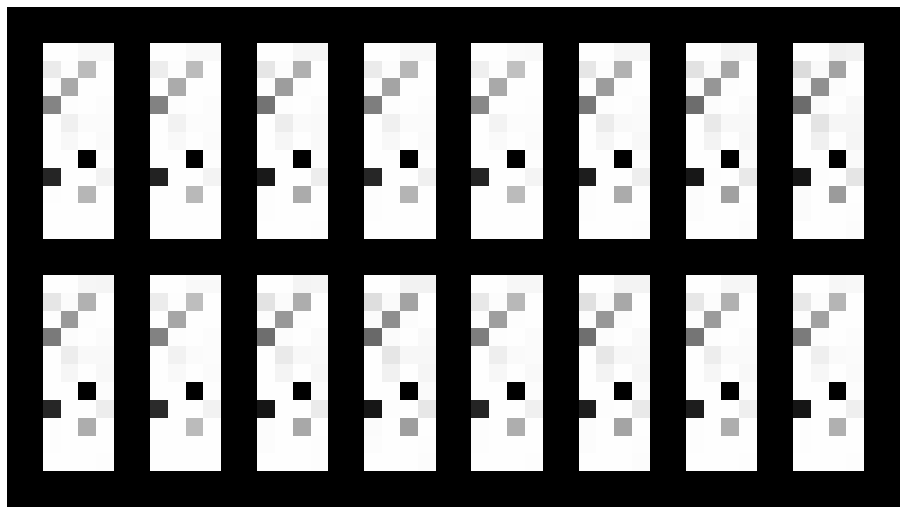

Epoch: [100/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.5646
D(x): 1.0000, D(G(z)): 0.0000


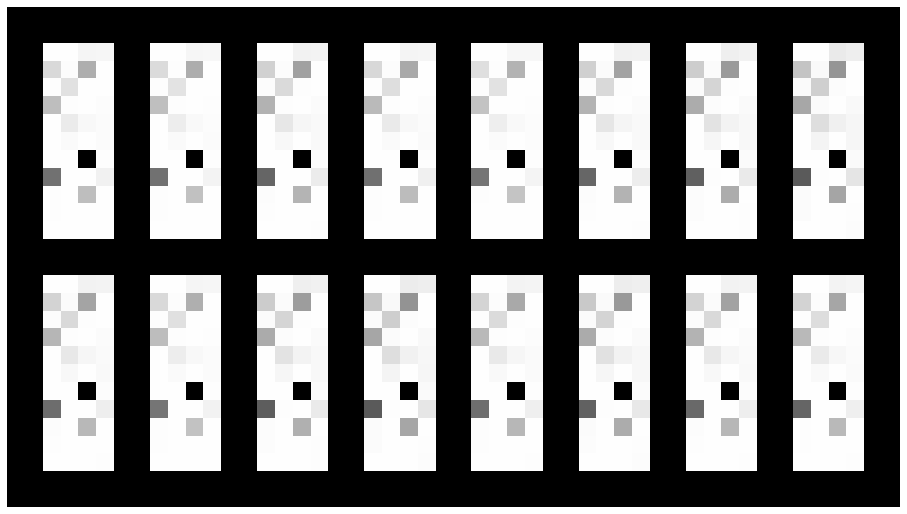

Epoch: [101/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.6563
D(x): 1.0000, D(G(z)): 0.0001


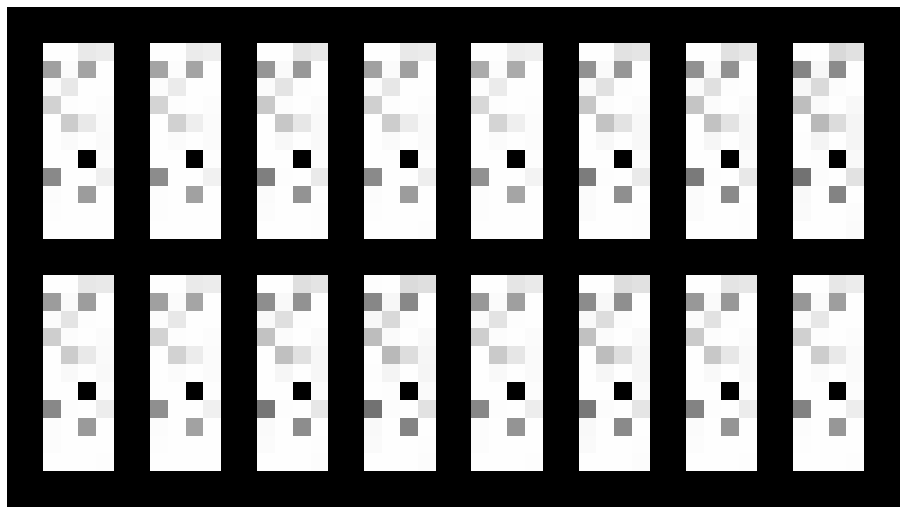

Epoch: [102/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.6960
D(x): 1.0000, D(G(z)): 0.0001


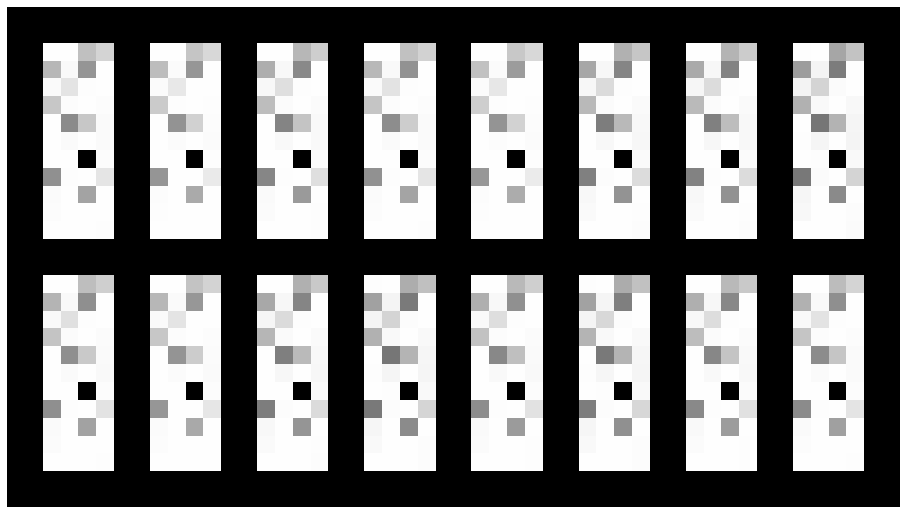

Epoch: [103/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 10.7846
D(x): 1.0000, D(G(z)): 0.0000


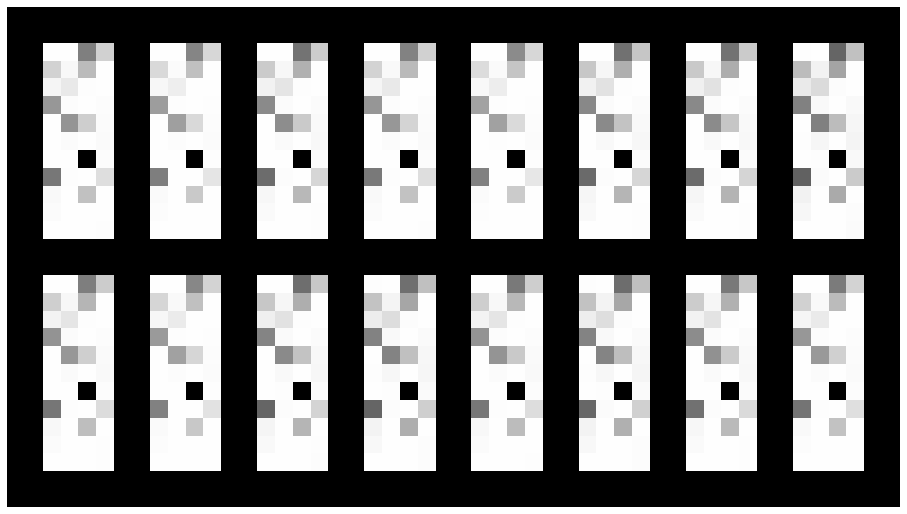

Epoch: [104/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.1702
D(x): 1.0000, D(G(z)): 0.0000


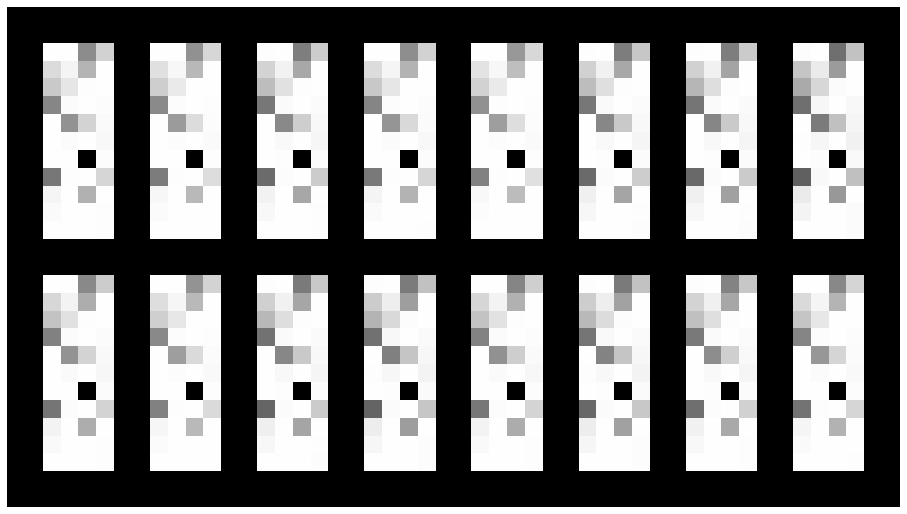

Epoch: [105/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.1321
D(x): 1.0000, D(G(z)): 0.0001


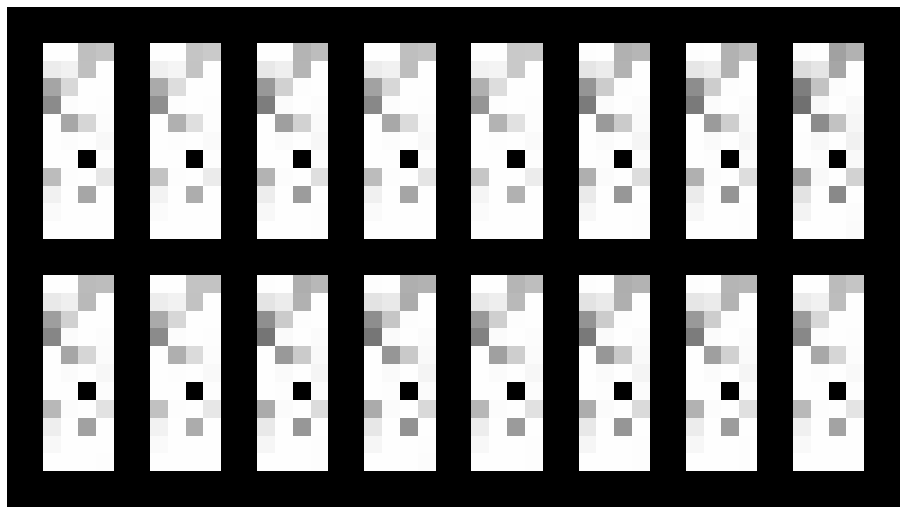

Epoch: [106/200], Batch Num: [0/12]
Discriminator Loss: 0.0003, Generator Loss: 9.0768
D(x): 1.0000, D(G(z)): 0.0003


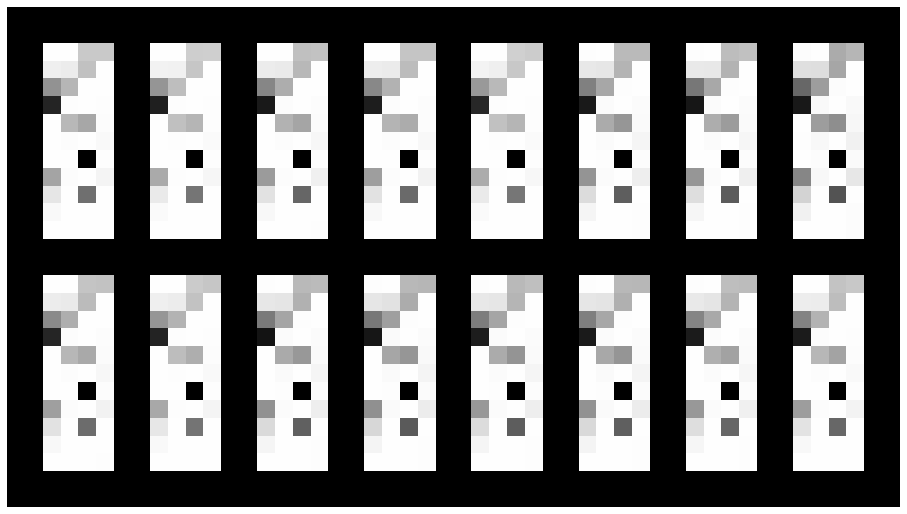

Epoch: [107/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 9.9682
D(x): 1.0000, D(G(z)): 0.0001


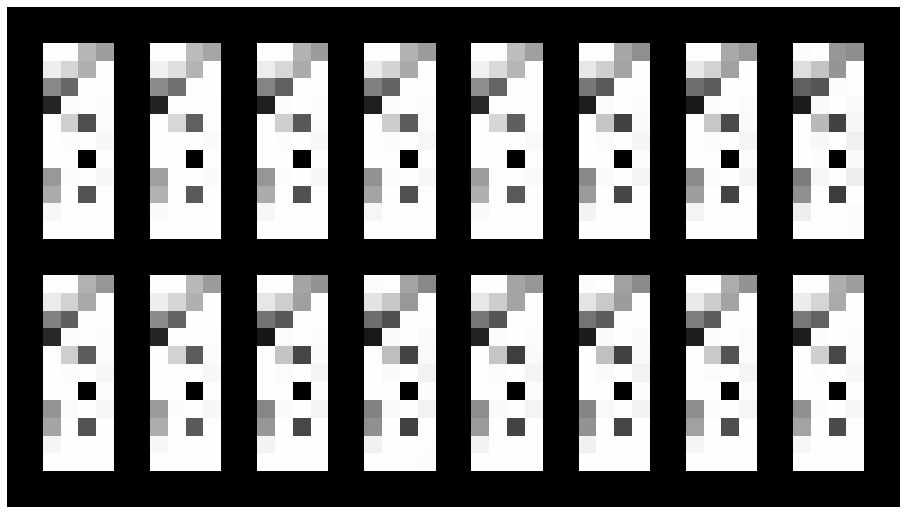

Epoch: [108/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 10.9137
D(x): 1.0000, D(G(z)): 0.0000


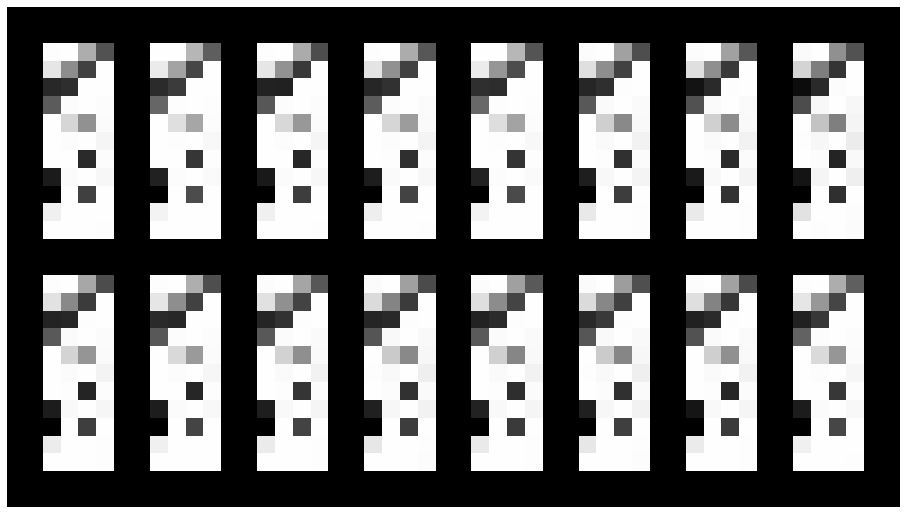

Epoch: [109/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.1840
D(x): 1.0000, D(G(z)): 0.0000


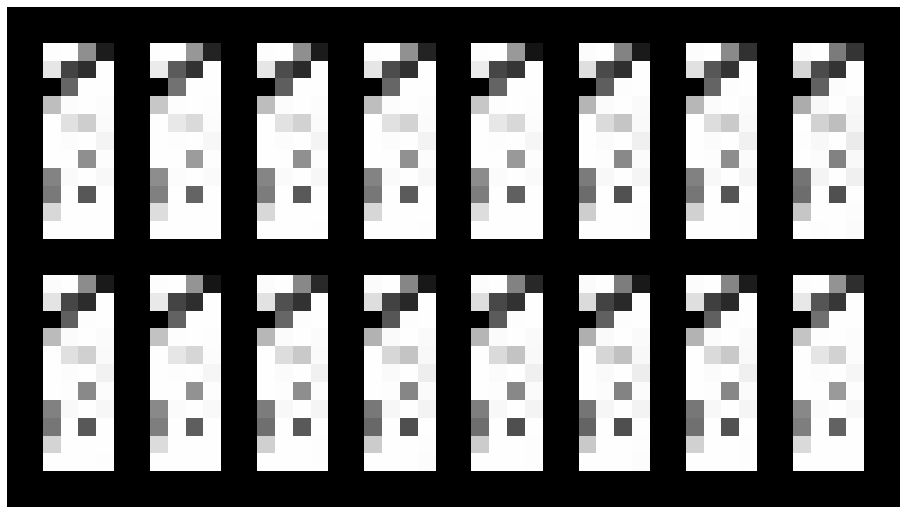

Epoch: [110/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.2000
D(x): 1.0000, D(G(z)): 0.0000


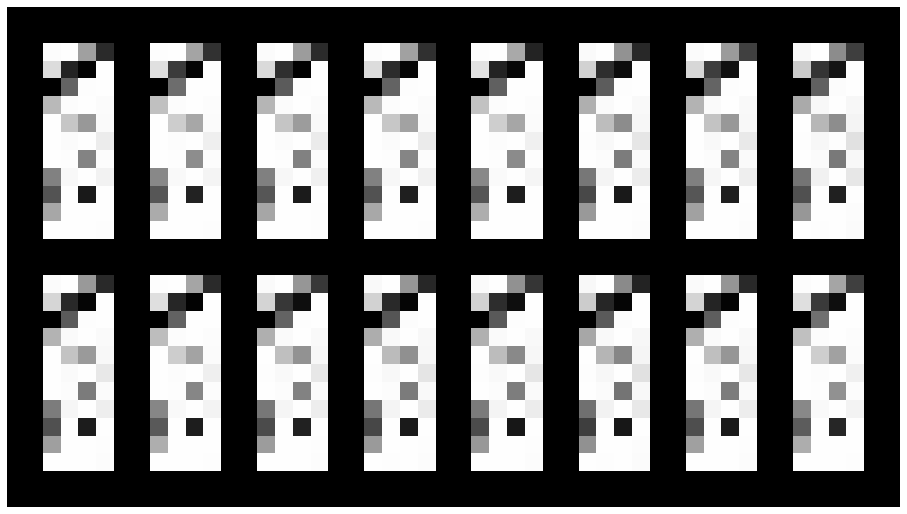

Epoch: [111/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.1691
D(x): 1.0000, D(G(z)): 0.0000


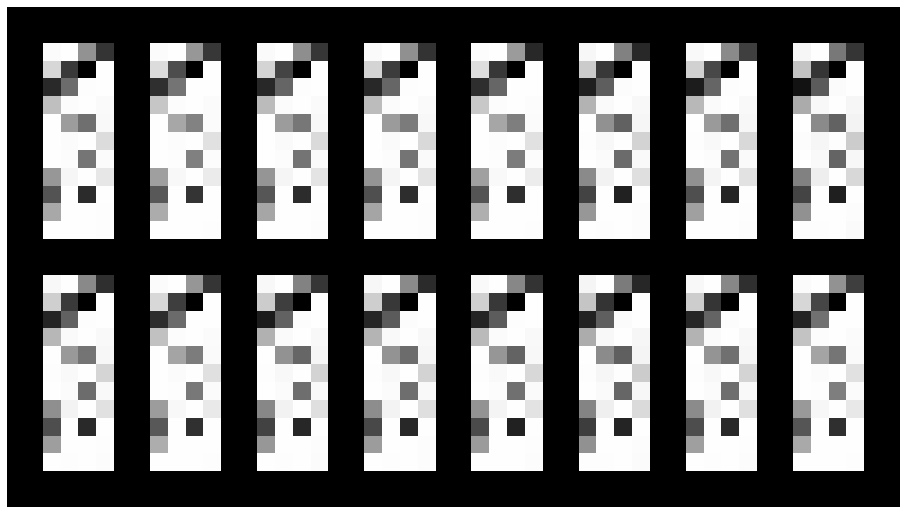

Epoch: [112/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.3040
D(x): 1.0000, D(G(z)): 0.0000


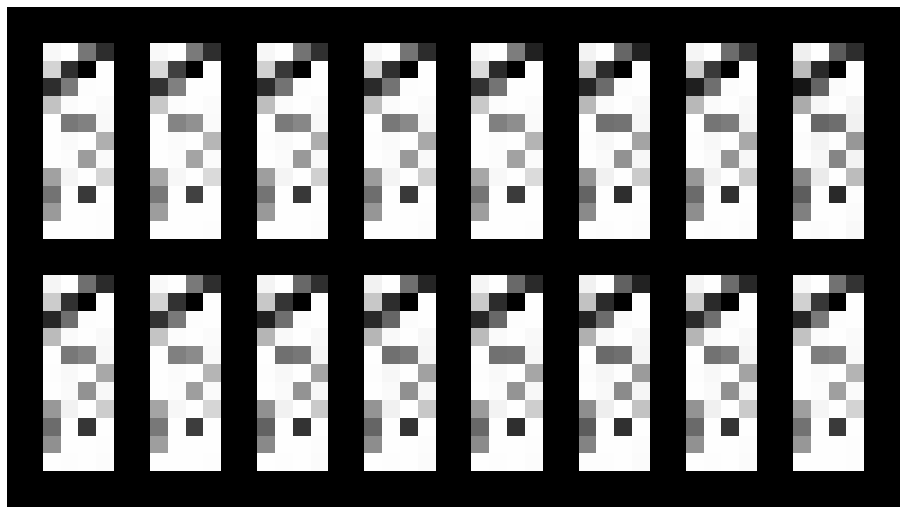

Epoch: [113/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.4460
D(x): 1.0000, D(G(z)): 0.0000


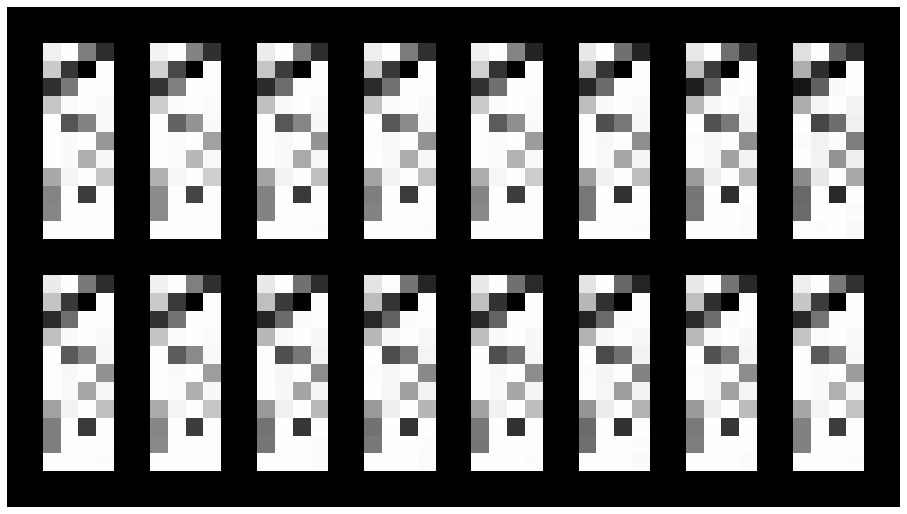

Epoch: [114/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.5304
D(x): 1.0000, D(G(z)): 0.0000


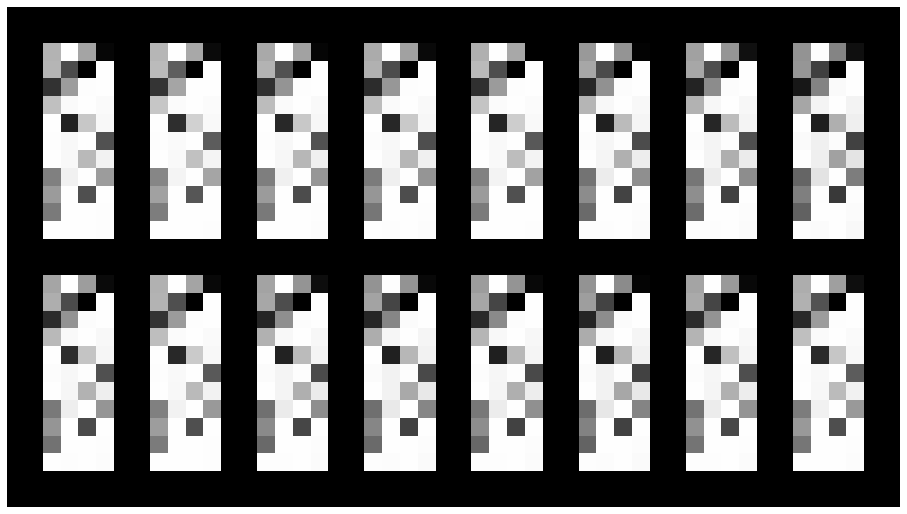

Epoch: [115/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.2942
D(x): 1.0000, D(G(z)): 0.0000


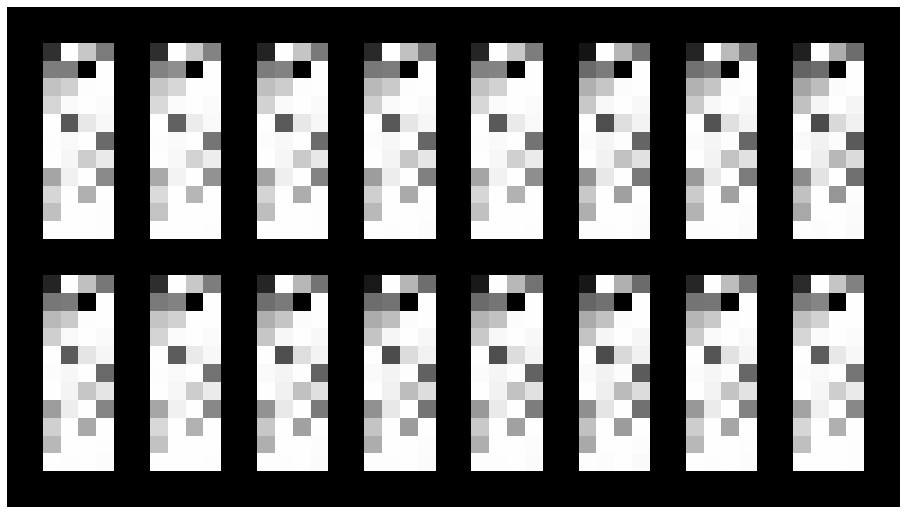

Epoch: [116/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.0969
D(x): 1.0000, D(G(z)): 0.0000


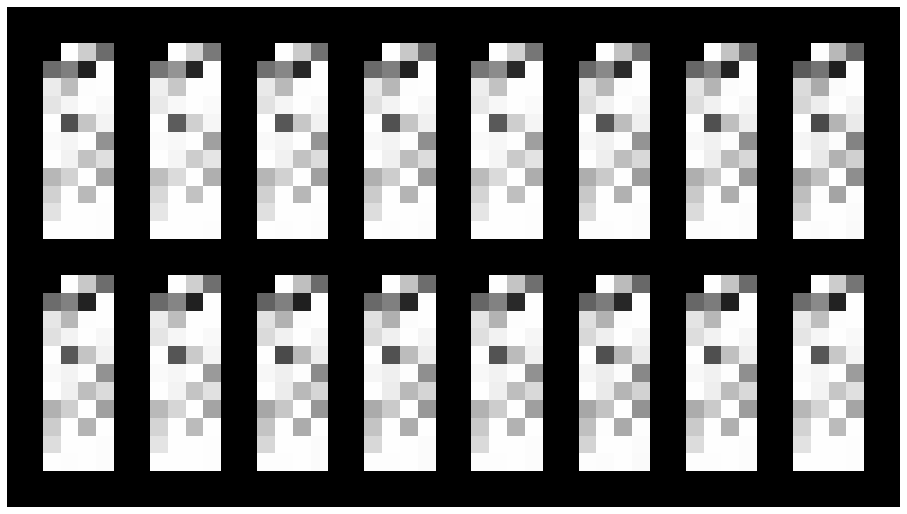

Epoch: [117/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 11.1169
D(x): 1.0000, D(G(z)): 0.0001


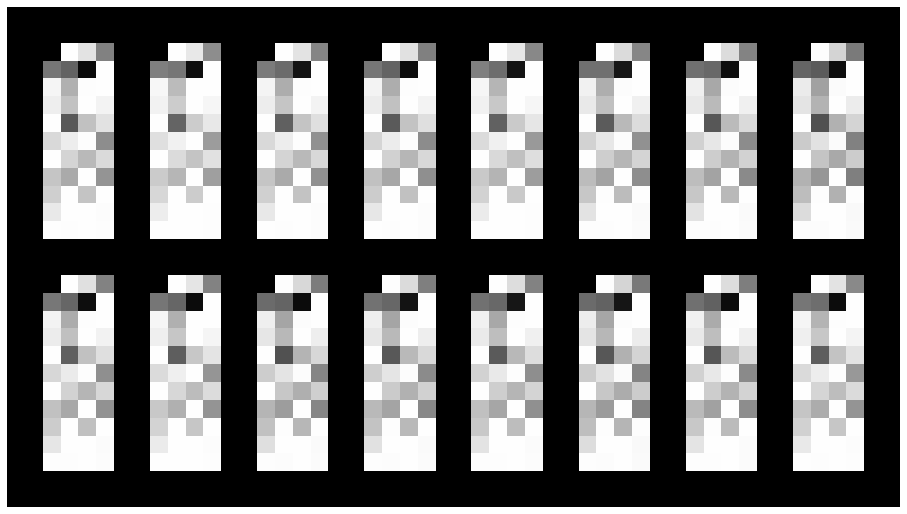

Epoch: [118/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.1330
D(x): 1.0000, D(G(z)): 0.0000


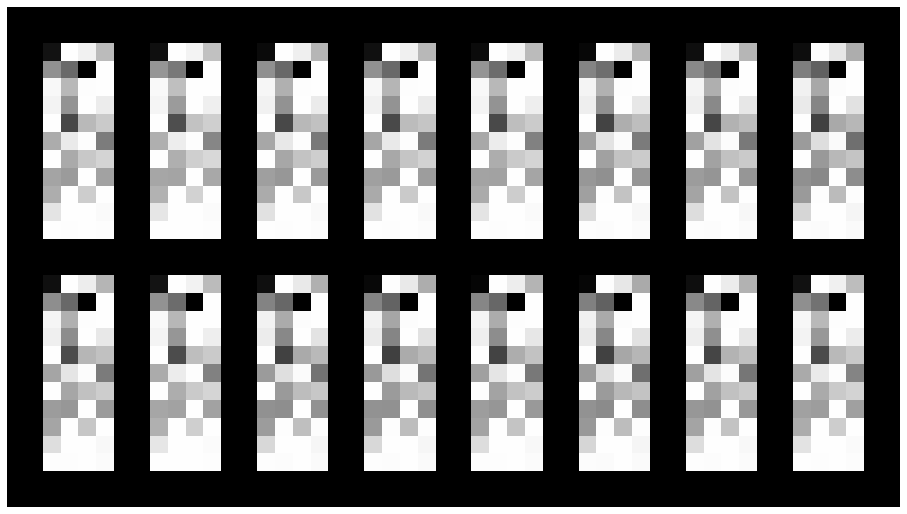

Epoch: [119/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.1722
D(x): 1.0000, D(G(z)): 0.0000


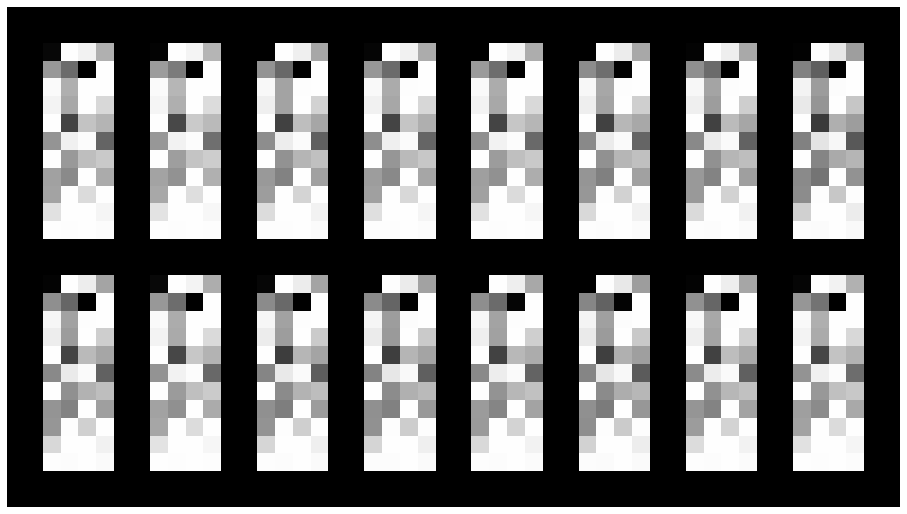

Epoch: [120/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.2823
D(x): 1.0000, D(G(z)): 0.0000


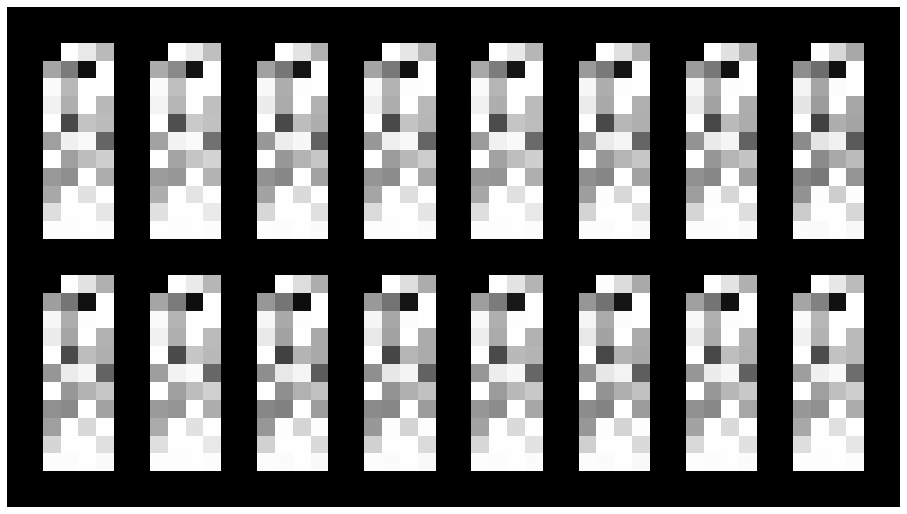

Epoch: [121/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.3493
D(x): 1.0000, D(G(z)): 0.0000


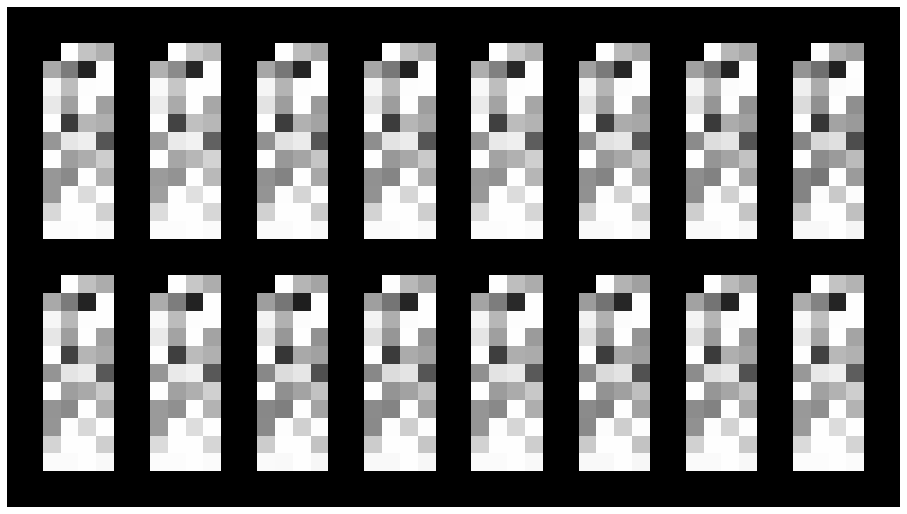

Epoch: [122/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.2323
D(x): 1.0000, D(G(z)): 0.0000


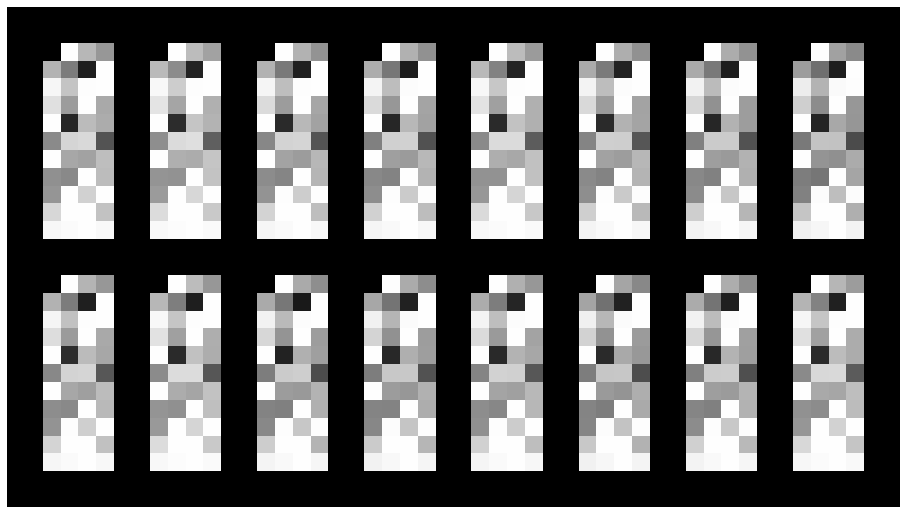

Epoch: [123/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.3454
D(x): 1.0000, D(G(z)): 0.0000


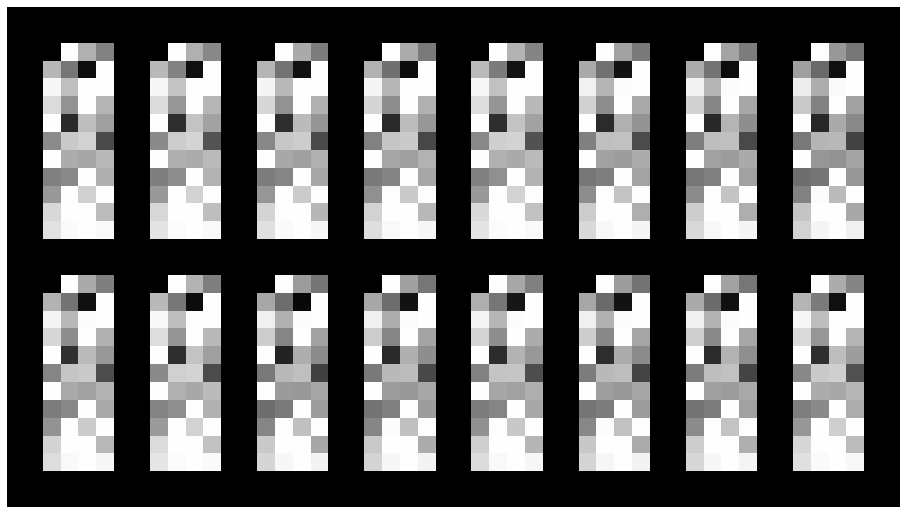

Epoch: [124/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 11.0627
D(x): 0.9999, D(G(z)): 0.0000


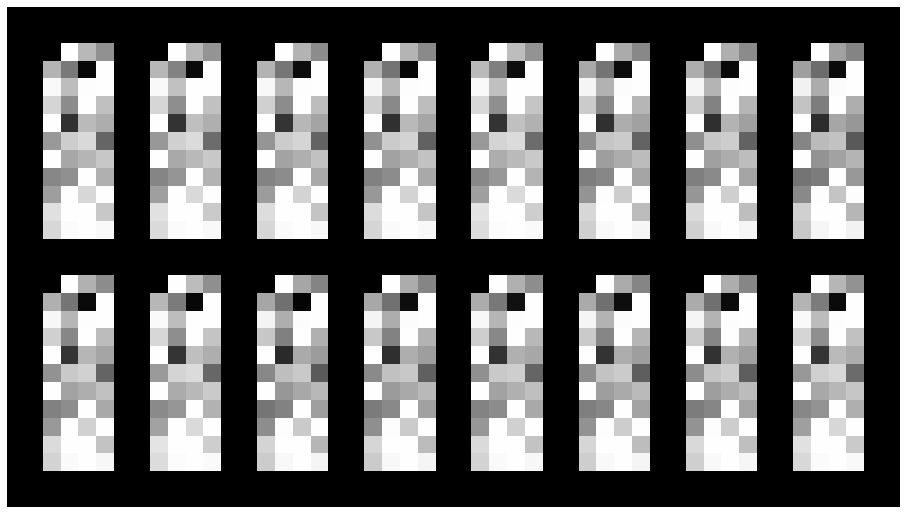

Epoch: [125/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 10.9247
D(x): 1.0000, D(G(z)): 0.0000


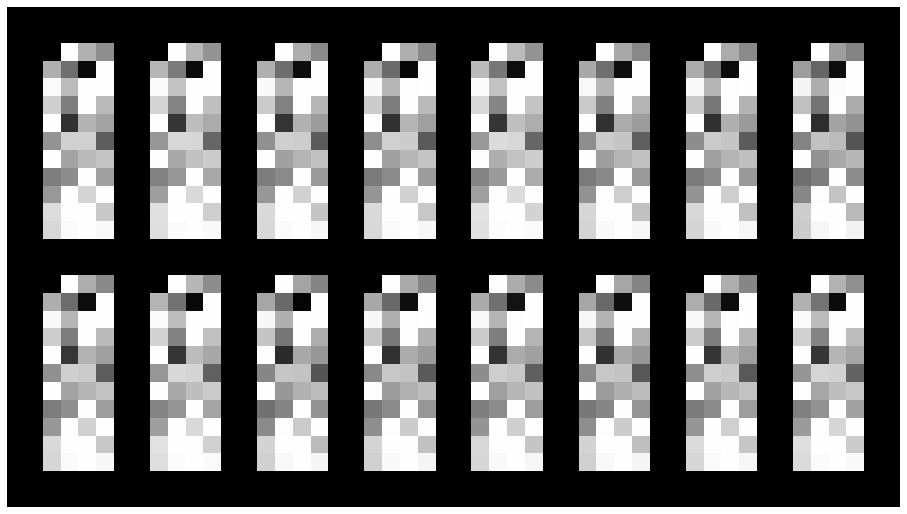

Epoch: [126/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.0987
D(x): 1.0000, D(G(z)): 0.0000


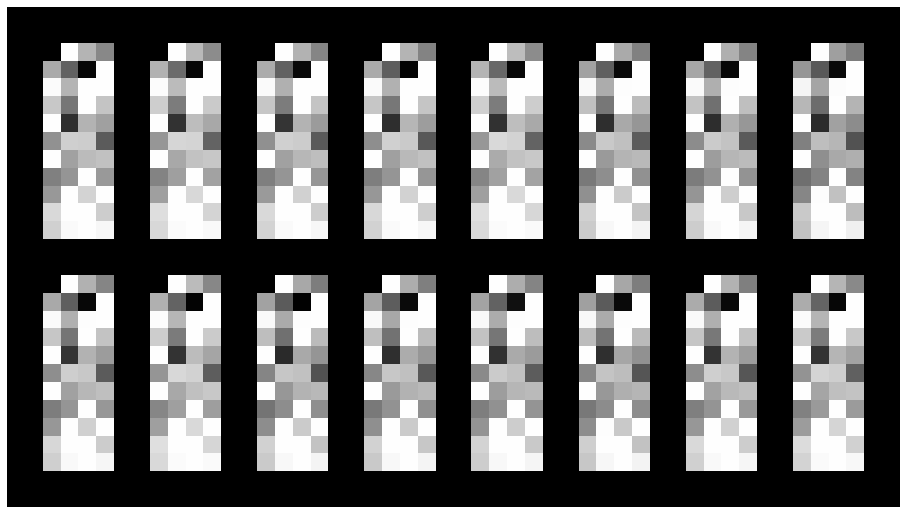

Epoch: [127/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 10.7125
D(x): 1.0000, D(G(z)): 0.0000


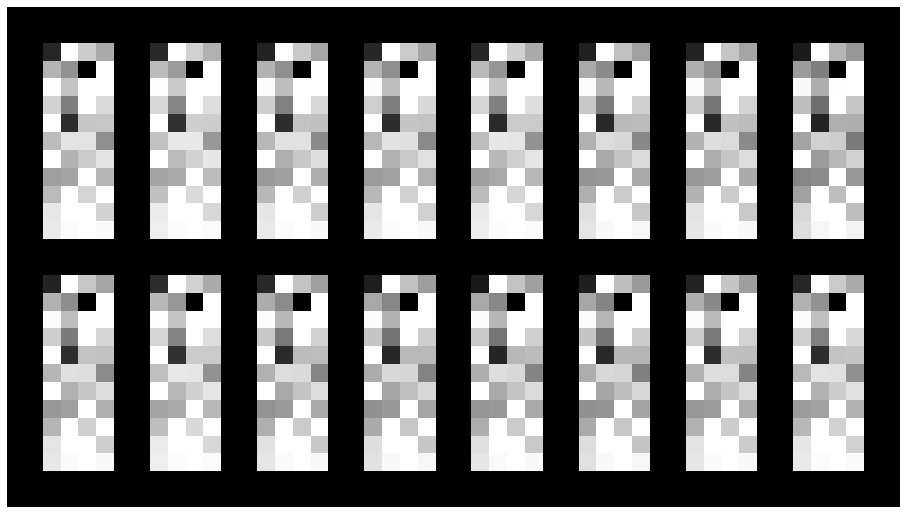

Epoch: [128/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.5554
D(x): 1.0000, D(G(z)): 0.0001


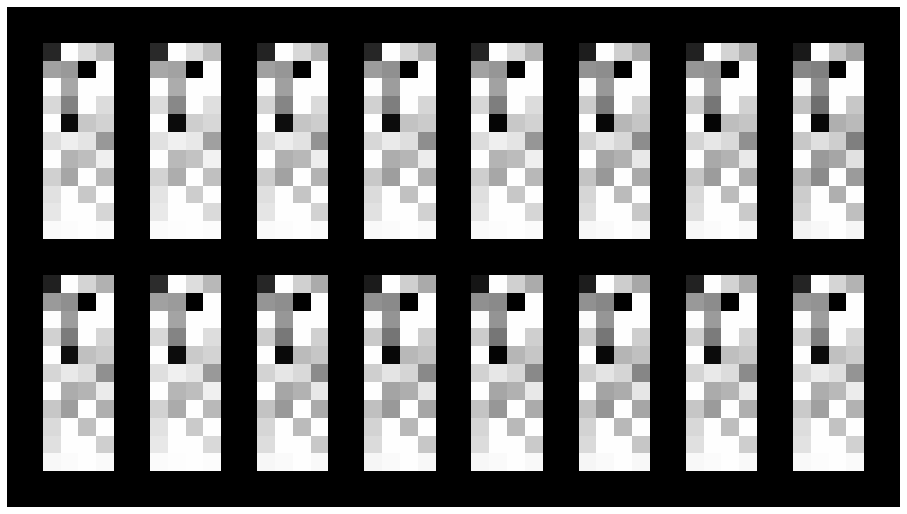

Epoch: [129/200], Batch Num: [0/12]
Discriminator Loss: 0.0001, Generator Loss: 10.6953
D(x): 1.0000, D(G(z)): 0.0001


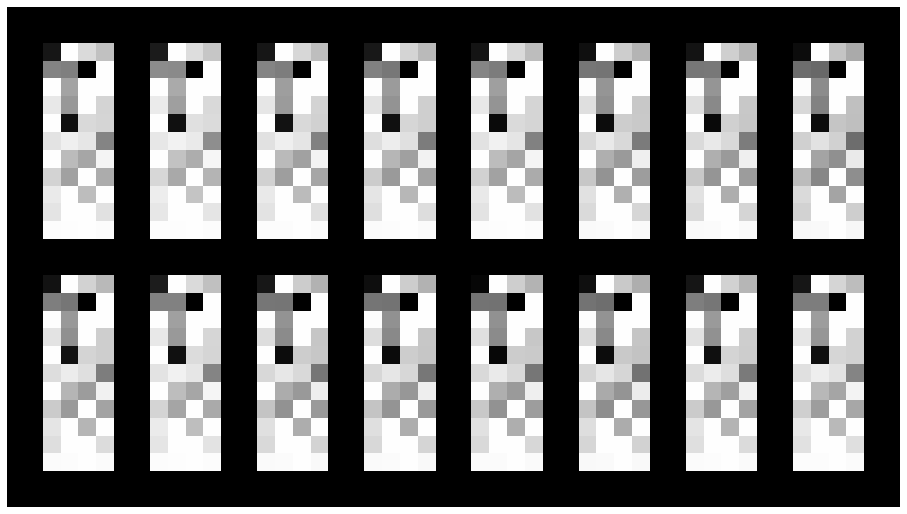

Epoch: [130/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.0574
D(x): 1.0000, D(G(z)): 0.0000


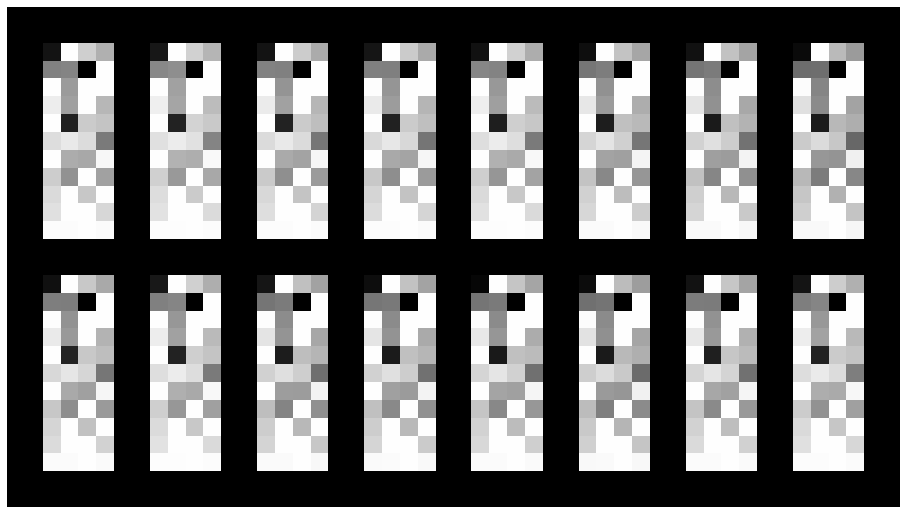

Epoch: [131/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.3353
D(x): 1.0000, D(G(z)): 0.0000


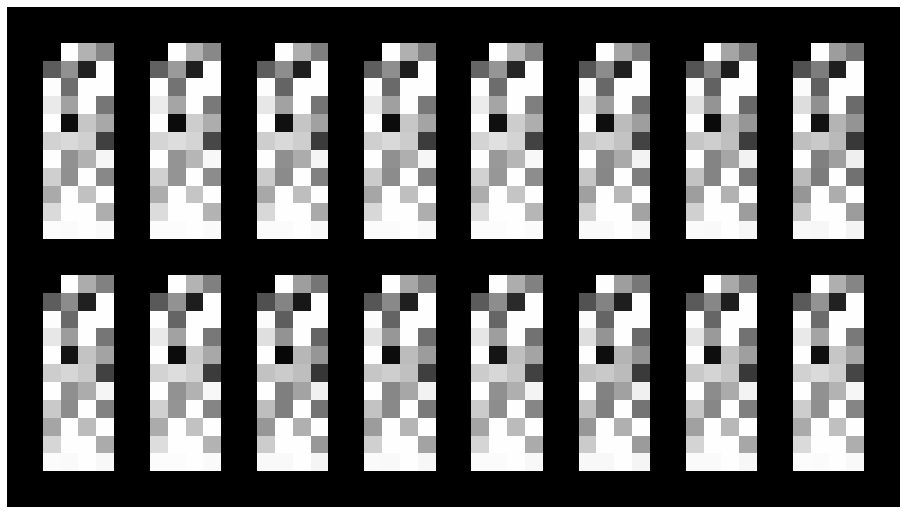

Epoch: [132/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.3807
D(x): 1.0000, D(G(z)): 0.0000


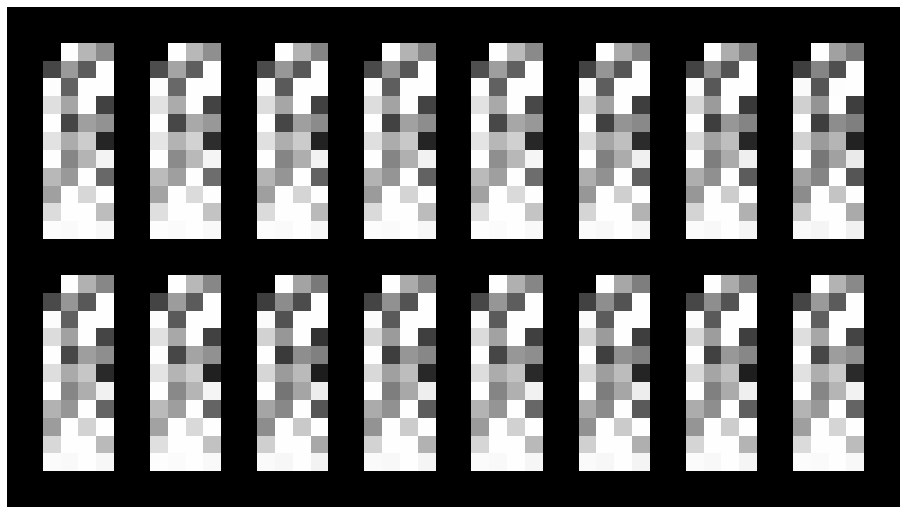

Epoch: [133/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.3549
D(x): 1.0000, D(G(z)): 0.0000


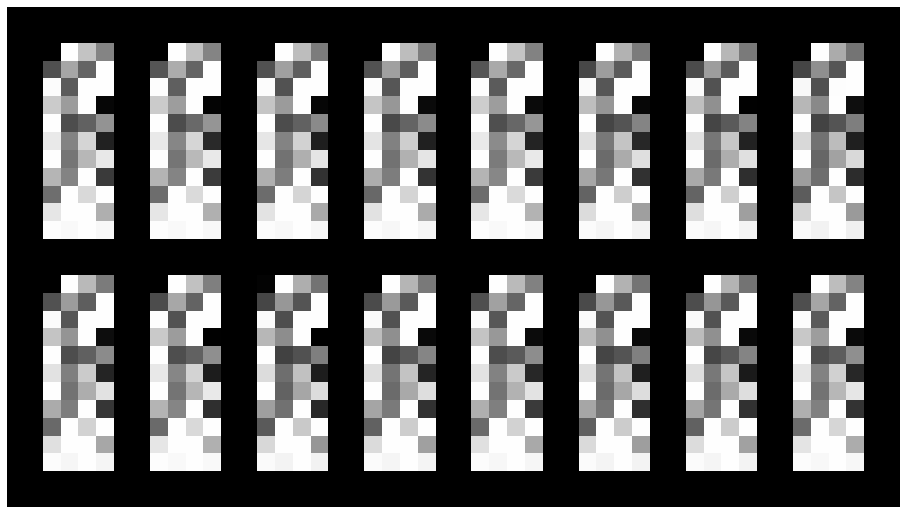

Epoch: [134/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.2757
D(x): 1.0000, D(G(z)): 0.0000


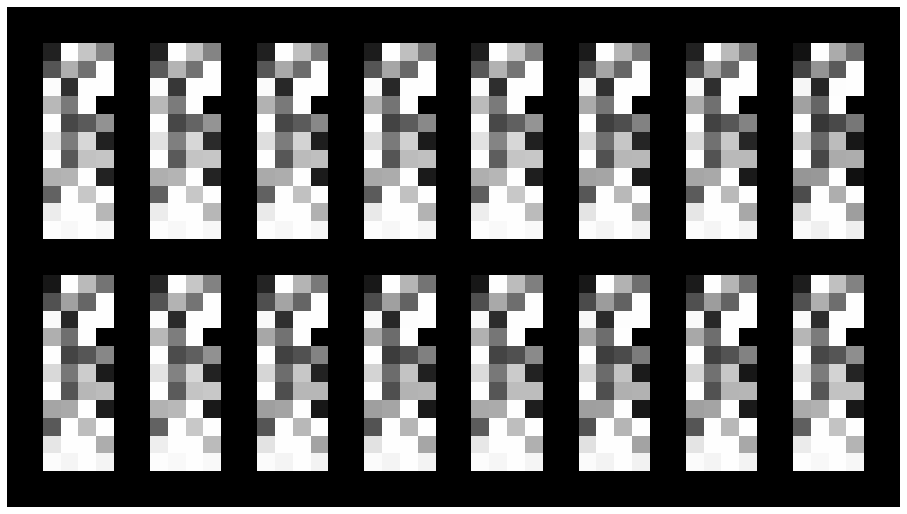

Epoch: [135/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.3595
D(x): 1.0000, D(G(z)): 0.0000


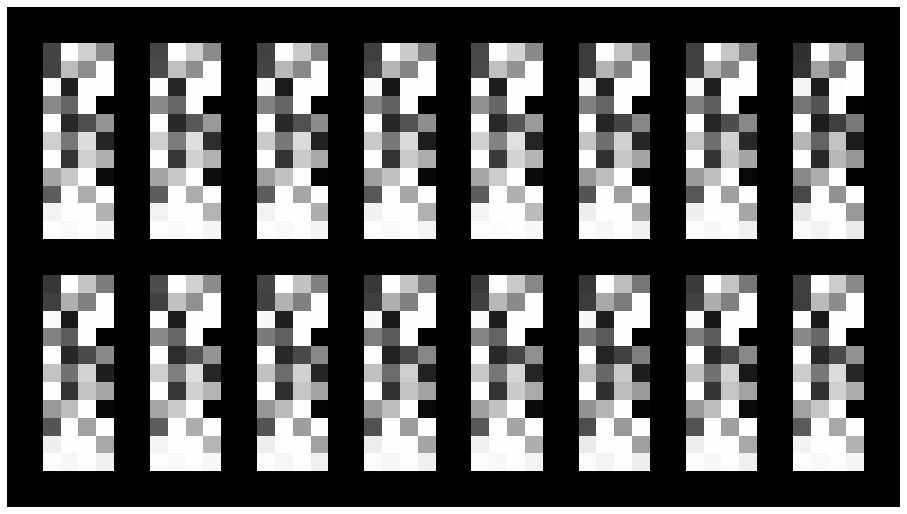

Epoch: [136/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.1912
D(x): 1.0000, D(G(z)): 0.0000


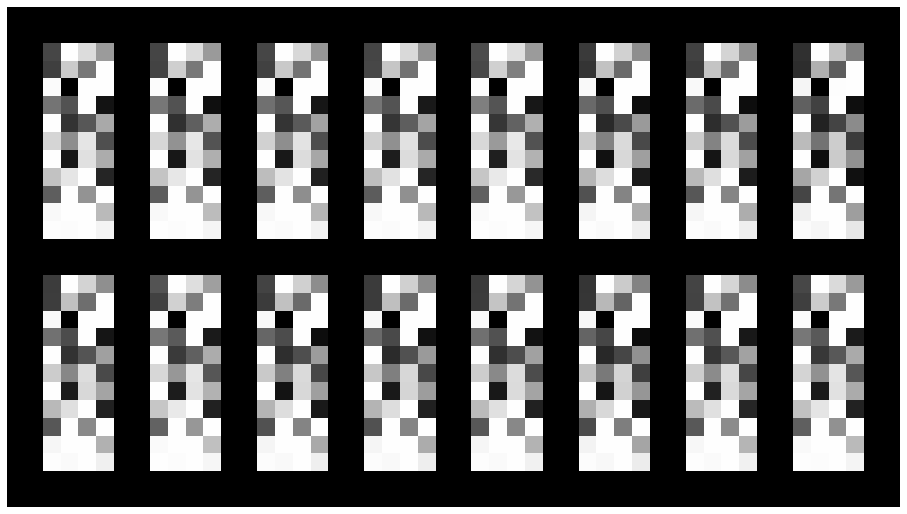

Epoch: [137/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.1397
D(x): 1.0000, D(G(z)): 0.0000


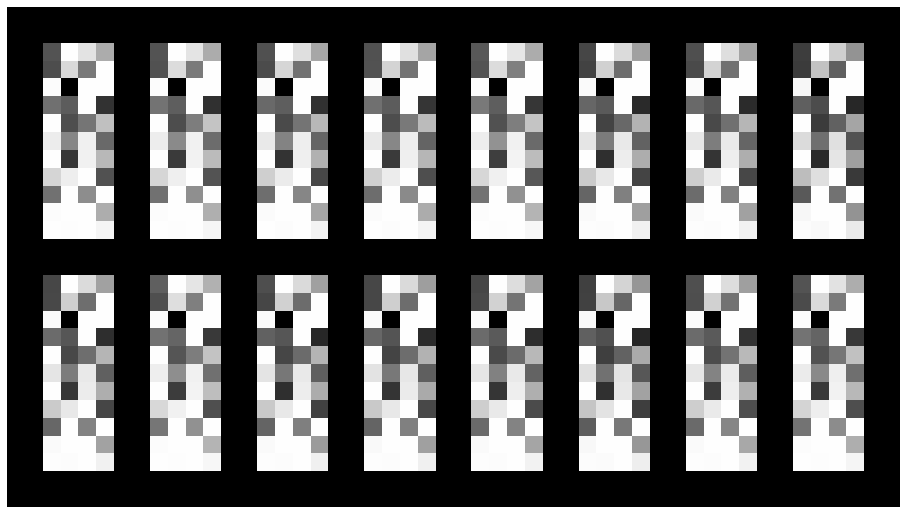

Epoch: [138/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.1636
D(x): 1.0000, D(G(z)): 0.0000


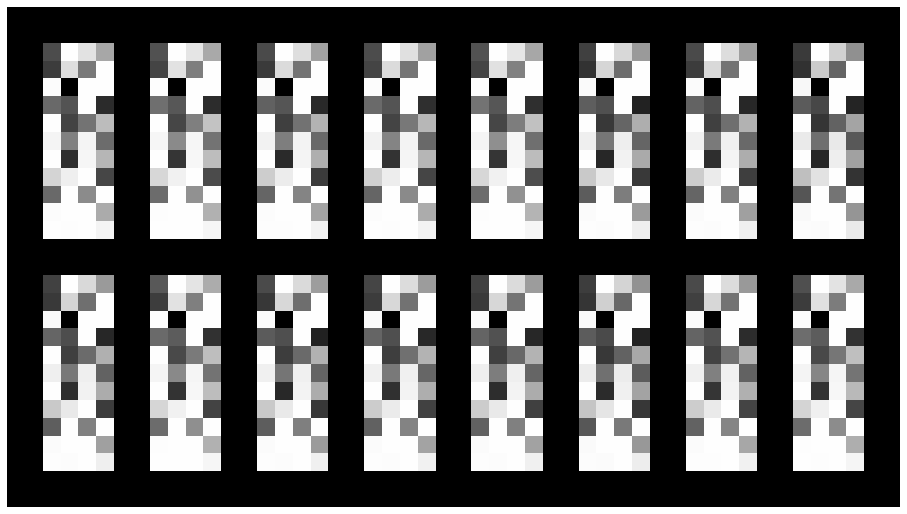

Epoch: [139/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.3373
D(x): 1.0000, D(G(z)): 0.0000


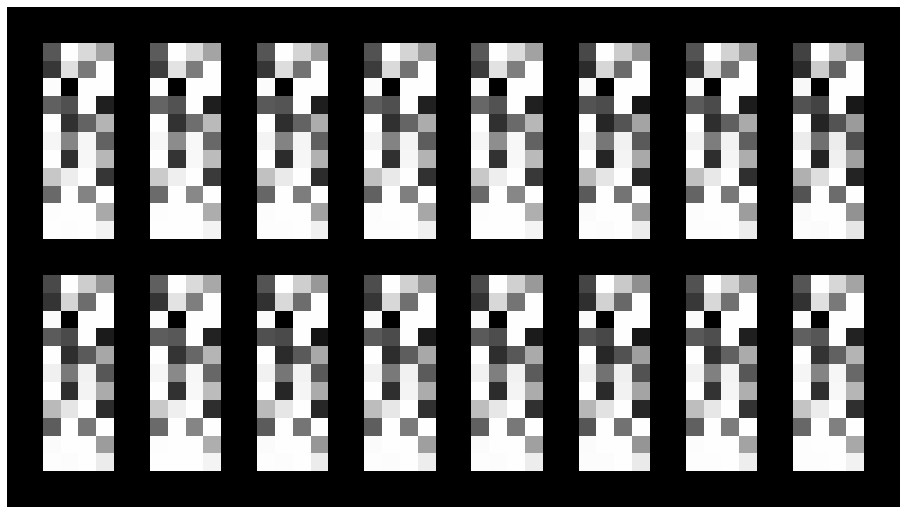

Epoch: [140/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.6437
D(x): 1.0000, D(G(z)): 0.0000


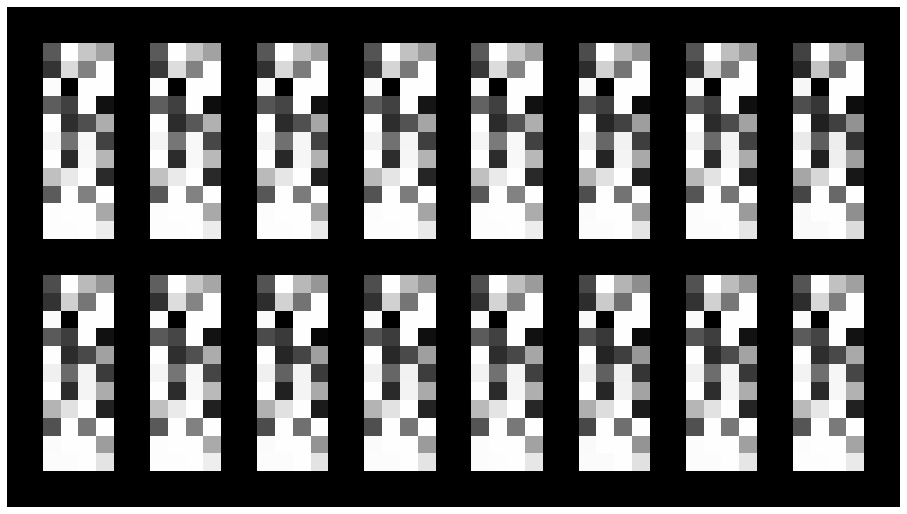

Epoch: [141/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.6481
D(x): 1.0000, D(G(z)): 0.0000


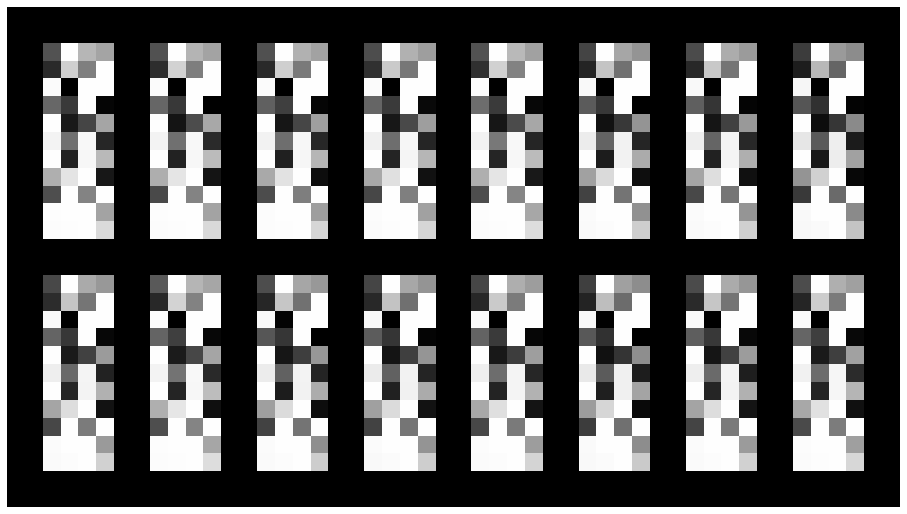

Epoch: [142/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.8096
D(x): 1.0000, D(G(z)): 0.0000


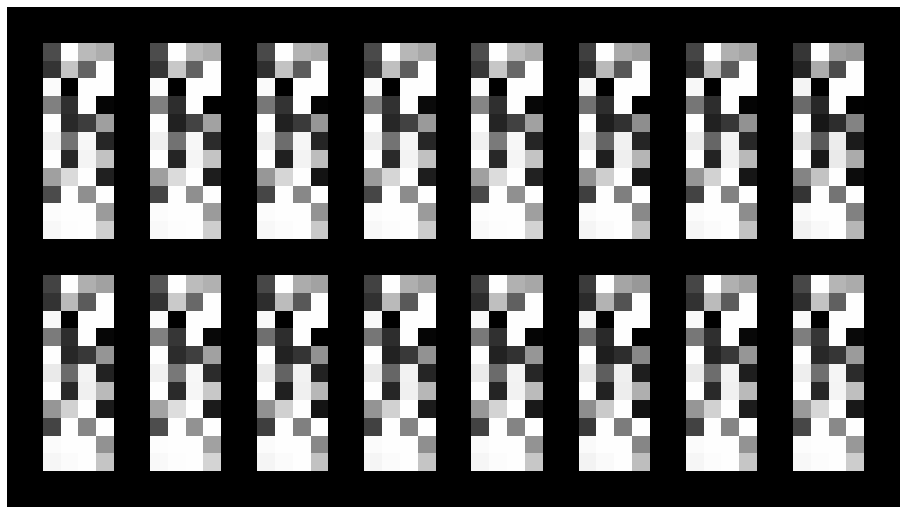

Epoch: [143/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.9225
D(x): 1.0000, D(G(z)): 0.0000


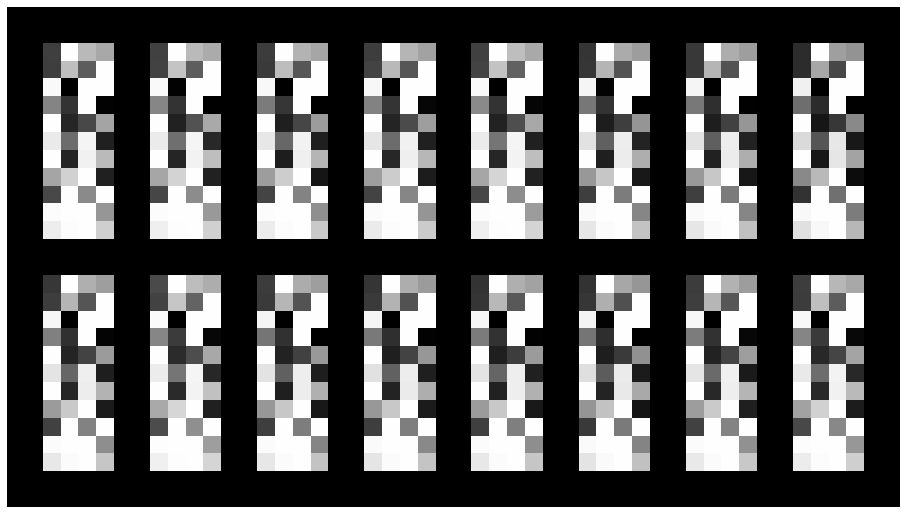

Epoch: [144/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.0335
D(x): 1.0000, D(G(z)): 0.0000


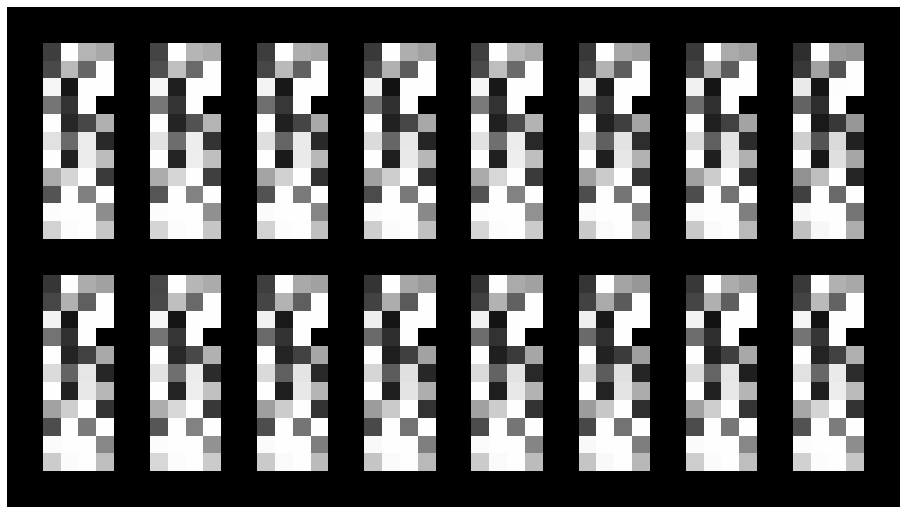

Epoch: [145/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.9770
D(x): 1.0000, D(G(z)): 0.0000


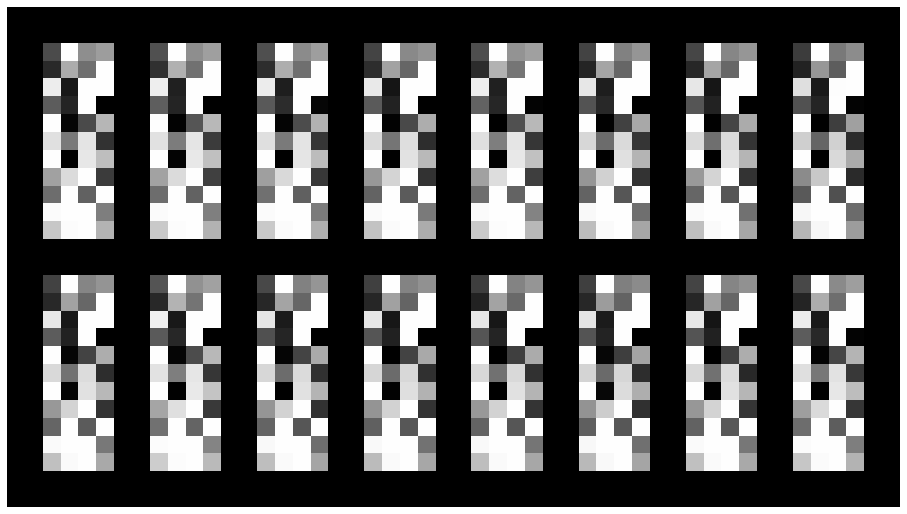

Epoch: [146/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.9241
D(x): 1.0000, D(G(z)): 0.0000


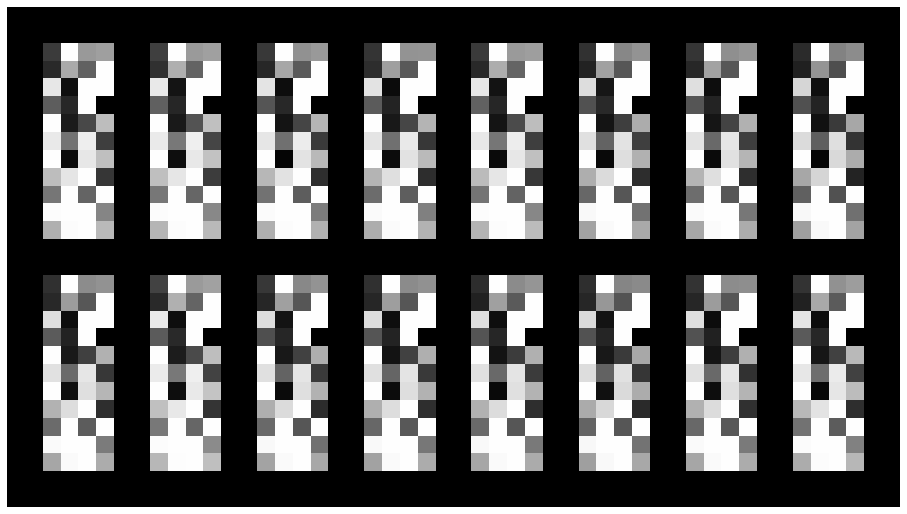

Epoch: [147/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.9306
D(x): 1.0000, D(G(z)): 0.0000


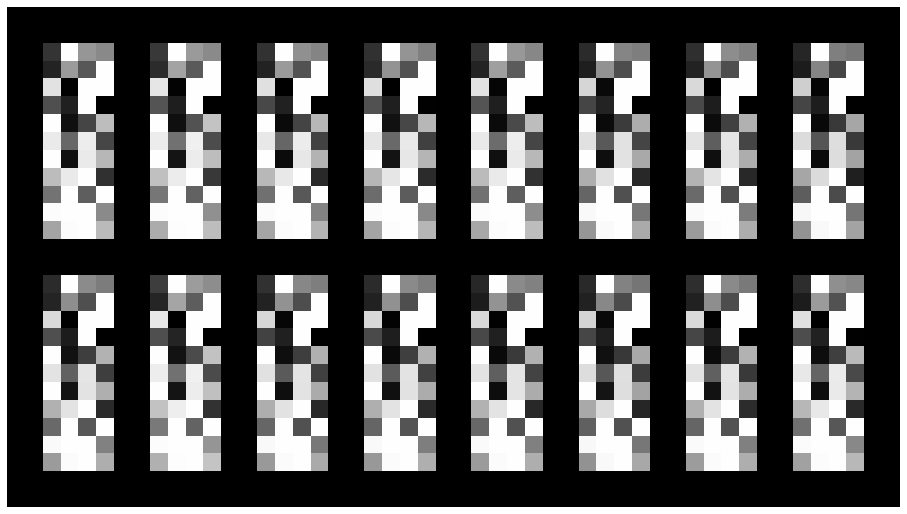

Epoch: [148/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.8782
D(x): 1.0000, D(G(z)): 0.0000


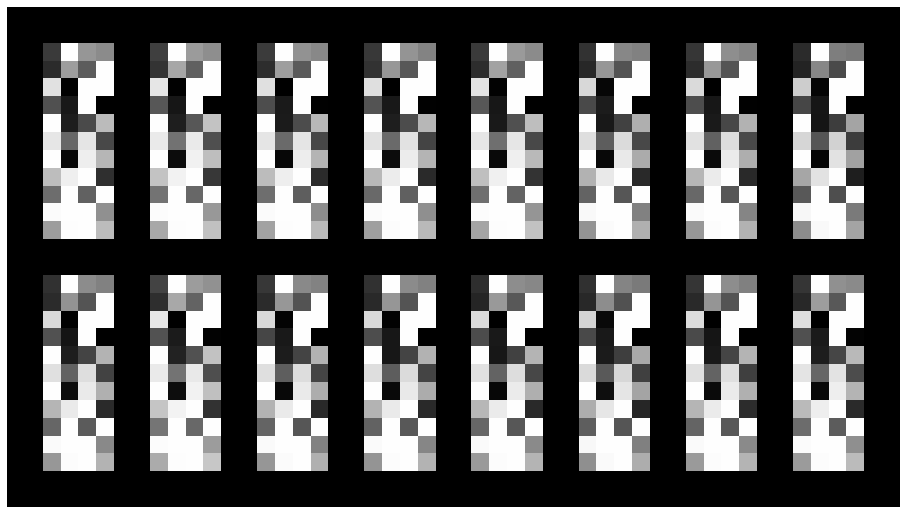

Epoch: [149/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.9856
D(x): 1.0000, D(G(z)): 0.0000


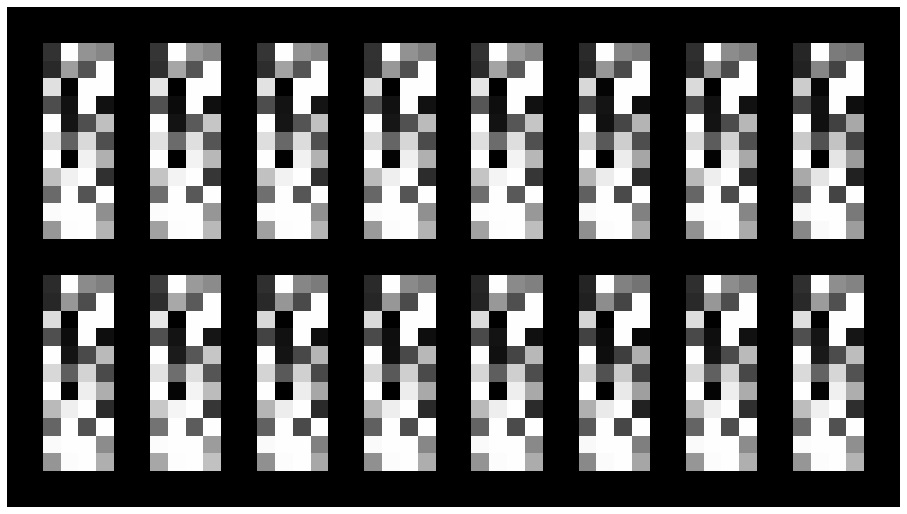

Epoch: [150/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.9064
D(x): 1.0000, D(G(z)): 0.0000


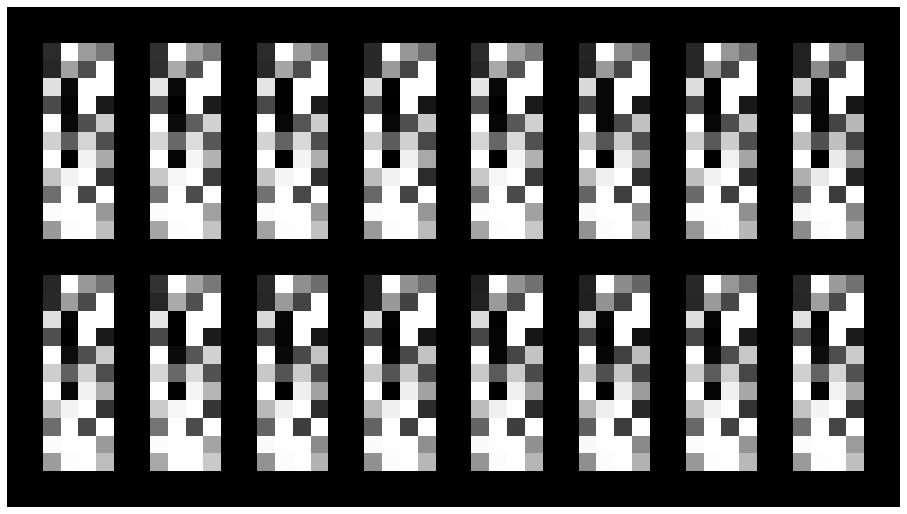

Epoch: [151/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.9429
D(x): 1.0000, D(G(z)): 0.0000


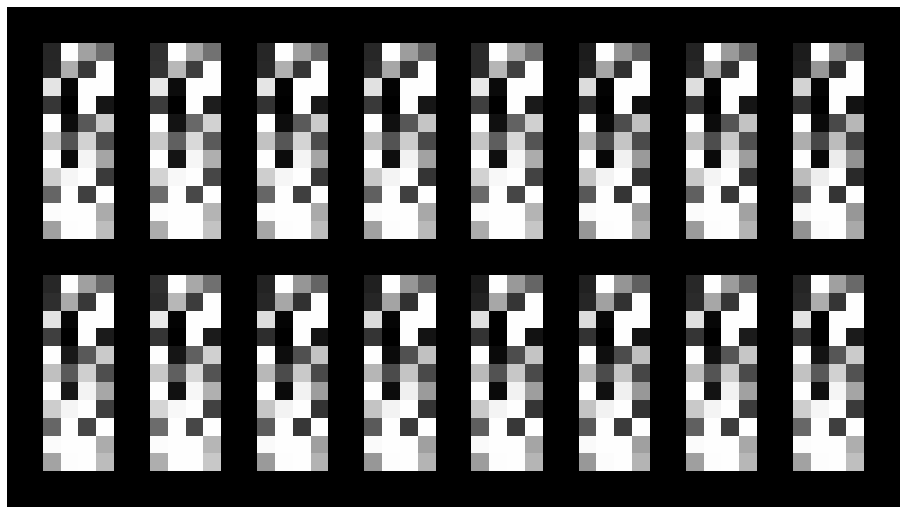

Epoch: [152/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.7522
D(x): 1.0000, D(G(z)): 0.0000


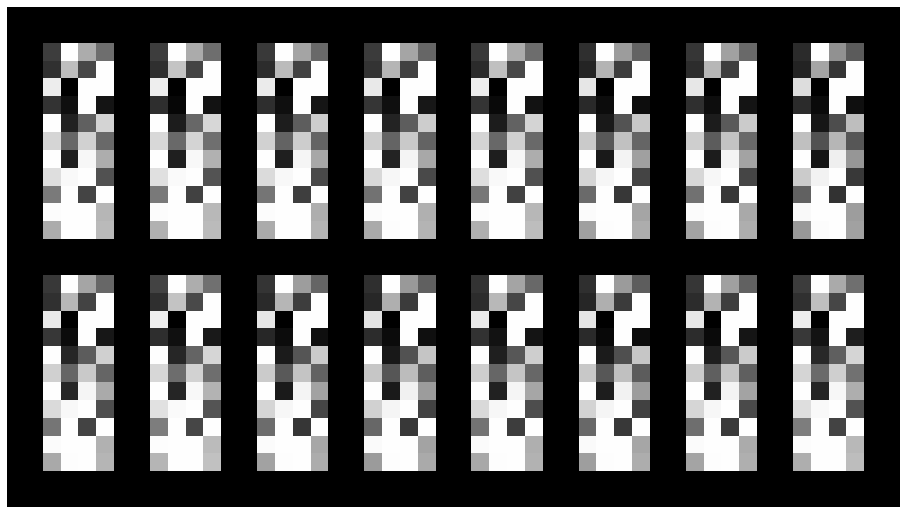

Epoch: [153/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.7137
D(x): 1.0000, D(G(z)): 0.0000


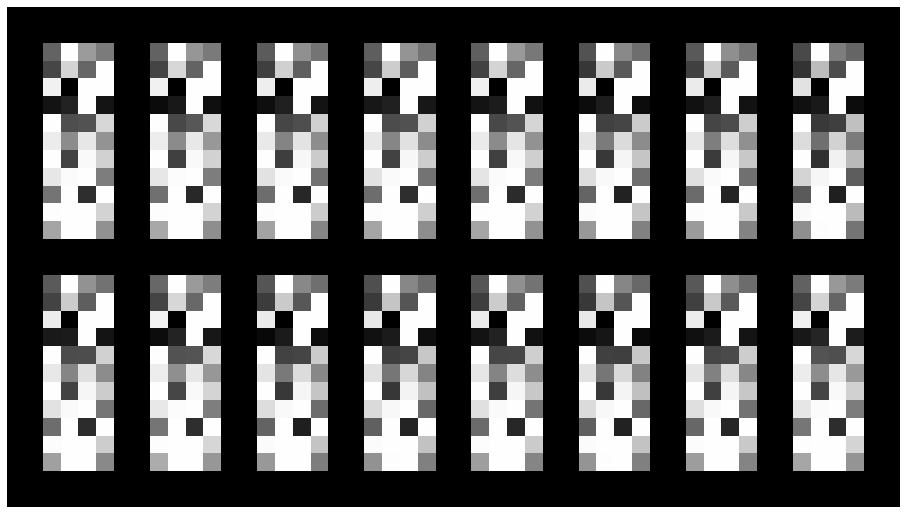

Epoch: [154/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.7739
D(x): 1.0000, D(G(z)): 0.0000


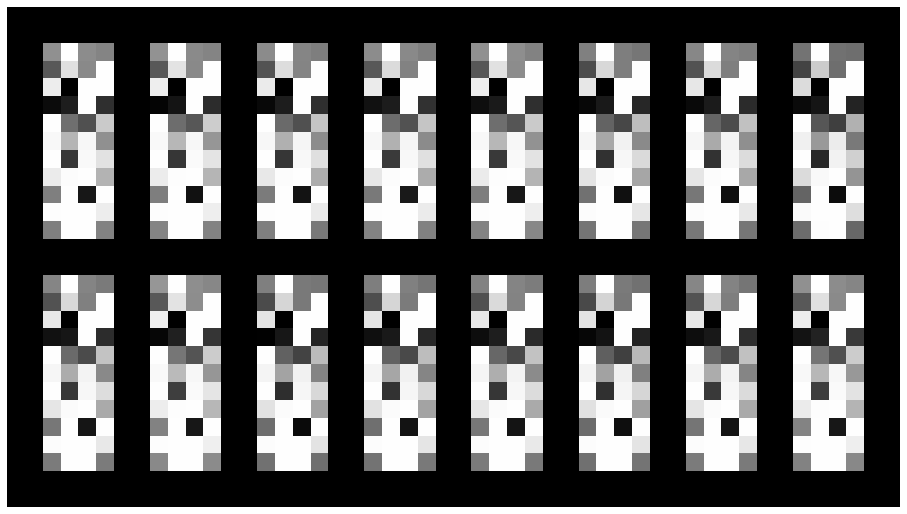

Epoch: [155/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.9613
D(x): 1.0000, D(G(z)): 0.0000


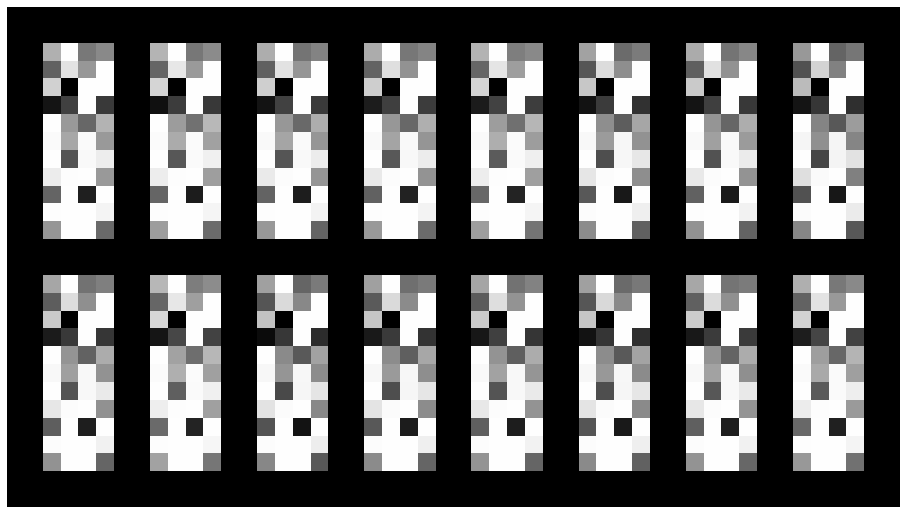

Epoch: [156/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.0317
D(x): 1.0000, D(G(z)): 0.0000


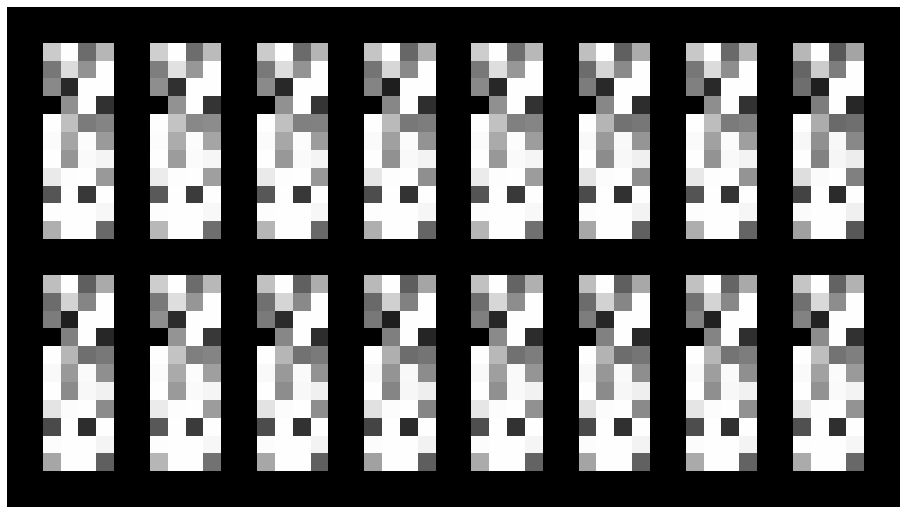

Epoch: [157/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.9094
D(x): 1.0000, D(G(z)): 0.0000


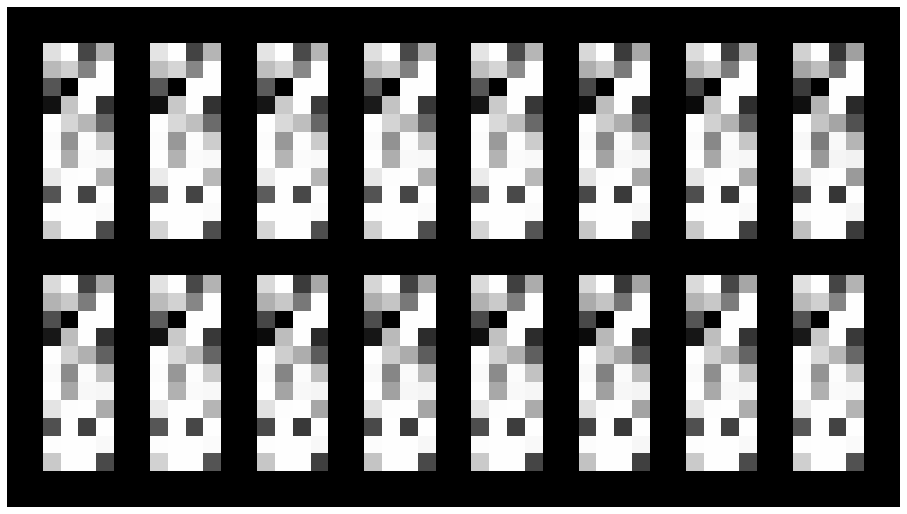

Epoch: [158/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.8111
D(x): 1.0000, D(G(z)): 0.0000


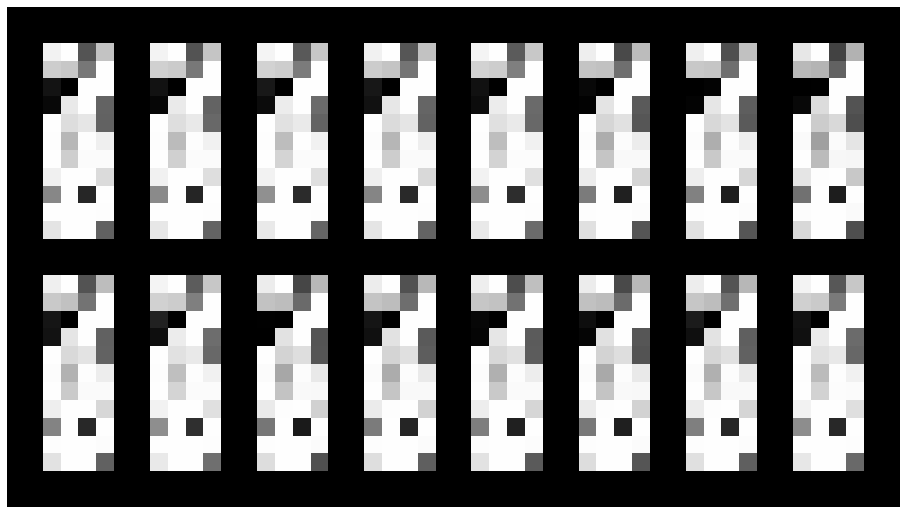

Epoch: [159/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.6907
D(x): 1.0000, D(G(z)): 0.0000


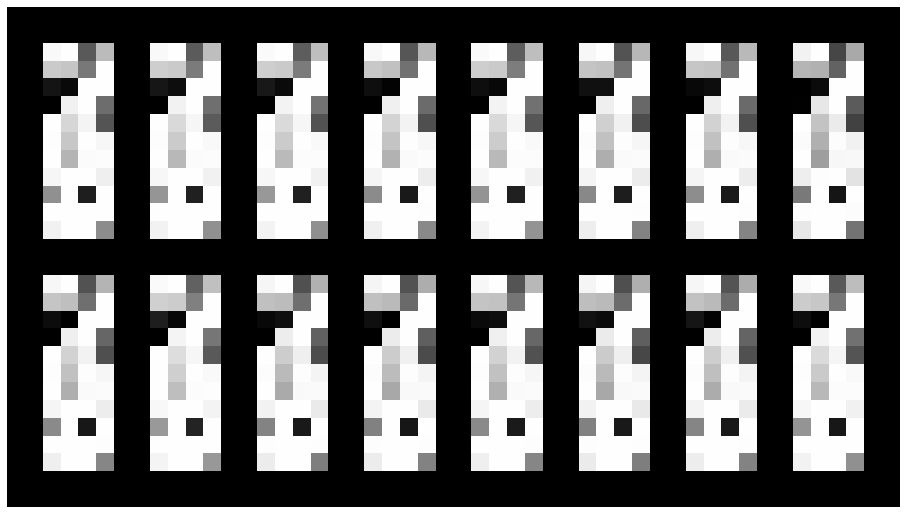

Epoch: [160/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.7560
D(x): 1.0000, D(G(z)): 0.0000


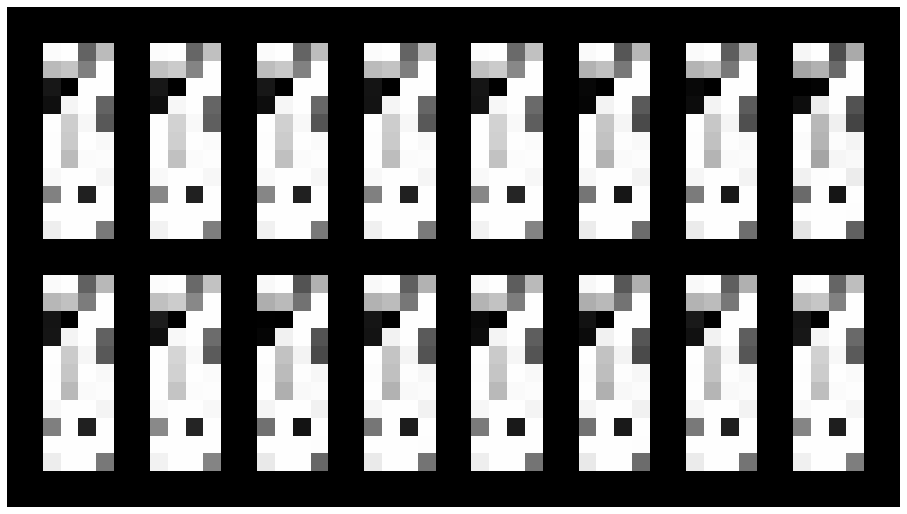

Epoch: [161/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.9577
D(x): 1.0000, D(G(z)): 0.0000


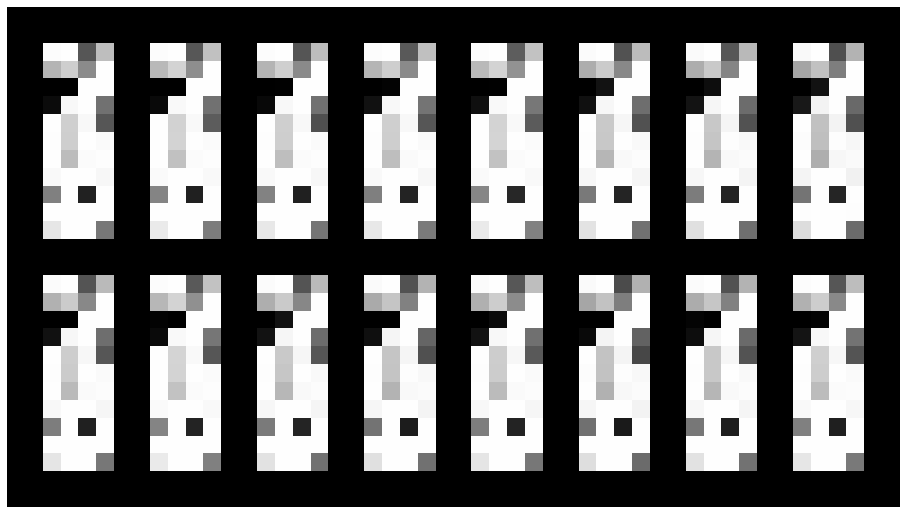

Epoch: [162/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.0693
D(x): 1.0000, D(G(z)): 0.0000


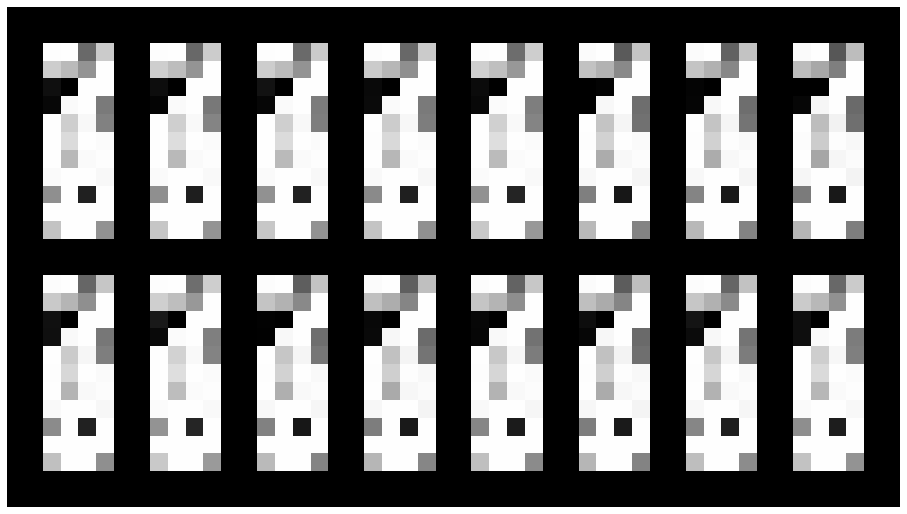

Epoch: [163/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.3227
D(x): 1.0000, D(G(z)): 0.0000


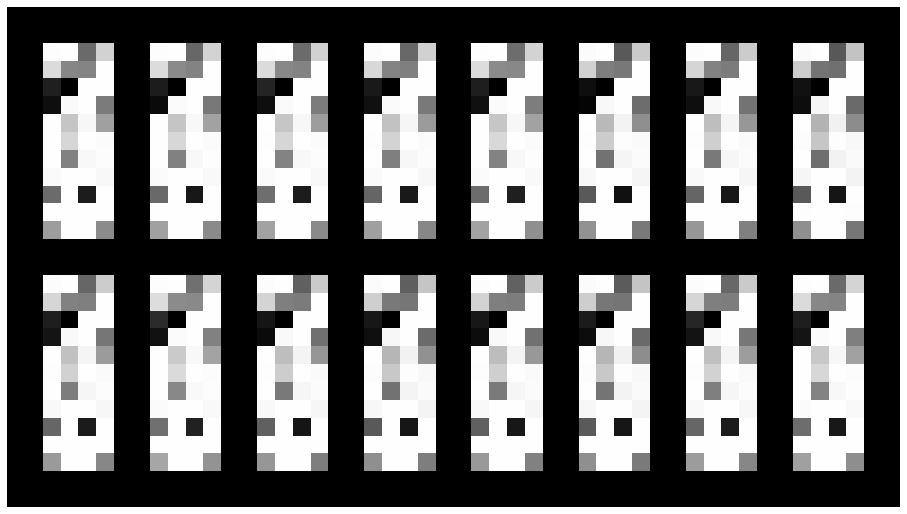

Epoch: [164/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.2034
D(x): 1.0000, D(G(z)): 0.0000


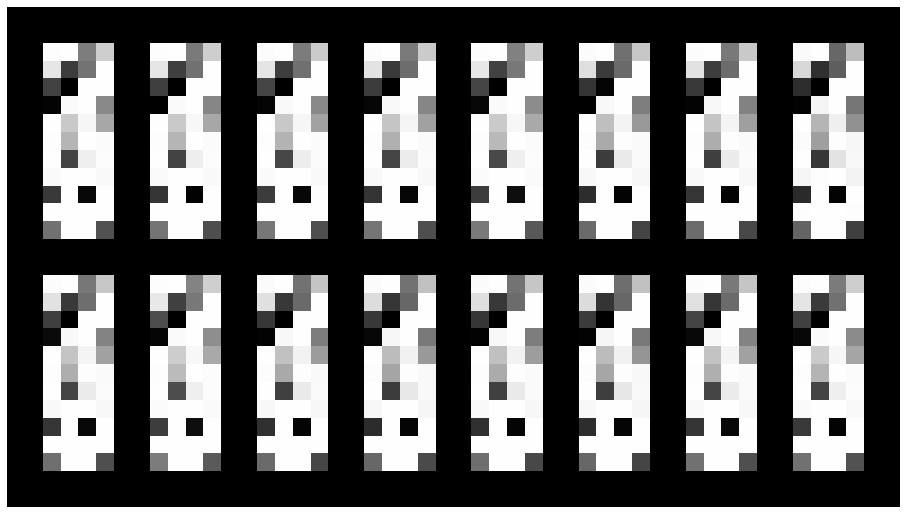

Epoch: [165/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.0767
D(x): 1.0000, D(G(z)): 0.0000


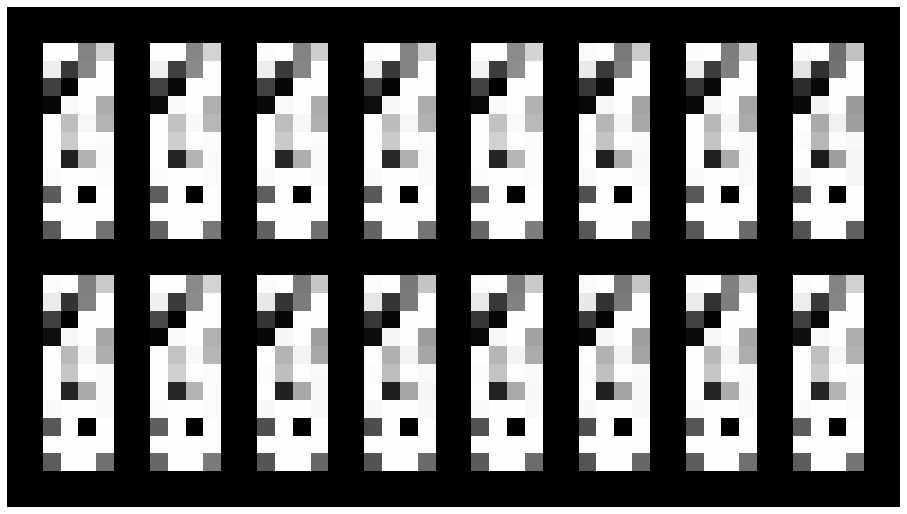

Epoch: [166/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.0895
D(x): 1.0000, D(G(z)): 0.0000


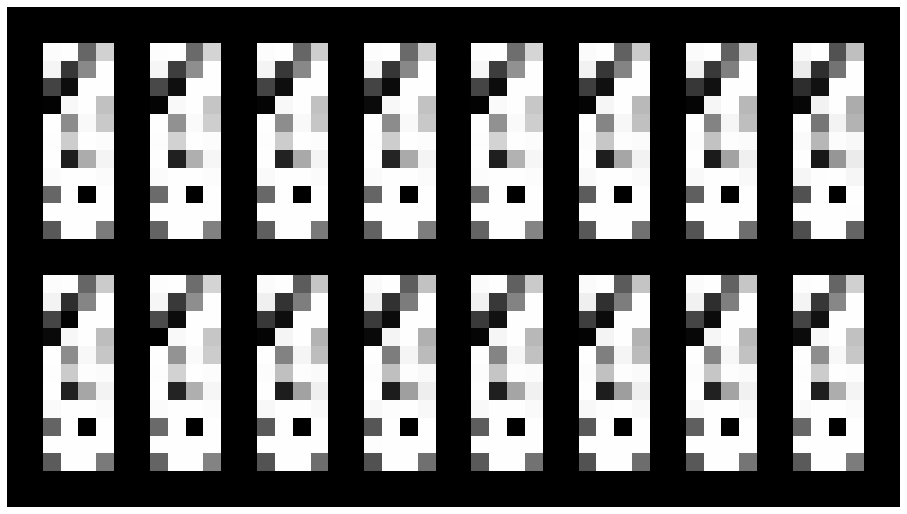

Epoch: [167/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.2160
D(x): 1.0000, D(G(z)): 0.0000


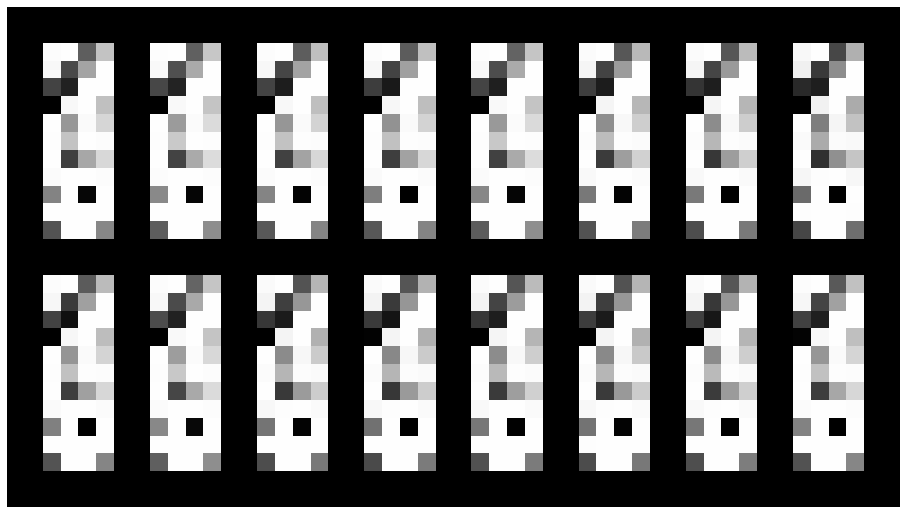

Epoch: [168/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.9631
D(x): 1.0000, D(G(z)): 0.0000


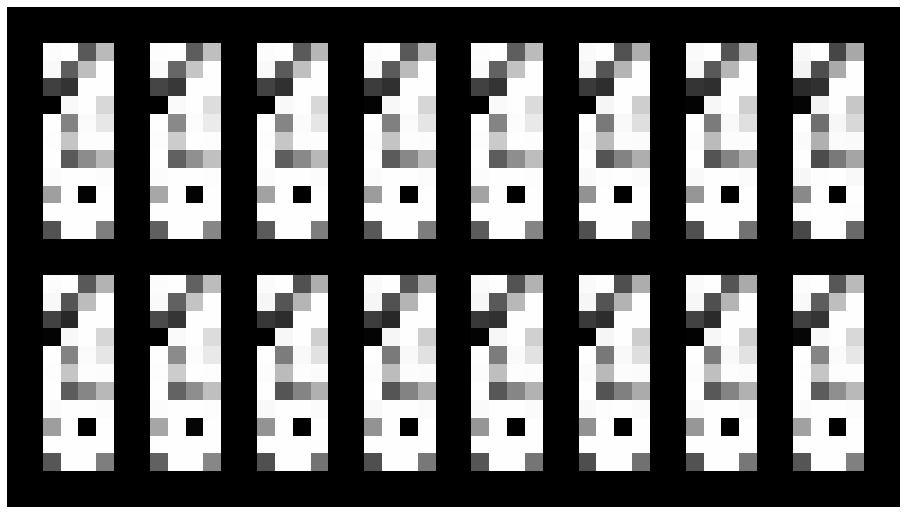

Epoch: [169/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.8171
D(x): 1.0000, D(G(z)): 0.0000


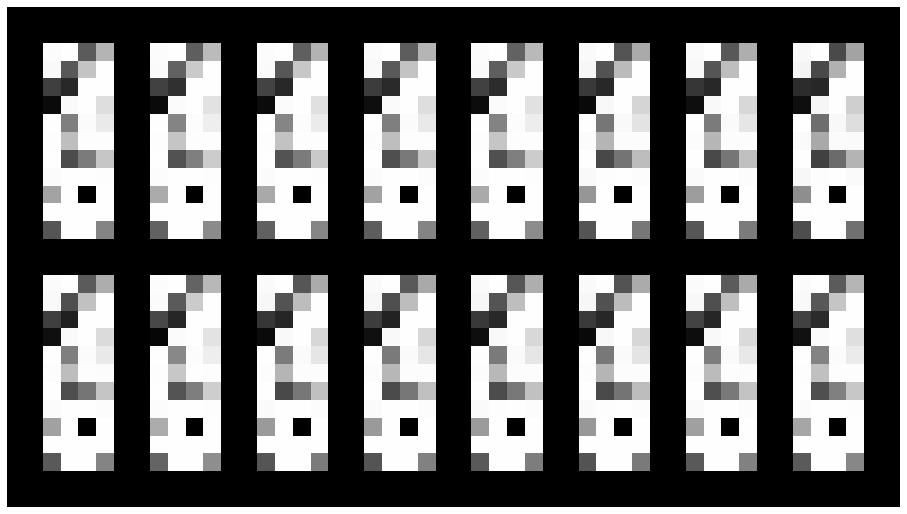

Epoch: [170/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.9083
D(x): 1.0000, D(G(z)): 0.0000


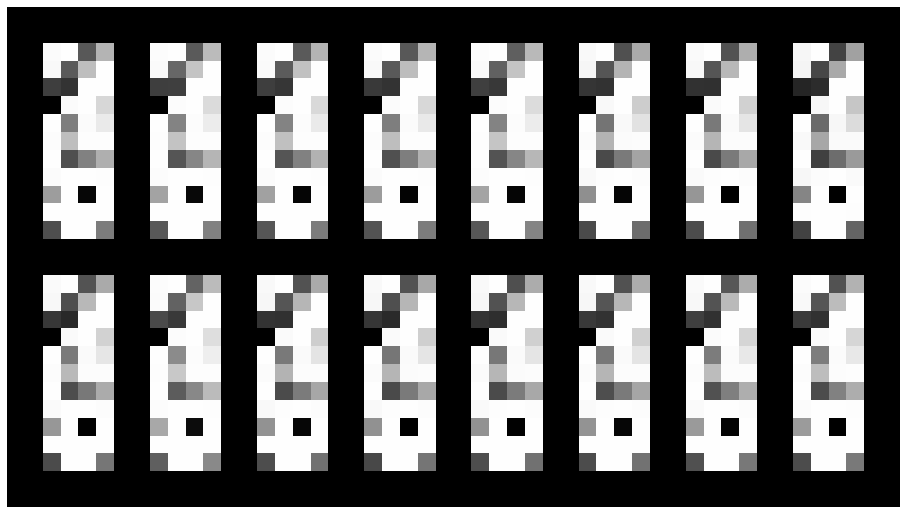

Epoch: [171/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.1308
D(x): 1.0000, D(G(z)): 0.0000


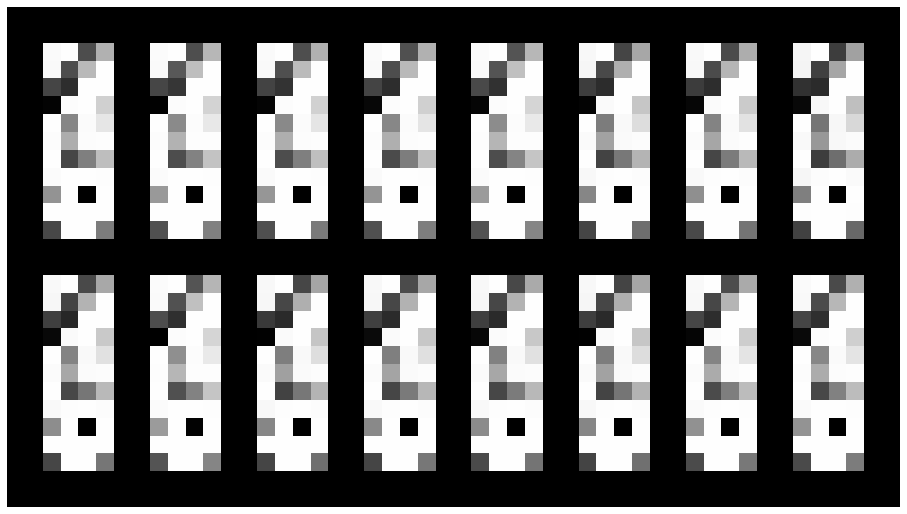

Epoch: [172/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.2030
D(x): 1.0000, D(G(z)): 0.0000


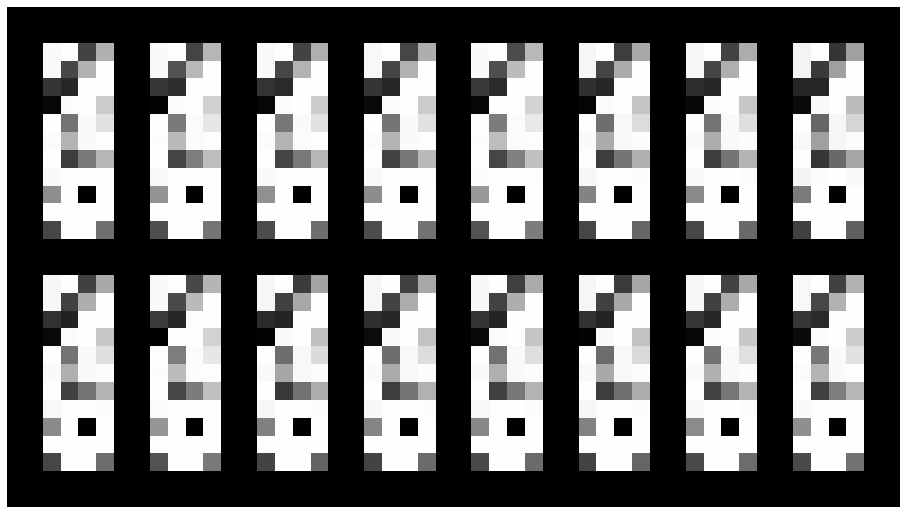

Epoch: [173/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.1869
D(x): 1.0000, D(G(z)): 0.0000


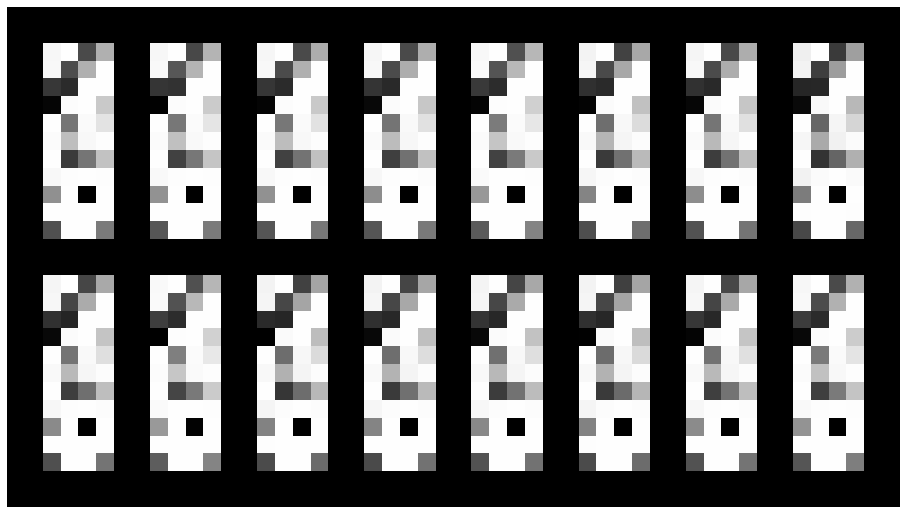

Epoch: [174/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.2553
D(x): 1.0000, D(G(z)): 0.0000


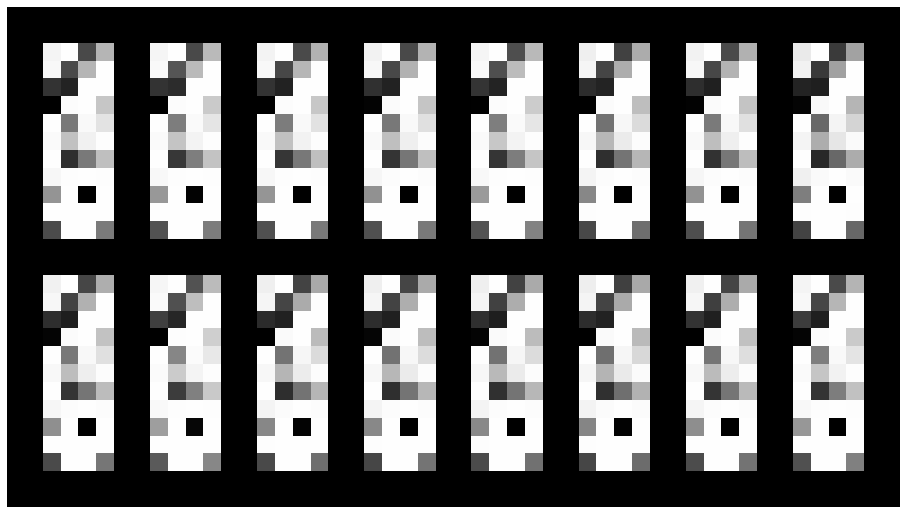

Epoch: [175/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.3596
D(x): 1.0000, D(G(z)): 0.0000


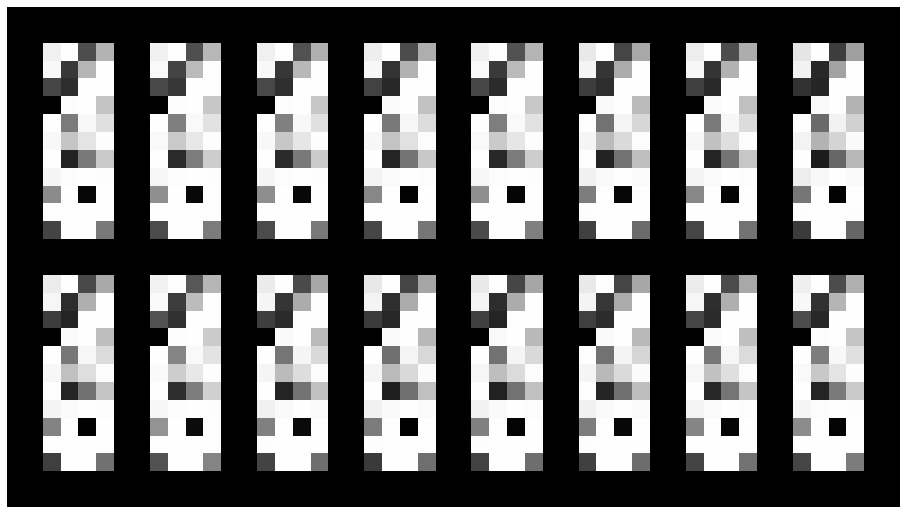

Epoch: [176/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.2623
D(x): 1.0000, D(G(z)): 0.0000


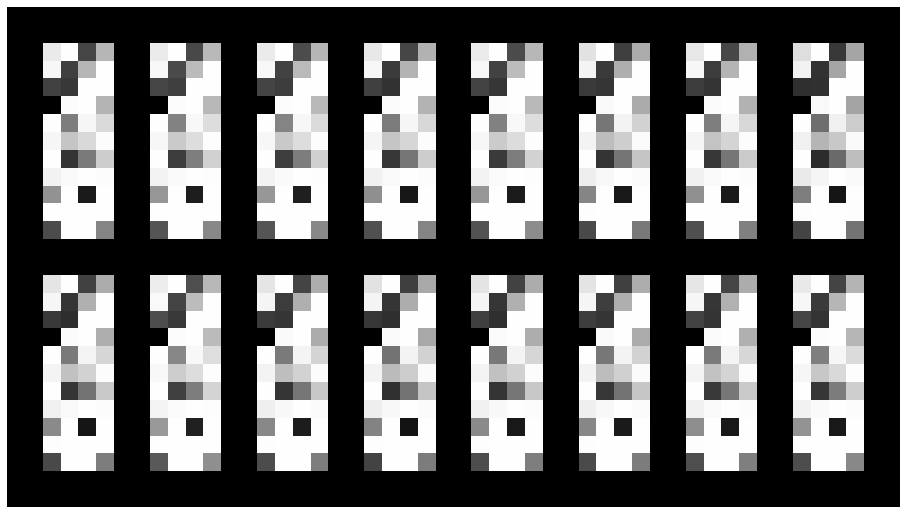

Epoch: [177/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.4894
D(x): 1.0000, D(G(z)): 0.0000


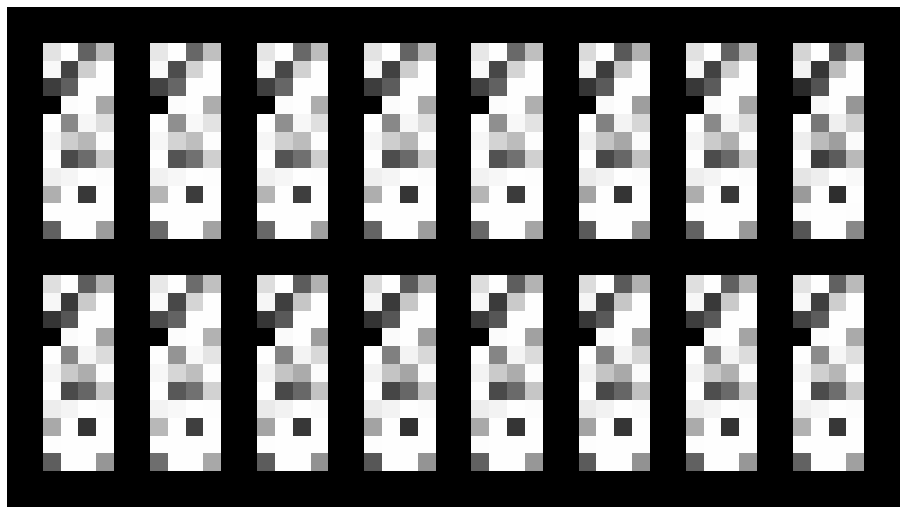

Epoch: [178/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.2884
D(x): 1.0000, D(G(z)): 0.0000


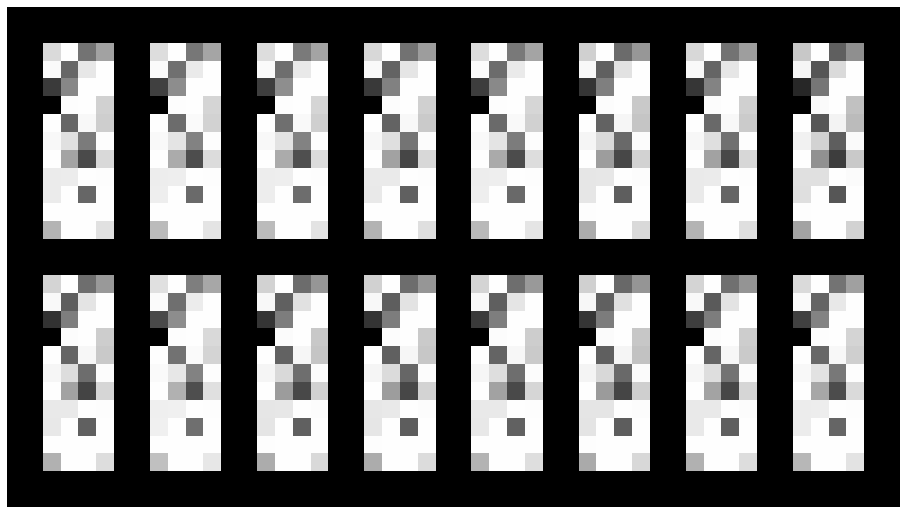

Epoch: [179/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.0767
D(x): 1.0000, D(G(z)): 0.0000


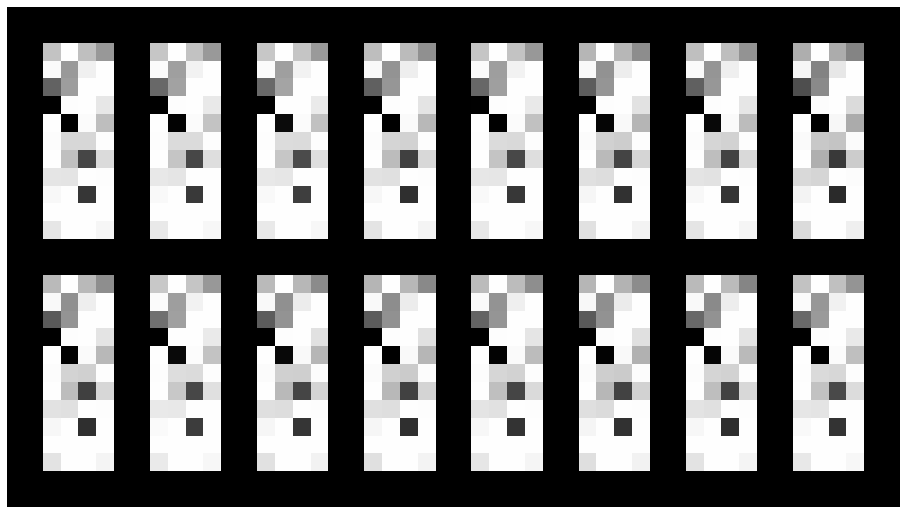

Epoch: [180/200], Batch Num: [0/12]
Discriminator Loss: 0.0007, Generator Loss: 7.8093
D(x): 1.0000, D(G(z)): 0.0007


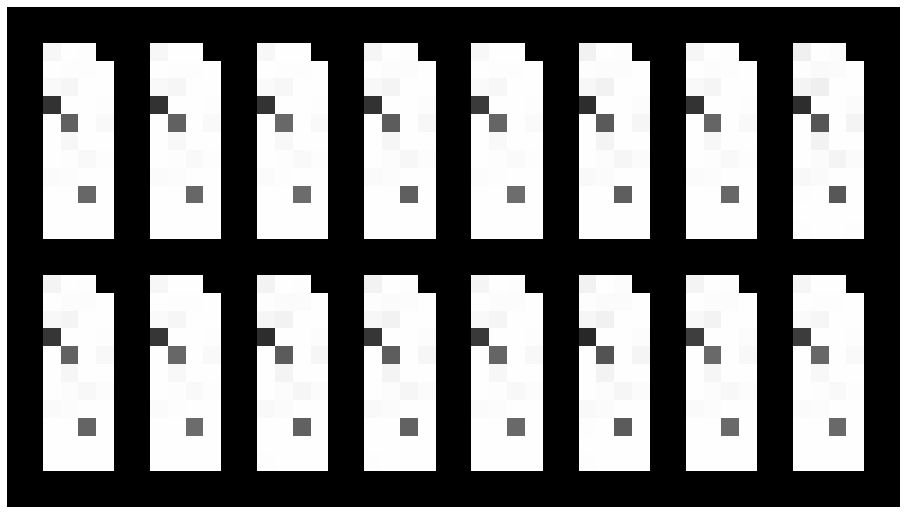

Epoch: [181/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.3115
D(x): 1.0000, D(G(z)): 0.0000


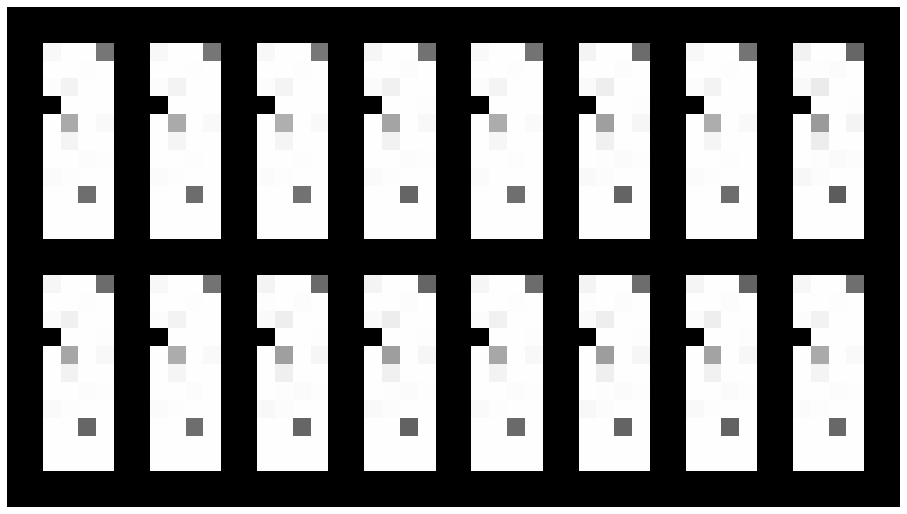

Epoch: [182/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 13.0139
D(x): 1.0000, D(G(z)): 0.0000


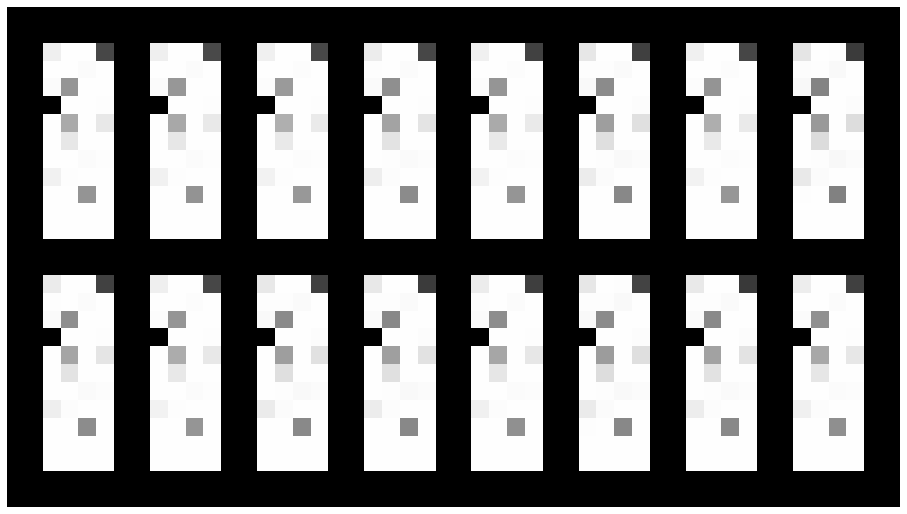

Epoch: [183/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 13.1004
D(x): 1.0000, D(G(z)): 0.0000


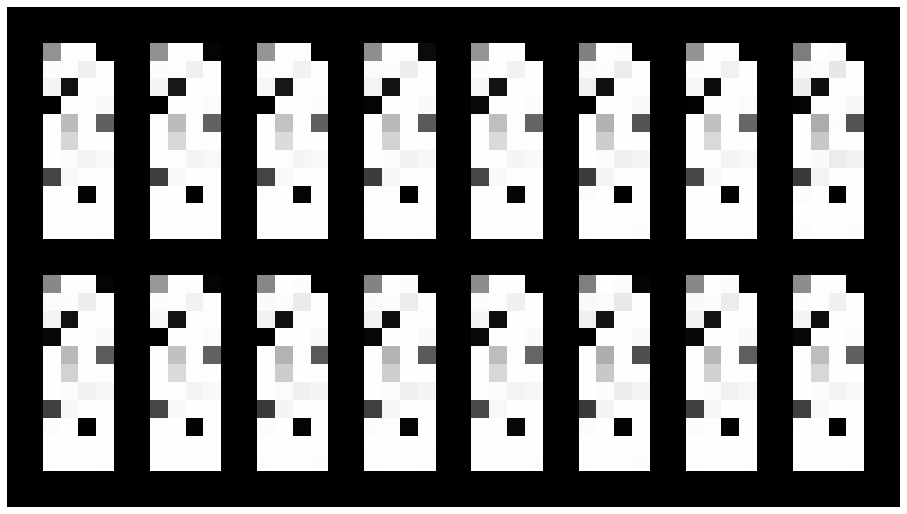

Epoch: [184/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.7553
D(x): 1.0000, D(G(z)): 0.0000


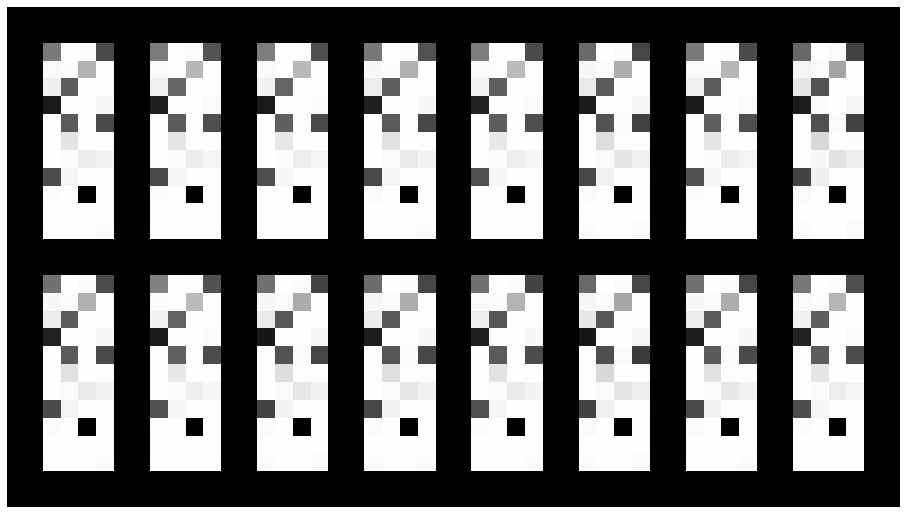

Epoch: [185/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.7746
D(x): 1.0000, D(G(z)): 0.0000


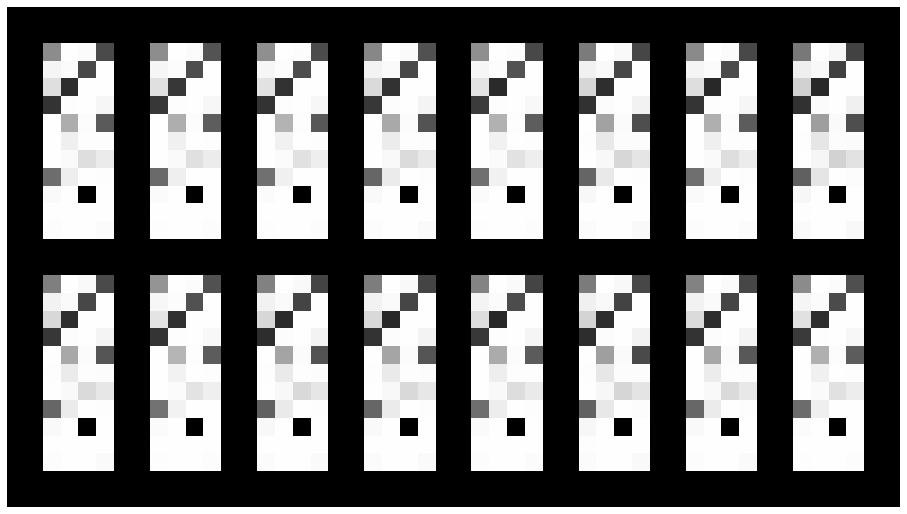

Epoch: [186/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.6008
D(x): 1.0000, D(G(z)): 0.0000


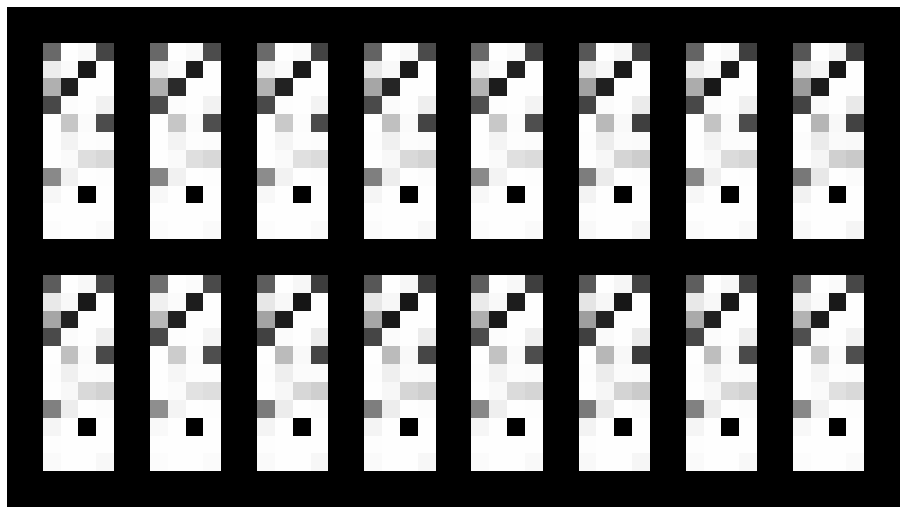

Epoch: [187/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.4333
D(x): 1.0000, D(G(z)): 0.0000


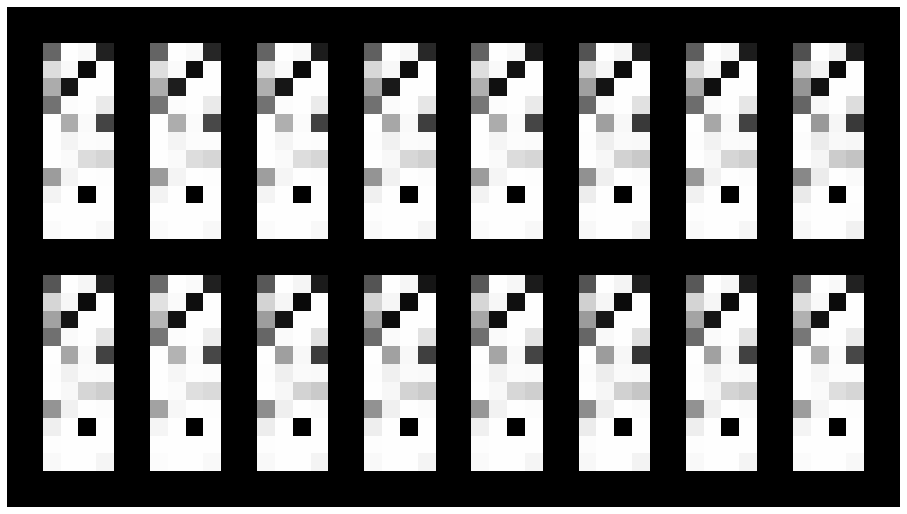

Epoch: [188/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.3711
D(x): 1.0000, D(G(z)): 0.0000


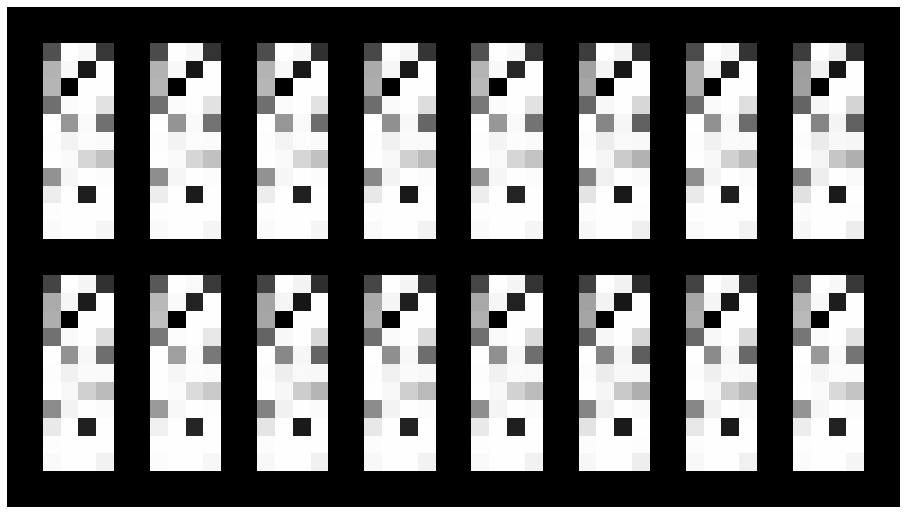

Epoch: [189/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.3501
D(x): 1.0000, D(G(z)): 0.0000


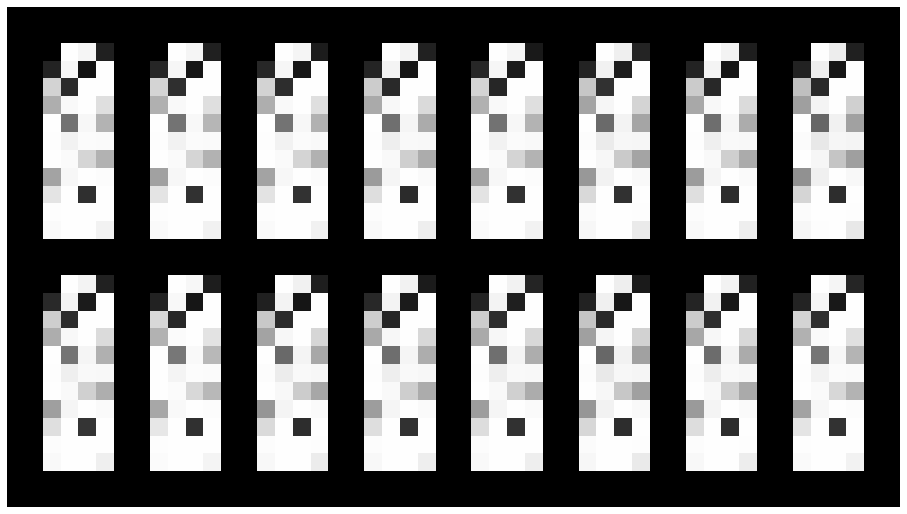

Epoch: [190/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.4132
D(x): 1.0000, D(G(z)): 0.0000


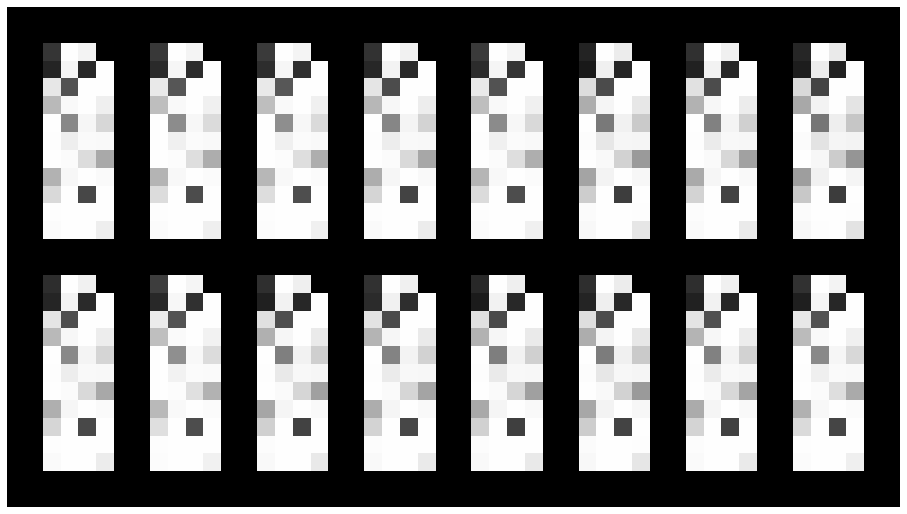

Epoch: [191/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.4552
D(x): 1.0000, D(G(z)): 0.0000


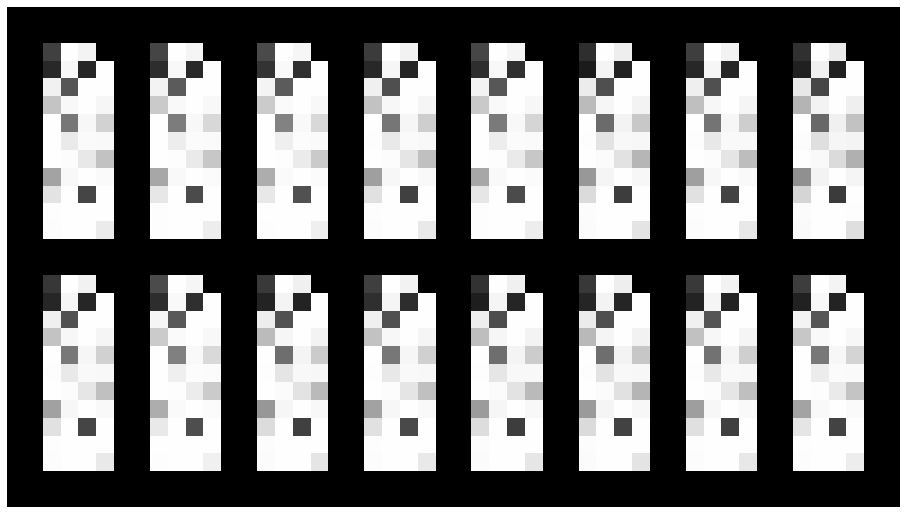

Epoch: [192/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.2478
D(x): 1.0000, D(G(z)): 0.0000


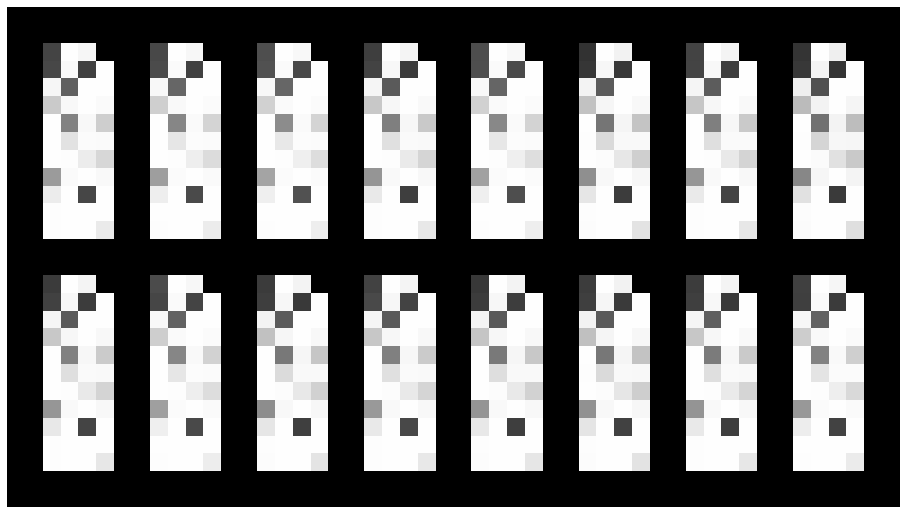

Epoch: [193/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.6571
D(x): 1.0000, D(G(z)): 0.0000


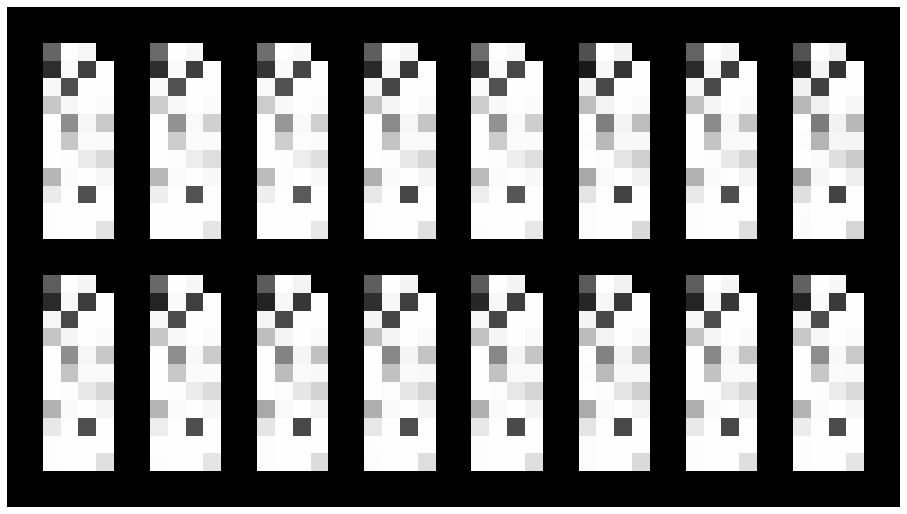

Epoch: [194/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 11.8490
D(x): 1.0000, D(G(z)): 0.0000


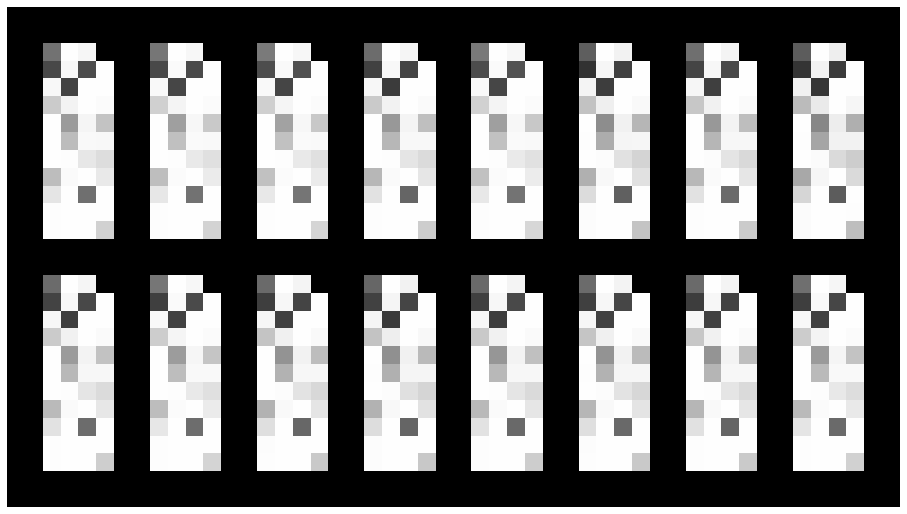

Epoch: [195/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.2208
D(x): 1.0000, D(G(z)): 0.0000


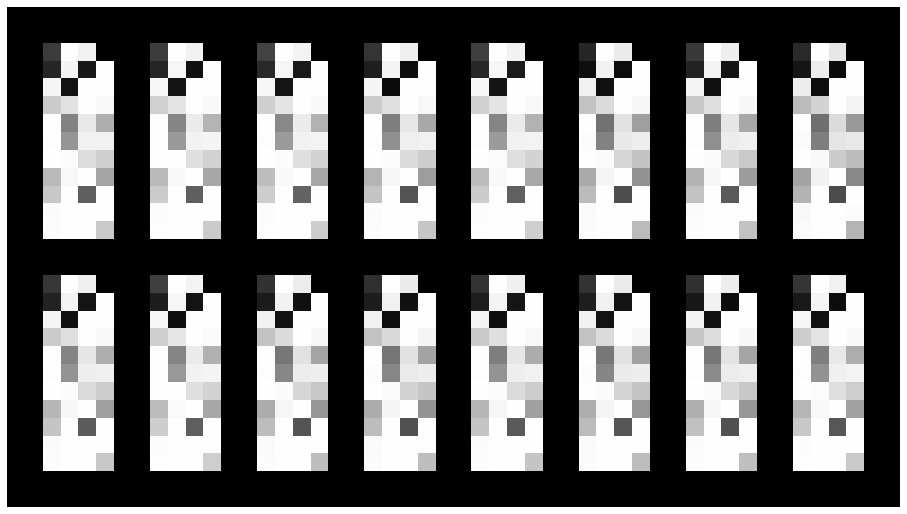

Epoch: [196/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.4607
D(x): 1.0000, D(G(z)): 0.0000


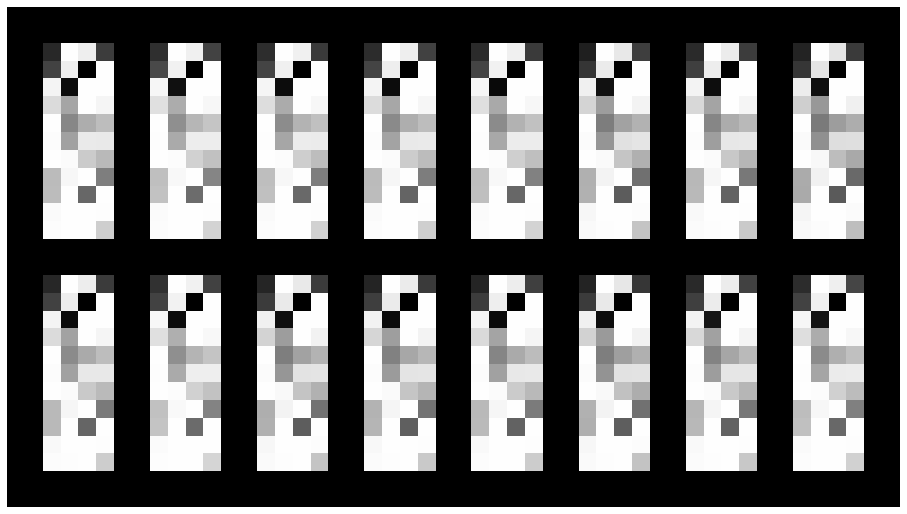

Epoch: [197/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.3379
D(x): 1.0000, D(G(z)): 0.0000


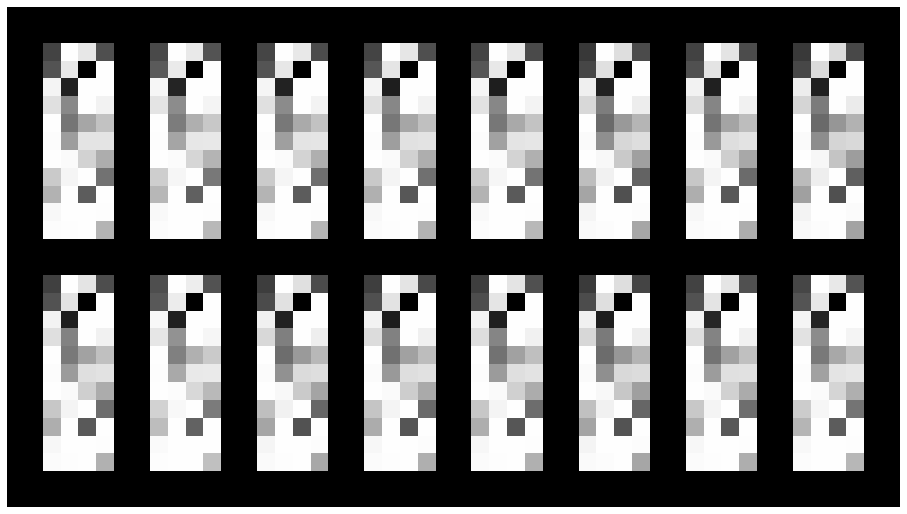

Epoch: [198/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.5142
D(x): 1.0000, D(G(z)): 0.0000


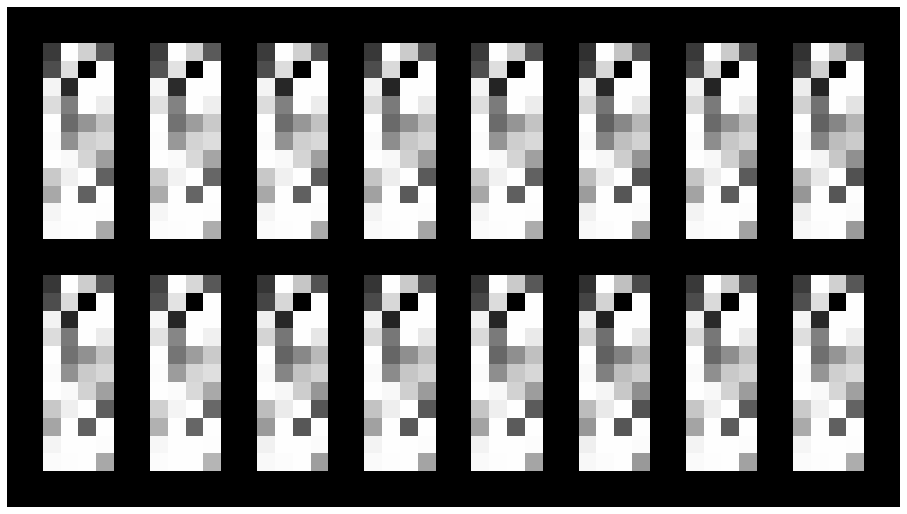

Epoch: [199/200], Batch Num: [0/12]
Discriminator Loss: 0.0000, Generator Loss: 12.5994
D(x): 1.0000, D(G(z)): 0.0000


In [54]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        # print('real')
        # print(real_batch.dtype)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

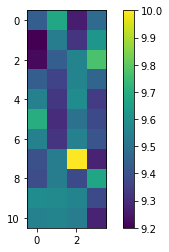

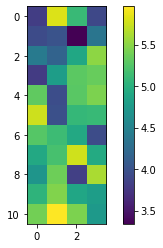

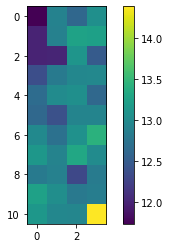

In [65]:
for i,(batch,_) in enumerate(data_loader):
    if i == 3:
        break
    plt.figure()
    plt.imshow(batch[0].reshape(11,4))
    plt.colorbar()

In [66]:
test_data = generator(noise(1))

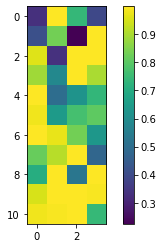

In [109]:
test_data = generator(noise(10))
plt.imshow(test_data[6].reshape(11,4).detach().numpy())
plt.colorbar()

In [162]:
generator(noise(1)).mean()

tensor(0.8185, grad_fn=<MeanBackward0>)

In [118]:
noise(1)

tensor([[ 0.6964, -0.2241, -2.0052,  0.8512, -0.7497,  0.4163,  0.5833,  0.4858,
         -1.7201, -0.8344, -1.5011,  0.5380, -0.3623, -0.6769, -0.8073, -1.5729,
         -0.1157, -2.1746,  1.0986,  1.2381, -1.3505,  0.1048, -2.6693, -0.1066,
         -1.0205, -0.8584, -0.1272,  0.9530, -0.4208, -1.3352, -0.4813, -2.0198,
          0.1465,  1.3001, -0.7935,  1.3708,  0.0810,  0.6351,  1.1828,  0.5036,
          0.3523, -1.3423,  0.9977, -1.5478,  0.0226, -0.2549,  0.0288,  0.5597,
          2.2047, -1.3341, -0.3967, -0.2448,  0.2732, -1.1494,  0.9611, -0.2584,
         -1.0056, -0.5663, -1.3661,  0.8651,  0.3314,  0.3886, -0.0628, -0.1339,
          0.1157,  1.6663, -0.8608, -0.9584,  0.3608, -0.5499, -1.3914, -1.9176,
         -1.3858, -0.1352,  0.7683, -1.5374,  0.7950, -0.0856, -0.4011, -0.0616,
          0.4364, -3.1992,  0.0077,  1.3433,  0.3500, -1.3761, -0.7583,  1.6546,
         -2.4597,  0.5679, -1.0676, -0.8605, -0.6464, -0.1039,  0.2284, -0.5422,
         -0.9066, -2.1357,  

In [120]:
generator(noise(1))

tensor([[0.3820, 0.9988, 0.7820, 0.4258, 0.4496, 0.8704, 0.2460, 0.9999, 0.9757,
         0.3678, 0.9992, 0.9992, 0.9145, 0.6427, 0.9996, 0.9296, 0.9995, 0.5563,
         0.6719, 0.7862, 0.9902, 0.6993, 0.8212, 0.8489, 0.9998, 0.9849, 0.8696,
         0.6949, 0.8563, 0.9385, 0.9998, 0.5332, 0.7542, 0.9995, 0.5695, 0.9988,
         0.9702, 0.9996, 0.9994, 0.9953, 0.9911, 0.9967, 0.9995, 0.7901]],
       grad_fn=<TanhBackward>)

In [173]:
tt1 = noise(1)
print(tt1)
t1 = generator(tt1)
print(t1)
print(t1.mean())
print(t1.std())

tensor([[ 1.9052, -0.3713, -0.0398, -1.3805,  0.3468,  1.3899,  0.1421, -0.0830,
          0.3005,  1.8099,  0.0945,  0.6424, -1.2343, -0.7465, -1.0543,  0.7614,
         -0.4977, -0.4851, -0.3094, -0.9156, -0.6718,  0.7903, -0.9042, -0.3772,
          0.5686,  0.3770, -0.6828,  1.2209, -0.3007,  0.0057, -0.5003,  0.2630,
         -0.1697,  1.0713,  0.0251, -0.0701,  0.6583, -0.9194, -0.0426,  0.2684,
          1.0154, -0.3343, -1.3085,  1.3239,  0.4134,  0.6267,  0.6562, -0.3280,
          1.2477, -2.0921,  0.2781, -0.2593, -0.3260,  0.4644,  0.0206,  0.0912,
          0.6259,  1.7458,  0.2578, -0.5523, -0.1439, -0.2140, -0.3934,  0.1311,
         -0.8209, -0.6253,  2.6706,  1.1979, -1.0173, -1.1219,  0.8039,  0.5711,
         -0.5254,  0.7469, -0.5588, -0.9879, -0.2085, -0.1309,  1.2723,  1.7689,
         -1.5176, -0.5347, -1.6106, -0.9981,  0.4424, -0.6146, -0.6145,  0.2934,
          0.2005,  0.0885, -0.5092,  0.1572, -1.2881,  0.4571,  0.0769, -0.0970,
          0.0539,  1.2203,  

In [174]:
tt2 = noise(1)
print(tt2)
t2 = generator(tt2)
print(t2)
print(t2.mean())
print(t2.std())

tensor([[ 0.3122, -0.6835,  0.7226, -0.8555, -0.8464, -0.4631, -0.3984, -0.6958,
         -1.0191,  2.0594,  0.3084,  0.5655,  1.0612, -0.8566,  0.5034, -1.3580,
          0.9540,  0.0929, -1.4029, -0.2494,  0.1792,  2.5223,  1.2418, -0.9528,
          1.2634, -0.1939, -1.7222,  1.0483, -0.0425,  0.0343,  1.8840,  0.0458,
         -0.3344, -0.1296, -1.1909, -0.7113,  2.0925,  2.1533, -0.6409, -0.2809,
          0.7901,  2.3405,  1.6650, -1.0925,  0.9369,  2.8731, -0.0968, -0.1058,
         -0.3158,  0.5096,  0.1637,  0.3061, -0.3615, -2.6701,  1.8173,  0.4503,
          0.9736, -0.5616, -2.1298, -0.1210, -0.4579,  1.2261,  0.0143, -0.7260,
         -1.1175, -0.2750,  0.7215, -0.2935, -1.5309,  0.3993,  1.6404, -1.1126,
          0.8154,  3.0909, -0.6120,  0.1242,  1.3276,  0.0298, -0.2286, -2.4140,
         -0.0535, -0.4377, -0.8416,  0.0785,  0.9136,  1.0716, -1.3790, -0.3459,
         -0.7975, -0.2258, -2.1019,  0.6861, -0.3992, -1.0182, -0.5025,  0.5616,
          1.2764,  0.3789, -

In [184]:
t2-t2.mean()

tensor([[-0.4440,  0.1652, -0.0295, -0.4081, -0.3738,  0.0542, -0.5892,  0.1659,
          0.1461, -0.4522,  0.1654,  0.1654,  0.0910, -0.1830,  0.1657,  0.1047,
          0.1657, -0.2762, -0.1360, -0.0201,  0.1589, -0.1112,  0.0139,  0.0314,
          0.1658,  0.1544,  0.0468, -0.1123,  0.0404,  0.1145,  0.1658, -0.2725,
         -0.0628,  0.1657, -0.2455,  0.1652,  0.1412,  0.1658,  0.1655,  0.1627,
          0.1592,  0.1637,  0.1657, -0.0194]], grad_fn=<SubBackward0>)

In [111]:
discriminator(test_data[0])

tensor([9.6205e-07], grad_fn=<SigmoidBackward>)

In [113]:
discriminator(test_data)

tensor([[1.3755e-04],
        [7.2931e-06],
        [2.5377e-05],
        [1.9081e-05],
        [5.2480e-05],
        [2.1036e-06],
        [1.4788e-05],
        [4.3694e-06],
        [7.7683e-07],
        [5.4577e-06]], grad_fn=<SigmoidBackward>)

In [185]:
discriminator(real_batch[0]-real_batch[0].mean())

tensor([6.6176e-07], grad_fn=<SigmoidBackward>)

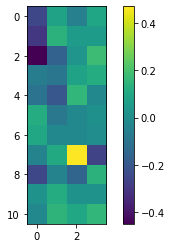

In [188]:
plt.imshow((real_batch[0]-real_batch[0].mean()).reshape(11,4))
plt.colorbar()

In [190]:
means = []
for i in range(len(real_batch)):
    means.append(real_batch[i].mean())

In [193]:
import numpy as np

In [198]:
means[3]

tensor(7.8561)

In [186]:
discriminator(real_batch[0])

tensor([1.], grad_fn=<SigmoidBackward>)

In [181]:
real_batch[0].mean()

tensor(7.6991)

In [182]:
real_batch[0].std()

tensor(0.1585)

In [204]:
means = real_batch.mean(axis=1)

In [216]:
ff = (real_batch.T-means).T

In [61]:
import matplotlib.pyplot as plt

In [231]:
tmp1 = real_batch[0] - real_batch[0].mean()
print(tmp1)
print(real_batch[0].std())

tensor([-0.2491,  0.0809, -0.0491,  0.0909, -0.2991,  0.1409,  0.0609,  0.0609,
        -0.4491, -0.1591,  0.0309,  0.1809, -0.0591, -0.0891,  0.0809,  0.1209,
        -0.0991, -0.1991,  0.1609, -0.0191,  0.1209, -0.0791, -0.0191,  0.0109,
         0.1009, -0.0191, -0.0191,  0.0009, -0.0391,  0.1109,  0.4709, -0.2591,
        -0.2491, -0.0391, -0.1491,  0.1409,  0.0209,  0.1209,  0.0209,  0.0209,
        -0.0191,  0.1509,  0.1009,  0.1609])
tensor(0.1585)


In [242]:
tmp2 = real_batch[1] - real_batch[1].mean()
print(tmp2)
print(real_batch[1].mean())
print(real_batch[1])
print(real_batch[1].std())

tensor([ 0.6332, -0.1068,  0.3632,  0.1132, -0.0268, -0.1668,  0.2932,  0.2732,
        -0.1468, -0.3868,  0.5032,  0.7132,  0.2332,  0.4232,  0.1232, -0.0668,
        -0.2868, -0.0968, -0.1468, -0.2568,  0.1532, -0.2968,  0.3332,  0.2032,
        -0.0268,  0.6532,  0.3732,  0.0932, -0.3368, -0.0568, -0.3868, -0.8868,
        -0.7368, -0.5468,  0.2532, -0.1268, -0.0068, -0.1468,  0.7832, -0.5268,
        -0.2868, -0.5868,  0.3732, -0.2468])
tensor(10.0068)
tensor([10.6400,  9.9000, 10.3700, 10.1200,  9.9800,  9.8400, 10.3000, 10.2800,
         9.8600,  9.6200, 10.5100, 10.7200, 10.2400, 10.4300, 10.1300,  9.9400,
         9.7200,  9.9100,  9.8600,  9.7500, 10.1600,  9.7100, 10.3400, 10.2100,
         9.9800, 10.6600, 10.3800, 10.1000,  9.6700,  9.9500,  9.6200,  9.1200,
         9.2700,  9.4600, 10.2600,  9.8800, 10.0000,  9.8600, 10.7900,  9.4800,
         9.7200,  9.4200, 10.3800,  9.7600])
tensor(0.3877)


(array([ 7.,  6., 19., 26., 33., 26., 17., 24., 13., 13., 10.,  4.,  4.,
        10.,  4.,  4.,  1.,  3.,  4.,  3.,  2.,  2.,  1.,  7.,  3.,  7.,
         8.,  4.,  3.,  8.,  2.,  2.,  4.,  2.,  2.,  2.,  3.,  7.,  4.,
         4.,  3.,  1.,  4.,  2.,  4.,  2.,  3.,  3.,  6.,  4.,  4.,  1.,
         5.,  3.,  4.,  2.,  3.,  4.,  3.,  4.,  4.,  1.,  4.,  6.,  5.,
         5.,  1.,  0.,  1.,  4.,  2.,  2.,  1.,  4.,  2.,  2.,  6.,  1.,
         3.,  3.,  4.,  6.,  2.,  2.,  2.,  3.,  2.,  3.,  2.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([0.13058719, 0.14024067, 0.14989416, 0.15954764, 0.16920112,
        0.17885461, 0.1885081 , 0.19816157, 0.20781507, 0.21746854,
        0.22712202, 0.23677552, 0.246429  , 0.25608248, 0.26573595,
        0.27538946, 0.28504294, 0.29469642, 0.3043499 , 0.31400338,
        0.32365686, 0.33331037, 0.34296384, 0.35261732, 0.3622708 ,
        0.37192428, 0.38157776, 0.39123127, 0.40088475, 0.41053823,
        0.4201917 , 0.4298

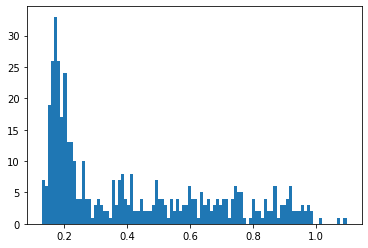

In [241]:
real_batch.std(axis=1)
plt.hist(real_batch.std(axis=1),bins=100)

(array([ 3.,  1.,  0.,  1.,  4.,  0.,  0.,  0.,  0.,  2.,  1.,  1.,  1.,
         3.,  2.,  3.,  2.,  2.,  0.,  1.,  0.,  1.,  2.,  1.,  3.,  2.,
         0.,  0.,  0.,  2.,  1.,  0.,  3.,  0.,  2.,  6.,  2.,  3.,  3.,
         9.,  5., 15., 25., 11., 23., 11., 21., 14., 13., 12.,  8., 10.,
         8., 10., 11., 13., 12., 22., 15., 13.,  5., 15., 13.,  5.,  4.,
         5.,  6.,  6.,  3.,  3.,  4.,  2.,  3.,  1.,  5.,  2.,  1.,  0.,
         3.,  0.,  1.,  3.,  4.,  5.,  2.,  3.,  2.,  3.,  1.,  0.,  0.,
         1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.]),
 array([ 2.978863 ,  3.0968153,  3.2147675,  3.3327198,  3.4506721,
         3.5686245,  3.6865766,  3.804529 ,  3.9224813,  4.0404334,
         4.1583858,  4.276338 ,  4.3942904,  4.512243 ,  4.6301947,
         4.748147 ,  4.8660994,  4.9840517,  5.102004 ,  5.2199564,
         5.3379087,  5.4558606,  5.573813 ,  5.6917653,  5.8097177,
         5.92767  ,  6.0456223,  6.1635747,  6.2815266,  6.399479 ,
         6.5174313,  6.635

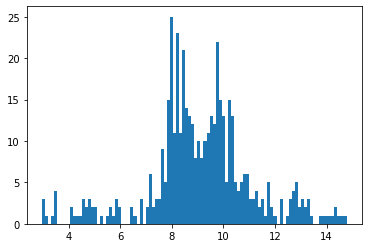

In [243]:
real_batch.std(axis=1)
plt.hist(real_batch.mean(axis=1),bins=100)